In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId

threshold = 0.6

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.05,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : 0,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'streamline',
    'balance_data'  : True,
    'balance_bins'  : 10,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 4,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_4_10_1_0_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_0_streamline_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_0_native_08_05_005


Epoch 1/10000


  1/585 [..............................] - ETA: 15:54 - loss: 0.1695 - STD: 1.6730e-04 - MAE: 0.3357

  4/585 [..............................] - ETA: 13s - loss: 0.1217 - STD: 5.7926e-04 - MAE: 0.2887  

  7/585 [..............................] - ETA: 13s - loss: 0.1112 - STD: 4.7783e-04 - MAE: 0.2785

 10/585 [..............................] - ETA: 13s - loss: 0.1069 - STD: 3.8866e-04 - MAE: 0.2739

 13/585 [..............................] - ETA: 13s - loss: 0.1040 - STD: 3.5275e-04 - MAE: 0.2711

 16/585 [..............................] - ETA: 13s - loss: 0.1012 - STD: 3.4025e-04 - MAE: 0.2683

 19/585 [..............................] - ETA: 13s - loss: 0.1001 - STD: 3.3687e-04 - MAE: 0.2674

 22/585 [>.............................] - ETA: 12s - loss: 0.0986 - STD: 3.3992e-04 - MAE: 0.2659

 25/585 [>.............................] - ETA: 12s - loss: 0.0976 - STD: 3.4631e-04 - MAE: 0.2650

 28/585 [>.............................] - ETA: 12s - loss: 0.0968 - STD: 3.5534e-04 - MAE: 0.2641

 31/585 [>.............................] - ETA: 12s - loss: 0.0959 - STD: 3.6644e-04 - MAE: 0.2631

 34/585 [>.............................] - ETA: 12s - loss: 0.0954 - STD: 3.7893e-04 - MAE: 0.2627

 37/585 [>.............................] - ETA: 12s - loss: 0.0948 - STD: 3.9393e-04 - MAE: 0.2621

 40/585 [=>............................] - ETA: 12s - loss: 0.0943 - STD: 4.1087e-04 - MAE: 0.2616

 43/585 [=>............................] - ETA: 12s - loss: 0.0939 - STD: 4.2984e-04 - MAE: 0.2612

 46/585 [=>............................] - ETA: 12s - loss: 0.0936 - STD: 4.5106e-04 - MAE: 0.2609

 49/585 [=>............................] - ETA: 12s - loss: 0.0933 - STD: 4.7452e-04 - MAE: 0.2606

 52/585 [=>............................] - ETA: 12s - loss: 0.0930 - STD: 5.0165e-04 - MAE: 0.2603

 55/585 [=>............................] - ETA: 12s - loss: 0.0928 - STD: 5.3255e-04 - MAE: 0.2600

 58/585 [=>............................] - ETA: 12s - loss: 0.0925 - STD: 5.6798e-04 - MAE: 0.2598

 61/585 [==>...........................] - ETA: 11s - loss: 0.0923 - STD: 6.0828e-04 - MAE: 0.2596

 64/585 [==>...........................] - ETA: 11s - loss: 0.0921 - STD: 6.5385e-04 - MAE: 0.2594

 67/585 [==>...........................] - ETA: 11s - loss: 0.0919 - STD: 7.0693e-04 - MAE: 0.2591

 70/585 [==>...........................] - ETA: 11s - loss: 0.0917 - STD: 7.7018e-04 - MAE: 0.2589

 73/585 [==>...........................] - ETA: 11s - loss: 0.0915 - STD: 8.4362e-04 - MAE: 0.2587

 76/585 [==>...........................] - ETA: 11s - loss: 0.0914 - STD: 9.2966e-04 - MAE: 0.2586

 79/585 [===>..........................] - ETA: 11s - loss: 0.0913 - STD: 0.0010 - MAE: 0.2584    

 82/585 [===>..........................] - ETA: 11s - loss: 0.0911 - STD: 0.0012 - MAE: 0.2583

 85/585 [===>..........................] - ETA: 11s - loss: 0.0910 - STD: 0.0013 - MAE: 0.2581

 88/585 [===>..........................] - ETA: 11s - loss: 0.0908 - STD: 0.0015 - MAE: 0.2580

 91/585 [===>..........................] - ETA: 11s - loss: 0.0907 - STD: 0.0017 - MAE: 0.2578

 94/585 [===>..........................] - ETA: 11s - loss: 0.0906 - STD: 0.0020 - MAE: 0.2577

 97/585 [===>..........................] - ETA: 11s - loss: 0.0905 - STD: 0.0024 - MAE: 0.2576

100/585 [====>.........................] - ETA: 11s - loss: 0.0903 - STD: 0.0029 - MAE: 0.2574

103/585 [====>.........................] - ETA: 10s - loss: 0.0901 - STD: 0.0035 - MAE: 0.2572

106/585 [====>.........................] - ETA: 10s - loss: 0.0899 - STD: 0.0043 - MAE: 0.2569

109/585 [====>.........................] - ETA: 10s - loss: 0.0897 - STD: 0.0053 - MAE: 0.2567

112/585 [====>.........................] - ETA: 10s - loss: 0.0895 - STD: 0.0066 - MAE: 0.2563

115/585 [====>.........................] - ETA: 10s - loss: 0.0892 - STD: 0.0081 - MAE: 0.2559

118/585 [=====>........................] - ETA: 10s - loss: 0.0888 - STD: 0.0099 - MAE: 0.2554

121/585 [=====>........................] - ETA: 10s - loss: 0.0884 - STD: 0.0120 - MAE: 0.2549

124/585 [=====>........................] - ETA: 10s - loss: 0.0880 - STD: 0.0143 - MAE: 0.2542

127/585 [=====>........................] - ETA: 10s - loss: 0.0875 - STD: 0.0168 - MAE: 0.2534

130/585 [=====>........................] - ETA: 10s - loss: 0.0871 - STD: 0.0194 - MAE: 0.2527

133/585 [=====>........................] - ETA: 10s - loss: 0.0866 - STD: 0.0221 - MAE: 0.2519

136/585 [=====>........................] - ETA: 10s - loss: 0.0861 - STD: 0.0246 - MAE: 0.2512

139/585 [======>.......................] - ETA: 10s - loss: 0.0857 - STD: 0.0270 - MAE: 0.2504

142/585 [======>.......................] - ETA: 10s - loss: 0.0852 - STD: 0.0294 - MAE: 0.2496

145/585 [======>.......................] - ETA: 10s - loss: 0.0848 - STD: 0.0319 - MAE: 0.2489

148/585 [======>.......................] - ETA: 9s - loss: 0.0844 - STD: 0.0344 - MAE: 0.2482 

151/585 [======>.......................] - ETA: 9s - loss: 0.0840 - STD: 0.0368 - MAE: 0.2474

154/585 [======>.......................] - ETA: 9s - loss: 0.0836 - STD: 0.0391 - MAE: 0.2467

157/585 [=======>......................] - ETA: 9s - loss: 0.0832 - STD: 0.0413 - MAE: 0.2460

160/585 [=======>......................] - ETA: 9s - loss: 0.0828 - STD: 0.0434 - MAE: 0.2454

163/585 [=======>......................] - ETA: 9s - loss: 0.0824 - STD: 0.0455 - MAE: 0.2448

166/585 [=======>......................] - ETA: 9s - loss: 0.0820 - STD: 0.0475 - MAE: 0.2441

169/585 [=======>......................] - ETA: 9s - loss: 0.0817 - STD: 0.0494 - MAE: 0.2435

172/585 [=======>......................] - ETA: 9s - loss: 0.0814 - STD: 0.0513 - MAE: 0.2429

175/585 [=======>......................] - ETA: 9s - loss: 0.0810 - STD: 0.0530 - MAE: 0.2424

178/585 [========>.....................] - ETA: 9s - loss: 0.0807 - STD: 0.0547 - MAE: 0.2418

181/585 [========>.....................] - ETA: 9s - loss: 0.0804 - STD: 0.0564 - MAE: 0.2412

184/585 [========>.....................] - ETA: 9s - loss: 0.0801 - STD: 0.0581 - MAE: 0.2407

187/585 [========>.....................] - ETA: 9s - loss: 0.0798 - STD: 0.0598 - MAE: 0.2401

190/585 [========>.....................] - ETA: 8s - loss: 0.0795 - STD: 0.0614 - MAE: 0.2396

193/585 [========>.....................] - ETA: 8s - loss: 0.0792 - STD: 0.0629 - MAE: 0.2391

195/585 [=========>....................] - ETA: 10s - loss: 0.0791 - STD: 0.0639 - MAE: 0.2387

198/585 [=========>....................] - ETA: 10s - loss: 0.0788 - STD: 0.0654 - MAE: 0.2382

201/585 [=========>....................] - ETA: 10s - loss: 0.0785 - STD: 0.0668 - MAE: 0.2377

204/585 [=========>....................] - ETA: 9s - loss: 0.0782 - STD: 0.0683 - MAE: 0.2372 

207/585 [=========>....................] - ETA: 9s - loss: 0.0779 - STD: 0.0697 - MAE: 0.2367

210/585 [=========>....................] - ETA: 9s - loss: 0.0777 - STD: 0.0710 - MAE: 0.2363

213/585 [=========>....................] - ETA: 9s - loss: 0.0774 - STD: 0.0723 - MAE: 0.2358

216/585 [==========>...................] - ETA: 9s - loss: 0.0772 - STD: 0.0735 - MAE: 0.2354

219/585 [==========>...................] - ETA: 9s - loss: 0.0769 - STD: 0.0748 - MAE: 0.2349

222/585 [==========>...................] - ETA: 9s - loss: 0.0767 - STD: 0.0760 - MAE: 0.2345

225/585 [==========>...................] - ETA: 9s - loss: 0.0765 - STD: 0.0772 - MAE: 0.2341

228/585 [==========>...................] - ETA: 9s - loss: 0.0762 - STD: 0.0783 - MAE: 0.2337

231/585 [==========>...................] - ETA: 9s - loss: 0.0760 - STD: 0.0794 - MAE: 0.2333

234/585 [===========>..................] - ETA: 9s - loss: 0.0758 - STD: 0.0805 - MAE: 0.2329

237/585 [===========>..................] - ETA: 8s - loss: 0.0756 - STD: 0.0816 - MAE: 0.2325

240/585 [===========>..................] - ETA: 8s - loss: 0.0754 - STD: 0.0827 - MAE: 0.2321

243/585 [===========>..................] - ETA: 8s - loss: 0.0752 - STD: 0.0838 - MAE: 0.2318

246/585 [===========>..................] - ETA: 8s - loss: 0.0749 - STD: 0.0848 - MAE: 0.2314

249/585 [===========>..................] - ETA: 8s - loss: 0.0747 - STD: 0.0858 - MAE: 0.2310

252/585 [===========>..................] - ETA: 8s - loss: 0.0746 - STD: 0.0867 - MAE: 0.2307

255/585 [============>.................] - ETA: 8s - loss: 0.0744 - STD: 0.0877 - MAE: 0.2304

258/585 [============>.................] - ETA: 8s - loss: 0.0742 - STD: 0.0886 - MAE: 0.2301

261/585 [============>.................] - ETA: 8s - loss: 0.0740 - STD: 0.0895 - MAE: 0.2297

264/585 [============>.................] - ETA: 8s - loss: 0.0738 - STD: 0.0903 - MAE: 0.2294

267/585 [============>.................] - ETA: 8s - loss: 0.0737 - STD: 0.0913 - MAE: 0.2291

270/585 [============>.................] - ETA: 7s - loss: 0.0735 - STD: 0.0922 - MAE: 0.2288

273/585 [=============>................] - ETA: 7s - loss: 0.0733 - STD: 0.0930 - MAE: 0.2285

276/585 [=============>................] - ETA: 7s - loss: 0.0732 - STD: 0.0938 - MAE: 0.2282

279/585 [=============>................] - ETA: 7s - loss: 0.0730 - STD: 0.0946 - MAE: 0.2279

282/585 [=============>................] - ETA: 7s - loss: 0.0728 - STD: 0.0954 - MAE: 0.2276

285/585 [=============>................] - ETA: 7s - loss: 0.0727 - STD: 0.0962 - MAE: 0.2273

288/585 [=============>................] - ETA: 7s - loss: 0.0725 - STD: 0.0970 - MAE: 0.2270

291/585 [=============>................] - ETA: 7s - loss: 0.0724 - STD: 0.0978 - MAE: 0.2267

294/585 [==============>...............] - ETA: 7s - loss: 0.0722 - STD: 0.0985 - MAE: 0.2264

297/585 [==============>...............] - ETA: 7s - loss: 0.0721 - STD: 0.0992 - MAE: 0.2261

300/585 [==============>...............] - ETA: 7s - loss: 0.0719 - STD: 0.1000 - MAE: 0.2259

303/585 [==============>...............] - ETA: 7s - loss: 0.0718 - STD: 0.1007 - MAE: 0.2256

306/585 [==============>...............] - ETA: 6s - loss: 0.0717 - STD: 0.1013 - MAE: 0.2254

309/585 [==============>...............] - ETA: 6s - loss: 0.0715 - STD: 0.1020 - MAE: 0.2252

312/585 [===============>..............] - ETA: 6s - loss: 0.0714 - STD: 0.1026 - MAE: 0.2250

315/585 [===============>..............] - ETA: 6s - loss: 0.0713 - STD: 0.1032 - MAE: 0.2247

318/585 [===============>..............] - ETA: 6s - loss: 0.0711 - STD: 0.1038 - MAE: 0.2245

321/585 [===============>..............] - ETA: 6s - loss: 0.0710 - STD: 0.1045 - MAE: 0.2242

324/585 [===============>..............] - ETA: 6s - loss: 0.0709 - STD: 0.1051 - MAE: 0.2240

327/585 [===============>..............] - ETA: 6s - loss: 0.0708 - STD: 0.1058 - MAE: 0.2238

330/585 [===============>..............] - ETA: 6s - loss: 0.0706 - STD: 0.1064 - MAE: 0.2235

333/585 [================>.............] - ETA: 6s - loss: 0.0705 - STD: 0.1070 - MAE: 0.2233

336/585 [================>.............] - ETA: 6s - loss: 0.0704 - STD: 0.1075 - MAE: 0.2231

339/585 [================>.............] - ETA: 6s - loss: 0.0703 - STD: 0.1081 - MAE: 0.2229

342/585 [================>.............] - ETA: 6s - loss: 0.0701 - STD: 0.1087 - MAE: 0.2226

345/585 [================>.............] - ETA: 5s - loss: 0.0700 - STD: 0.1093 - MAE: 0.2224

348/585 [================>.............] - ETA: 5s - loss: 0.0699 - STD: 0.1098 - MAE: 0.2222

351/585 [=================>............] - ETA: 5s - loss: 0.0698 - STD: 0.1104 - MAE: 0.2220

354/585 [=================>............] - ETA: 5s - loss: 0.0697 - STD: 0.1109 - MAE: 0.2218

357/585 [=================>............] - ETA: 5s - loss: 0.0696 - STD: 0.1114 - MAE: 0.2216

360/585 [=================>............] - ETA: 5s - loss: 0.0695 - STD: 0.1119 - MAE: 0.2214

363/585 [=================>............] - ETA: 5s - loss: 0.0694 - STD: 0.1125 - MAE: 0.2212

366/585 [=================>............] - ETA: 5s - loss: 0.0693 - STD: 0.1130 - MAE: 0.2210

369/585 [=================>............] - ETA: 5s - loss: 0.0692 - STD: 0.1135 - MAE: 0.2208

372/585 [==================>...........] - ETA: 5s - loss: 0.0691 - STD: 0.1139 - MAE: 0.2206

375/585 [==================>...........] - ETA: 5s - loss: 0.0690 - STD: 0.1143 - MAE: 0.2205

378/585 [==================>...........] - ETA: 5s - loss: 0.0689 - STD: 0.1147 - MAE: 0.2203

381/585 [==================>...........] - ETA: 5s - loss: 0.0688 - STD: 0.1152 - MAE: 0.2202

384/585 [==================>...........] - ETA: 4s - loss: 0.0687 - STD: 0.1156 - MAE: 0.2200

387/585 [==================>...........] - ETA: 4s - loss: 0.0686 - STD: 0.1161 - MAE: 0.2198

390/585 [===================>..........] - ETA: 4s - loss: 0.0685 - STD: 0.1165 - MAE: 0.2196

393/585 [===================>..........] - ETA: 4s - loss: 0.0684 - STD: 0.1169 - MAE: 0.2195

396/585 [===================>..........] - ETA: 4s - loss: 0.0684 - STD: 0.1173 - MAE: 0.2193

399/585 [===================>..........] - ETA: 4s - loss: 0.0683 - STD: 0.1177 - MAE: 0.2191

402/585 [===================>..........] - ETA: 4s - loss: 0.0682 - STD: 0.1181 - MAE: 0.2189

405/585 [===================>..........] - ETA: 4s - loss: 0.0681 - STD: 0.1186 - MAE: 0.2188

408/585 [===================>..........] - ETA: 4s - loss: 0.0680 - STD: 0.1190 - MAE: 0.2186

411/585 [====================>.........] - ETA: 4s - loss: 0.0679 - STD: 0.1194 - MAE: 0.2185

414/585 [====================>.........] - ETA: 4s - loss: 0.0678 - STD: 0.1198 - MAE: 0.2183

417/585 [====================>.........] - ETA: 4s - loss: 0.0677 - STD: 0.1202 - MAE: 0.2181

420/585 [====================>.........] - ETA: 4s - loss: 0.0677 - STD: 0.1206 - MAE: 0.2180

423/585 [====================>.........] - ETA: 3s - loss: 0.0676 - STD: 0.1210 - MAE: 0.2178

426/585 [====================>.........] - ETA: 3s - loss: 0.0675 - STD: 0.1214 - MAE: 0.2177

429/585 [=====================>........] - ETA: 3s - loss: 0.0674 - STD: 0.1218 - MAE: 0.2175

432/585 [=====================>........] - ETA: 3s - loss: 0.0673 - STD: 0.1222 - MAE: 0.2173

435/585 [=====================>........] - ETA: 3s - loss: 0.0672 - STD: 0.1226 - MAE: 0.2172

438/585 [=====================>........] - ETA: 3s - loss: 0.0671 - STD: 0.1230 - MAE: 0.2170

441/585 [=====================>........] - ETA: 3s - loss: 0.0671 - STD: 0.1233 - MAE: 0.2169

444/585 [=====================>........] - ETA: 3s - loss: 0.0670 - STD: 0.1237 - MAE: 0.2167

447/585 [=====================>........] - ETA: 3s - loss: 0.0669 - STD: 0.1240 - MAE: 0.2166

450/585 [======================>.......] - ETA: 3s - loss: 0.0668 - STD: 0.1244 - MAE: 0.2164

453/585 [======================>.......] - ETA: 3s - loss: 0.0667 - STD: 0.1248 - MAE: 0.2163

456/585 [======================>.......] - ETA: 3s - loss: 0.0667 - STD: 0.1251 - MAE: 0.2162

459/585 [======================>.......] - ETA: 3s - loss: 0.0666 - STD: 0.1255 - MAE: 0.2160

462/585 [======================>.......] - ETA: 2s - loss: 0.0665 - STD: 0.1258 - MAE: 0.2159

465/585 [======================>.......] - ETA: 2s - loss: 0.0665 - STD: 0.1261 - MAE: 0.2158

468/585 [=======================>......] - ETA: 2s - loss: 0.0664 - STD: 0.1264 - MAE: 0.2156

471/585 [=======================>......] - ETA: 2s - loss: 0.0663 - STD: 0.1268 - MAE: 0.2155

474/585 [=======================>......] - ETA: 2s - loss: 0.0663 - STD: 0.1271 - MAE: 0.2154

477/585 [=======================>......] - ETA: 2s - loss: 0.0662 - STD: 0.1274 - MAE: 0.2153

480/585 [=======================>......] - ETA: 2s - loss: 0.0662 - STD: 0.1276 - MAE: 0.2152

483/585 [=======================>......] - ETA: 2s - loss: 0.0661 - STD: 0.1279 - MAE: 0.2151

486/585 [=======================>......] - ETA: 2s - loss: 0.0660 - STD: 0.1282 - MAE: 0.2149

489/585 [========================>.....] - ETA: 2s - loss: 0.0660 - STD: 0.1285 - MAE: 0.2148

492/585 [========================>.....] - ETA: 2s - loss: 0.0659 - STD: 0.1288 - MAE: 0.2147

495/585 [========================>.....] - ETA: 2s - loss: 0.0658 - STD: 0.1291 - MAE: 0.2146

498/585 [========================>.....] - ETA: 2s - loss: 0.0658 - STD: 0.1294 - MAE: 0.2144

501/585 [========================>.....] - ETA: 2s - loss: 0.0657 - STD: 0.1297 - MAE: 0.2143

504/585 [========================>.....] - ETA: 1s - loss: 0.0656 - STD: 0.1300 - MAE: 0.2142

507/585 [=========================>....] - ETA: 1s - loss: 0.0656 - STD: 0.1303 - MAE: 0.2140

510/585 [=========================>....] - ETA: 1s - loss: 0.0655 - STD: 0.1306 - MAE: 0.2139

513/585 [=========================>....] - ETA: 1s - loss: 0.0654 - STD: 0.1309 - MAE: 0.2138

516/585 [=========================>....] - ETA: 1s - loss: 0.0654 - STD: 0.1312 - MAE: 0.2137

519/585 [=========================>....] - ETA: 1s - loss: 0.0653 - STD: 0.1315 - MAE: 0.2136

522/585 [=========================>....] - ETA: 1s - loss: 0.0653 - STD: 0.1318 - MAE: 0.2135

525/585 [=========================>....] - ETA: 1s - loss: 0.0652 - STD: 0.1320 - MAE: 0.2134

528/585 [==========================>...] - ETA: 1s - loss: 0.0652 - STD: 0.1323 - MAE: 0.2133

531/585 [==========================>...] - ETA: 1s - loss: 0.0651 - STD: 0.1325 - MAE: 0.2132

534/585 [==========================>...] - ETA: 1s - loss: 0.0651 - STD: 0.1327 - MAE: 0.2131

537/585 [==========================>...] - ETA: 1s - loss: 0.0650 - STD: 0.1330 - MAE: 0.2130

540/585 [==========================>...] - ETA: 1s - loss: 0.0649 - STD: 0.1332 - MAE: 0.2129

543/585 [==========================>...] - ETA: 1s - loss: 0.0649 - STD: 0.1334 - MAE: 0.2128

546/585 [===========================>..] - ETA: 0s - loss: 0.0648 - STD: 0.1337 - MAE: 0.2127

549/585 [===========================>..] - ETA: 0s - loss: 0.0648 - STD: 0.1339 - MAE: 0.2126

552/585 [===========================>..] - ETA: 0s - loss: 0.0647 - STD: 0.1342 - MAE: 0.2125

555/585 [===========================>..] - ETA: 0s - loss: 0.0647 - STD: 0.1344 - MAE: 0.2123

558/585 [===========================>..] - ETA: 0s - loss: 0.0646 - STD: 0.1347 - MAE: 0.2122

561/585 [===========================>..] - ETA: 0s - loss: 0.0646 - STD: 0.1349 - MAE: 0.2122

564/585 [===========================>..] - ETA: 0s - loss: 0.0645 - STD: 0.1351 - MAE: 0.2121

567/585 [============================>.] - ETA: 0s - loss: 0.0645 - STD: 0.1353 - MAE: 0.2120

570/585 [============================>.] - ETA: 0s - loss: 0.0644 - STD: 0.1355 - MAE: 0.2119

573/585 [============================>.] - ETA: 0s - loss: 0.0644 - STD: 0.1358 - MAE: 0.2118

576/585 [============================>.] - ETA: 0s - loss: 0.0643 - STD: 0.1360 - MAE: 0.2117

579/585 [============================>.] - ETA: 0s - loss: 0.0643 - STD: 0.1362 - MAE: 0.2116

582/585 [============================>.] - ETA: 0s - loss: 0.0642 - STD: 0.1364 - MAE: 0.2115

585/585 [==============================] - ETA: 0s - loss: 0.0642 - STD: 0.1367 - MAE: 0.2114

585/585 [==============================] - 17s 27ms/step - loss: 0.0642 - STD: 0.1367 - MAE: 0.2114 - val_loss: 0.0555 - val_STD: 0.1149 - val_MAE: 0.1906


Epoch 2/10000


  1/585 [..............................] - ETA: 29s - loss: 0.0542 - STD: 0.1794 - MAE: 0.1925

  4/585 [..............................] - ETA: 13s - loss: 0.0543 - STD: 0.1782 - MAE: 0.1933

  7/585 [..............................] - ETA: 13s - loss: 0.0541 - STD: 0.1790 - MAE: 0.1929

 10/585 [..............................] - ETA: 13s - loss: 0.0544 - STD: 0.1793 - MAE: 0.1933

 13/585 [..............................] - ETA: 12s - loss: 0.0543 - STD: 0.1793 - MAE: 0.1929

 16/585 [..............................] - ETA: 12s - loss: 0.0544 - STD: 0.1791 - MAE: 0.1929

 19/585 [..............................] - ETA: 12s - loss: 0.0544 - STD: 0.1791 - MAE: 0.1930

 22/585 [>.............................] - ETA: 12s - loss: 0.0545 - STD: 0.1794 - MAE: 0.1931

 25/585 [>.............................] - ETA: 12s - loss: 0.0544 - STD: 0.1796 - MAE: 0.1930

 28/585 [>.............................] - ETA: 12s - loss: 0.0545 - STD: 0.1800 - MAE: 0.1930

 31/585 [>.............................] - ETA: 12s - loss: 0.0545 - STD: 0.1801 - MAE: 0.1931

 34/585 [>.............................] - ETA: 12s - loss: 0.0545 - STD: 0.1799 - MAE: 0.1931

 37/585 [>.............................] - ETA: 12s - loss: 0.0545 - STD: 0.1795 - MAE: 0.1932

 40/585 [=>............................] - ETA: 12s - loss: 0.0546 - STD: 0.1794 - MAE: 0.1933

 43/585 [=>............................] - ETA: 12s - loss: 0.0546 - STD: 0.1793 - MAE: 0.1933

 46/585 [=>............................] - ETA: 12s - loss: 0.0547 - STD: 0.1794 - MAE: 0.1933

 49/585 [=>............................] - ETA: 12s - loss: 0.0547 - STD: 0.1794 - MAE: 0.1933

 52/585 [=>............................] - ETA: 12s - loss: 0.0547 - STD: 0.1794 - MAE: 0.1932

 55/585 [=>............................] - ETA: 12s - loss: 0.0546 - STD: 0.1794 - MAE: 0.1931

 58/585 [=>............................] - ETA: 11s - loss: 0.0546 - STD: 0.1794 - MAE: 0.1931

 61/585 [==>...........................] - ETA: 11s - loss: 0.0545 - STD: 0.1795 - MAE: 0.1930

 64/585 [==>...........................] - ETA: 11s - loss: 0.0545 - STD: 0.1796 - MAE: 0.1929

 67/585 [==>...........................] - ETA: 11s - loss: 0.0545 - STD: 0.1797 - MAE: 0.1929

 70/585 [==>...........................] - ETA: 11s - loss: 0.0544 - STD: 0.1797 - MAE: 0.1928

 73/585 [==>...........................] - ETA: 11s - loss: 0.0544 - STD: 0.1798 - MAE: 0.1928

 76/585 [==>...........................] - ETA: 11s - loss: 0.0544 - STD: 0.1799 - MAE: 0.1928

 79/585 [===>..........................] - ETA: 11s - loss: 0.0544 - STD: 0.1800 - MAE: 0.1928

 82/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1802 - MAE: 0.1927

 85/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1803 - MAE: 0.1927

 88/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1805 - MAE: 0.1926

 91/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1806 - MAE: 0.1926

 94/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

 97/585 [===>..........................] - ETA: 11s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

100/585 [====>.........................] - ETA: 11s - loss: 0.0543 - STD: 0.1807 - MAE: 0.1926

103/585 [====>.........................] - ETA: 10s - loss: 0.0543 - STD: 0.1807 - MAE: 0.1925

106/585 [====>.........................] - ETA: 10s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

109/585 [====>.........................] - ETA: 10s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1925

112/585 [====>.........................] - ETA: 10s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1924

115/585 [====>.........................] - ETA: 10s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1924

118/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

121/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

124/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1808 - MAE: 0.1925

127/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1807 - MAE: 0.1925

130/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1807 - MAE: 0.1926

133/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1806 - MAE: 0.1925

136/585 [=====>........................] - ETA: 10s - loss: 0.0543 - STD: 0.1806 - MAE: 0.1925

139/585 [======>.......................] - ETA: 10s - loss: 0.0542 - STD: 0.1807 - MAE: 0.1924

142/585 [======>.......................] - ETA: 10s - loss: 0.0542 - STD: 0.1807 - MAE: 0.1924

145/585 [======>.......................] - ETA: 10s - loss: 0.0542 - STD: 0.1807 - MAE: 0.1924

148/585 [======>.......................] - ETA: 9s - loss: 0.0542 - STD: 0.1808 - MAE: 0.1924 

151/585 [======>.......................] - ETA: 9s - loss: 0.0542 - STD: 0.1808 - MAE: 0.1923

154/585 [======>.......................] - ETA: 9s - loss: 0.0542 - STD: 0.1808 - MAE: 0.1923

157/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1923

160/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1923

163/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1923

166/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1923

169/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1923

172/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1808 - MAE: 0.1923

175/585 [=======>......................] - ETA: 9s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1923

178/585 [========>.....................] - ETA: 9s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1922

181/585 [========>.....................] - ETA: 9s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1922

184/585 [========>.....................] - ETA: 9s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1922

187/585 [========>.....................] - ETA: 9s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1922

190/585 [========>.....................] - ETA: 8s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1922

193/585 [========>.....................] - ETA: 8s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1921

196/585 [=========>....................] - ETA: 8s - loss: 0.0541 - STD: 0.1811 - MAE: 0.1921

199/585 [=========>....................] - ETA: 8s - loss: 0.0541 - STD: 0.1811 - MAE: 0.1921

202/585 [=========>....................] - ETA: 8s - loss: 0.0541 - STD: 0.1812 - MAE: 0.1921

205/585 [=========>....................] - ETA: 8s - loss: 0.0541 - STD: 0.1811 - MAE: 0.1921

208/585 [=========>....................] - ETA: 8s - loss: 0.0542 - STD: 0.1811 - MAE: 0.1922

211/585 [=========>....................] - ETA: 8s - loss: 0.0542 - STD: 0.1810 - MAE: 0.1922

214/585 [=========>....................] - ETA: 8s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1922

217/585 [==========>...................] - ETA: 8s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1922

220/585 [==========>...................] - ETA: 8s - loss: 0.0542 - STD: 0.1809 - MAE: 0.1922

223/585 [==========>...................] - ETA: 8s - loss: 0.0541 - STD: 0.1809 - MAE: 0.1922

226/585 [==========>...................] - ETA: 8s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1921

229/585 [==========>...................] - ETA: 8s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1921

232/585 [==========>...................] - ETA: 8s - loss: 0.0541 - STD: 0.1810 - MAE: 0.1921

235/585 [===========>..................] - ETA: 7s - loss: 0.0541 - STD: 0.1811 - MAE: 0.1921

238/585 [===========>..................] - ETA: 7s - loss: 0.0541 - STD: 0.1811 - MAE: 0.1920

241/585 [===========>..................] - ETA: 7s - loss: 0.0541 - STD: 0.1812 - MAE: 0.1920

244/585 [===========>..................] - ETA: 7s - loss: 0.0540 - STD: 0.1812 - MAE: 0.1920

247/585 [===========>..................] - ETA: 7s - loss: 0.0540 - STD: 0.1813 - MAE: 0.1919

250/585 [===========>..................] - ETA: 7s - loss: 0.0540 - STD: 0.1814 - MAE: 0.1919

253/585 [===========>..................] - ETA: 7s - loss: 0.0540 - STD: 0.1814 - MAE: 0.1919

256/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1814 - MAE: 0.1919

259/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1814 - MAE: 0.1919

262/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1815 - MAE: 0.1919

265/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1815 - MAE: 0.1918

268/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1815 - MAE: 0.1918

271/585 [============>.................] - ETA: 7s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

274/585 [=============>................] - ETA: 7s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

277/585 [=============>................] - ETA: 7s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

280/585 [=============>................] - ETA: 6s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

283/585 [=============>................] - ETA: 6s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

286/585 [=============>................] - ETA: 6s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

289/585 [=============>................] - ETA: 6s - loss: 0.0539 - STD: 0.1816 - MAE: 0.1917

292/585 [=============>................] - ETA: 6s - loss: 0.0539 - STD: 0.1816 - MAE: 0.1917

295/585 [==============>...............] - ETA: 6s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1918

298/585 [==============>...............] - ETA: 6s - loss: 0.0540 - STD: 0.1816 - MAE: 0.1917

301/585 [==============>...............] - ETA: 6s - loss: 0.0539 - STD: 0.1816 - MAE: 0.1917

304/585 [==============>...............] - ETA: 6s - loss: 0.0539 - STD: 0.1816 - MAE: 0.1917

307/585 [==============>...............] - ETA: 6s - loss: 0.0539 - STD: 0.1816 - MAE: 0.1917

283/603 [=============>................] - ETA: 7s - loss: 0.0473 - STD: 0.1762 - MAE: 0.1773

286/603 [=============>................] - ETA: 7s - loss: 0.0473 - STD: 0.1762 - MAE: 0.1773

289/603 [=============>................] - ETA: 7s - loss: 0.0474 - STD: 0.1762 - MAE: 0.1774

292/603 [=============>................] - ETA: 7s - loss: 0.0473 - STD: 0.1762 - MAE: 0.1773

295/603 [=============>................] - ETA: 7s - loss: 0.0473 - STD: 0.1762 - MAE: 0.1773

298/603 [=============>................] - ETA: 6s - loss: 0.0473 - STD: 0.1763 - MAE: 0.1772

301/603 [=============>................] - ETA: 6s - loss: 0.0473 - STD: 0.1763 - MAE: 0.1772

304/603 [==============>...............] - ETA: 6s - loss: 0.0473 - STD: 0.1763 - MAE: 0.1772

307/603 [==============>...............] - ETA: 6s - loss: 0.0472 - STD: 0.1764 - MAE: 0.1771

310/603 [==============>...............] - ETA: 6s - loss: 0.0472 - STD: 0.1764 - MAE: 0.1771

313/603 [==============>...............] - ETA: 6s - loss: 0.0472 - STD: 0.1765 - MAE: 0.1770

316/603 [==============>...............] - ETA: 6s - loss: 0.0472 - STD: 0.1765 - MAE: 0.1771

319/603 [==============>...............] - ETA: 6s - loss: 0.0473 - STD: 0.1765 - MAE: 0.1771

322/603 [===============>..............] - ETA: 6s - loss: 0.0473 - STD: 0.1766 - MAE: 0.1771

325/603 [===============>..............] - ETA: 6s - loss: 0.0472 - STD: 0.1766 - MAE: 0.1771

328/603 [===============>..............] - ETA: 6s - loss: 0.0472 - STD: 0.1766 - MAE: 0.1770

331/603 [===============>..............] - ETA: 6s - loss: 0.0472 - STD: 0.1766 - MAE: 0.1770

334/603 [===============>..............] - ETA: 6s - loss: 0.0472 - STD: 0.1766 - MAE: 0.1770

337/603 [===============>..............] - ETA: 6s - loss: 0.0472 - STD: 0.1767 - MAE: 0.1769

340/603 [===============>..............] - ETA: 5s - loss: 0.0472 - STD: 0.1767 - MAE: 0.1769

343/603 [================>.............] - ETA: 5s - loss: 0.0472 - STD: 0.1767 - MAE: 0.1769

346/603 [================>.............] - ETA: 5s - loss: 0.0472 - STD: 0.1767 - MAE: 0.1769

349/603 [================>.............] - ETA: 5s - loss: 0.0471 - STD: 0.1768 - MAE: 0.1769

352/603 [================>.............] - ETA: 5s - loss: 0.0471 - STD: 0.1768 - MAE: 0.1769

355/603 [================>.............] - ETA: 5s - loss: 0.0471 - STD: 0.1768 - MAE: 0.1769

358/603 [================>.............] - ETA: 5s - loss: 0.0471 - STD: 0.1768 - MAE: 0.1768

361/603 [================>.............] - ETA: 5s - loss: 0.0471 - STD: 0.1768 - MAE: 0.1768

364/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1768

367/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

370/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1768

373/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

376/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

379/603 [=================>............] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

382/603 [==================>...........] - ETA: 5s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

385/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

388/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

391/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

394/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

397/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

400/603 [==================>...........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1767

403/603 [===================>..........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1766

406/603 [===================>..........] - ETA: 4s - loss: 0.0471 - STD: 0.1769 - MAE: 0.1766

409/603 [===================>..........] - ETA: 4s - loss: 0.0470 - STD: 0.1769 - MAE: 0.1766

412/603 [===================>..........] - ETA: 4s - loss: 0.0470 - STD: 0.1770 - MAE: 0.1765

415/603 [===================>..........] - ETA: 4s - loss: 0.0470 - STD: 0.1770 - MAE: 0.1765

418/603 [===================>..........] - ETA: 4s - loss: 0.0470 - STD: 0.1770 - MAE: 0.1765

421/603 [===================>..........] - ETA: 4s - loss: 0.0470 - STD: 0.1770 - MAE: 0.1765

424/603 [====================>.........] - ETA: 4s - loss: 0.0470 - STD: 0.1771 - MAE: 0.1765

427/603 [====================>.........] - ETA: 4s - loss: 0.0470 - STD: 0.1771 - MAE: 0.1765

430/603 [====================>.........] - ETA: 3s - loss: 0.0470 - STD: 0.1771 - MAE: 0.1765

433/603 [====================>.........] - ETA: 3s - loss: 0.0470 - STD: 0.1771 - MAE: 0.1765

436/603 [====================>.........] - ETA: 3s - loss: 0.0470 - STD: 0.1772 - MAE: 0.1764

439/603 [====================>.........] - ETA: 3s - loss: 0.0470 - STD: 0.1772 - MAE: 0.1764

442/603 [====================>.........] - ETA: 3s - loss: 0.0469 - STD: 0.1772 - MAE: 0.1764

445/603 [=====================>........] - ETA: 3s - loss: 0.0469 - STD: 0.1772 - MAE: 0.1763

448/603 [=====================>........] - ETA: 3s - loss: 0.0469 - STD: 0.1773 - MAE: 0.1763

451/603 [=====================>........] - ETA: 3s - loss: 0.0470 - STD: 0.1773 - MAE: 0.1764

453/603 [=====================>........] - ETA: 3s - loss: 0.0470 - STD: 0.1773 - MAE: 0.1764

455/603 [=====================>........] - ETA: 3s - loss: 0.0470 - STD: 0.1773 - MAE: 0.1763

458/603 [=====================>........] - ETA: 3s - loss: 0.0469 - STD: 0.1773 - MAE: 0.1763

461/603 [=====================>........] - ETA: 3s - loss: 0.0469 - STD: 0.1773 - MAE: 0.1763

464/603 [======================>.......] - ETA: 3s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1763

467/603 [======================>.......] - ETA: 3s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1763

470/603 [======================>.......] - ETA: 3s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1763

473/603 [======================>.......] - ETA: 2s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1763

476/603 [======================>.......] - ETA: 2s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1763

479/603 [======================>.......] - ETA: 2s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1762

481/603 [======================>.......] - ETA: 2s - loss: 0.0469 - STD: 0.1774 - MAE: 0.1762

484/603 [=======================>......] - ETA: 2s - loss: 0.0469 - STD: 0.1775 - MAE: 0.1762

487/603 [=======================>......] - ETA: 2s - loss: 0.0469 - STD: 0.1775 - MAE: 0.1762

490/603 [=======================>......] - ETA: 2s - loss: 0.0469 - STD: 0.1775 - MAE: 0.1761

493/603 [=======================>......] - ETA: 2s - loss: 0.0469 - STD: 0.1775 - MAE: 0.1761

496/603 [=======================>......] - ETA: 2s - loss: 0.0468 - STD: 0.1776 - MAE: 0.1761

499/603 [=======================>......] - ETA: 2s - loss: 0.0468 - STD: 0.1776 - MAE: 0.1761

502/603 [=======================>......] - ETA: 2s - loss: 0.0468 - STD: 0.1776 - MAE: 0.1760

505/603 [========================>.....] - ETA: 2s - loss: 0.0468 - STD: 0.1776 - MAE: 0.1760

508/603 [========================>.....] - ETA: 2s - loss: 0.0468 - STD: 0.1777 - MAE: 0.1760

511/603 [========================>.....] - ETA: 2s - loss: 0.0468 - STD: 0.1777 - MAE: 0.1760

514/603 [========================>.....] - ETA: 2s - loss: 0.0468 - STD: 0.1777 - MAE: 0.1760

517/603 [========================>.....] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

520/603 [========================>.....] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

523/603 [=========================>....] - ETA: 1s - loss: 0.0467 - STD: 0.1778 - MAE: 0.1759

526/603 [=========================>....] - ETA: 1s - loss: 0.0467 - STD: 0.1778 - MAE: 0.1759

529/603 [=========================>....] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

532/603 [=========================>....] - ETA: 1s - loss: 0.0468 - STD: 0.1779 - MAE: 0.1759

535/603 [=========================>....] - ETA: 1s - loss: 0.0468 - STD: 0.1779 - MAE: 0.1759

538/603 [=========================>....] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

541/603 [=========================>....] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

544/603 [==========================>...] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

547/603 [==========================>...] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

550/603 [==========================>...] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1759

553/603 [==========================>...] - ETA: 1s - loss: 0.0468 - STD: 0.1778 - MAE: 0.1758

556/603 [==========================>...] - ETA: 1s - loss: 0.0467 - STD: 0.1778 - MAE: 0.1758

559/603 [==========================>...] - ETA: 1s - loss: 0.0467 - STD: 0.1778 - MAE: 0.1758

562/603 [==========================>...] - ETA: 0s - loss: 0.0467 - STD: 0.1778 - MAE: 0.1758

565/603 [===========================>..] - ETA: 0s - loss: 0.0467 - STD: 0.1779 - MAE: 0.1757

568/603 [===========================>..] - ETA: 0s - loss: 0.0467 - STD: 0.1779 - MAE: 0.1757

571/603 [===========================>..] - ETA: 0s - loss: 0.0467 - STD: 0.1779 - MAE: 0.1757

574/603 [===========================>..] - ETA: 0s - loss: 0.0467 - STD: 0.1779 - MAE: 0.1757

577/603 [===========================>..] - ETA: 0s - loss: 0.0466 - STD: 0.1780 - MAE: 0.1756

580/603 [===========================>..] - ETA: 0s - loss: 0.0466 - STD: 0.1780 - MAE: 0.1756

583/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1780 - MAE: 0.1756

586/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1780 - MAE: 0.1757

589/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1781 - MAE: 0.1756

592/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1781 - MAE: 0.1756

595/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1781 - MAE: 0.1756

598/603 [============================>.] - ETA: 0s - loss: 0.0467 - STD: 0.1781 - MAE: 0.1756

601/603 [============================>.] - ETA: 0s - loss: 0.0466 - STD: 0.1781 - MAE: 0.1756

603/603 [==============================] - 15s 25ms/step - loss: 0.0466 - STD: 0.1781 - MAE: 0.1755 - val_loss: 0.0508 - val_STD: 0.0951 - val_MAE: 0.1783


Epoch 5/10000


  1/603 [..............................] - ETA: 31s - loss: 0.0431 - STD: 0.1846 - MAE: 0.1679

  4/603 [..............................] - ETA: 13s - loss: 0.0439 - STD: 0.1814 - MAE: 0.1700

  7/603 [..............................] - ETA: 13s - loss: 0.0447 - STD: 0.1813 - MAE: 0.1714

 10/603 [..............................] - ETA: 13s - loss: 0.0445 - STD: 0.1816 - MAE: 0.1709

 13/603 [..............................] - ETA: 13s - loss: 0.0447 - STD: 0.1822 - MAE: 0.1713

 16/603 [..............................] - ETA: 13s - loss: 0.0444 - STD: 0.1824 - MAE: 0.1708

 19/603 [..............................] - ETA: 13s - loss: 0.0446 - STD: 0.1823 - MAE: 0.1712

 22/603 [>.............................] - ETA: 13s - loss: 0.0448 - STD: 0.1826 - MAE: 0.1714

 25/603 [>.............................] - ETA: 13s - loss: 0.0448 - STD: 0.1826 - MAE: 0.1714

 28/603 [>.............................] - ETA: 13s - loss: 0.0446 - STD: 0.1827 - MAE: 0.1711

 31/603 [>.............................] - ETA: 13s - loss: 0.0452 - STD: 0.1830 - MAE: 0.1719

 34/603 [>.............................] - ETA: 13s - loss: 0.0454 - STD: 0.1828 - MAE: 0.1722

 37/603 [>.............................] - ETA: 13s - loss: 0.0453 - STD: 0.1826 - MAE: 0.1721

 40/603 [>.............................] - ETA: 12s - loss: 0.0452 - STD: 0.1825 - MAE: 0.1719

 43/603 [=>............................] - ETA: 12s - loss: 0.0454 - STD: 0.1825 - MAE: 0.1723

 46/603 [=>............................] - ETA: 12s - loss: 0.0454 - STD: 0.1824 - MAE: 0.1722

 49/603 [=>............................] - ETA: 12s - loss: 0.0455 - STD: 0.1822 - MAE: 0.1724

 52/603 [=>............................] - ETA: 12s - loss: 0.0455 - STD: 0.1820 - MAE: 0.1724

 55/603 [=>............................] - ETA: 12s - loss: 0.0454 - STD: 0.1819 - MAE: 0.1723

 58/603 [=>............................] - ETA: 12s - loss: 0.0454 - STD: 0.1818 - MAE: 0.1723

 61/603 [==>...........................] - ETA: 12s - loss: 0.0454 - STD: 0.1817 - MAE: 0.1724

 64/603 [==>...........................] - ETA: 12s - loss: 0.0454 - STD: 0.1816 - MAE: 0.1723

 67/603 [==>...........................] - ETA: 12s - loss: 0.0454 - STD: 0.1815 - MAE: 0.1723

 70/603 [==>...........................] - ETA: 12s - loss: 0.0454 - STD: 0.1815 - MAE: 0.1723

 73/603 [==>...........................] - ETA: 12s - loss: 0.0453 - STD: 0.1815 - MAE: 0.1722

 76/603 [==>...........................] - ETA: 12s - loss: 0.0453 - STD: 0.1816 - MAE: 0.1722

 79/603 [==>...........................] - ETA: 11s - loss: 0.0453 - STD: 0.1817 - MAE: 0.1721

 82/603 [===>..........................] - ETA: 11s - loss: 0.0453 - STD: 0.1817 - MAE: 0.1722

 85/603 [===>..........................] - ETA: 11s - loss: 0.0453 - STD: 0.1817 - MAE: 0.1721

 88/603 [===>..........................] - ETA: 11s - loss: 0.0452 - STD: 0.1818 - MAE: 0.1720

 91/603 [===>..........................] - ETA: 11s - loss: 0.0452 - STD: 0.1819 - MAE: 0.1720

 94/603 [===>..........................] - ETA: 11s - loss: 0.0452 - STD: 0.1819 - MAE: 0.1719

 97/603 [===>..........................] - ETA: 11s - loss: 0.0452 - STD: 0.1819 - MAE: 0.1719

100/603 [===>..........................] - ETA: 11s - loss: 0.0451 - STD: 0.1819 - MAE: 0.1718

103/603 [====>.........................] - ETA: 11s - loss: 0.0451 - STD: 0.1820 - MAE: 0.1718

106/603 [====>.........................] - ETA: 11s - loss: 0.0451 - STD: 0.1820 - MAE: 0.1718

109/603 [====>.........................] - ETA: 11s - loss: 0.0451 - STD: 0.1821 - MAE: 0.1717

112/603 [====>.........................] - ETA: 11s - loss: 0.0450 - STD: 0.1822 - MAE: 0.1716

115/603 [====>.........................] - ETA: 11s - loss: 0.0450 - STD: 0.1822 - MAE: 0.1715

118/603 [====>.........................] - ETA: 11s - loss: 0.0449 - STD: 0.1824 - MAE: 0.1715

121/603 [=====>........................] - ETA: 11s - loss: 0.0449 - STD: 0.1825 - MAE: 0.1715

124/603 [=====>........................] - ETA: 10s - loss: 0.0450 - STD: 0.1824 - MAE: 0.1716

127/603 [=====>........................] - ETA: 10s - loss: 0.0451 - STD: 0.1825 - MAE: 0.1716

130/603 [=====>........................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1716

133/603 [=====>........................] - ETA: 10s - loss: 0.0450 - STD: 0.1825 - MAE: 0.1715

136/603 [=====>........................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1715

139/603 [=====>........................] - ETA: 10s - loss: 0.0449 - STD: 0.1826 - MAE: 0.1714

142/603 [======>.......................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1715

145/603 [======>.......................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1715

148/603 [======>.......................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1716

151/603 [======>.......................] - ETA: 10s - loss: 0.0451 - STD: 0.1826 - MAE: 0.1716

154/603 [======>.......................] - ETA: 10s - loss: 0.0451 - STD: 0.1826 - MAE: 0.1716

157/603 [======>.......................] - ETA: 10s - loss: 0.0450 - STD: 0.1826 - MAE: 0.1715

160/603 [======>.......................] - ETA: 10s - loss: 0.0450 - STD: 0.1825 - MAE: 0.1715

163/603 [=======>......................] - ETA: 10s - loss: 0.0450 - STD: 0.1825 - MAE: 0.1715

166/603 [=======>......................] - ETA: 10s - loss: 0.0450 - STD: 0.1825 - MAE: 0.1714

169/603 [=======>......................] - ETA: 9s - loss: 0.0449 - STD: 0.1826 - MAE: 0.1714 

172/603 [=======>......................] - ETA: 9s - loss: 0.0449 - STD: 0.1826 - MAE: 0.1714

175/603 [=======>......................] - ETA: 9s - loss: 0.0449 - STD: 0.1826 - MAE: 0.1713

178/603 [=======>......................] - ETA: 9s - loss: 0.0449 - STD: 0.1827 - MAE: 0.1713

181/603 [========>.....................] - ETA: 9s - loss: 0.0449 - STD: 0.1827 - MAE: 0.1713

184/603 [========>.....................] - ETA: 9s - loss: 0.0449 - STD: 0.1827 - MAE: 0.1712

187/603 [========>.....................] - ETA: 9s - loss: 0.0448 - STD: 0.1828 - MAE: 0.1712

190/603 [========>.....................] - ETA: 9s - loss: 0.0448 - STD: 0.1828 - MAE: 0.1711

193/603 [========>.....................] - ETA: 9s - loss: 0.0448 - STD: 0.1828 - MAE: 0.1712

196/603 [========>.....................] - ETA: 9s - loss: 0.0449 - STD: 0.1829 - MAE: 0.1713

199/603 [========>.....................] - ETA: 9s - loss: 0.0449 - STD: 0.1829 - MAE: 0.1713

202/603 [=========>....................] - ETA: 9s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1714

205/603 [=========>....................] - ETA: 9s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1714

208/603 [=========>....................] - ETA: 9s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1714

211/603 [=========>....................] - ETA: 8s - loss: 0.0449 - STD: 0.1829 - MAE: 0.1713

214/603 [=========>....................] - ETA: 8s - loss: 0.0449 - STD: 0.1829 - MAE: 0.1713

217/603 [=========>....................] - ETA: 8s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1713

220/603 [=========>....................] - ETA: 8s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1712

223/603 [==========>...................] - ETA: 8s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1712

226/603 [==========>...................] - ETA: 8s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1711

229/603 [==========>...................] - ETA: 8s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1712

232/603 [==========>...................] - ETA: 8s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1711

235/603 [==========>...................] - ETA: 8s - loss: 0.0449 - STD: 0.1830 - MAE: 0.1712

238/603 [==========>...................] - ETA: 8s - loss: 0.0449 - STD: 0.1830 - MAE: 0.1712

241/603 [==========>...................] - ETA: 8s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1713

244/603 [===========>..................] - ETA: 8s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1713

247/603 [===========>..................] - ETA: 8s - loss: 0.0450 - STD: 0.1829 - MAE: 0.1714

250/603 [===========>..................] - ETA: 8s - loss: 0.0450 - STD: 0.1828 - MAE: 0.1714

253/603 [===========>..................] - ETA: 8s - loss: 0.0450 - STD: 0.1828 - MAE: 0.1714

256/603 [===========>..................] - ETA: 7s - loss: 0.0450 - STD: 0.1828 - MAE: 0.1714

259/603 [===========>..................] - ETA: 7s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1713

262/603 [============>.................] - ETA: 7s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1713

265/603 [============>.................] - ETA: 7s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1712

268/603 [============>.................] - ETA: 7s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1712

271/603 [============>.................] - ETA: 7s - loss: 0.0449 - STD: 0.1828 - MAE: 0.1712

274/603 [============>.................] - ETA: 7s - loss: 0.0448 - STD: 0.1828 - MAE: 0.1712

277/603 [============>.................] - ETA: 7s - loss: 0.0448 - STD: 0.1828 - MAE: 0.1711

280/603 [============>.................] - ETA: 7s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1711

283/603 [=============>................] - ETA: 7s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1711

286/603 [=============>................] - ETA: 7s - loss: 0.0448 - STD: 0.1829 - MAE: 0.1711

289/603 [=============>................] - ETA: 7s - loss: 0.0448 - STD: 0.1830 - MAE: 0.1711

292/603 [=============>................] - ETA: 7s - loss: 0.0448 - STD: 0.1830 - MAE: 0.1711

295/603 [=============>................] - ETA: 7s - loss: 0.0448 - STD: 0.1830 - MAE: 0.1711

298/603 [=============>................] - ETA: 6s - loss: 0.0448 - STD: 0.1830 - MAE: 0.1710

301/603 [=============>................] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

304/603 [==============>...............] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

307/603 [==============>...............] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

310/603 [==============>...............] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

313/603 [==============>...............] - ETA: 6s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1709

316/603 [==============>...............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

319/603 [==============>...............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

322/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

325/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

328/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

331/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

334/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1832 - MAE: 0.1710

337/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

340/603 [===============>..............] - ETA: 6s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

343/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

346/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

349/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

352/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

355/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

358/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1710

361/603 [================>.............] - ETA: 5s - loss: 0.0448 - STD: 0.1831 - MAE: 0.1709

364/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1831 - MAE: 0.1709

367/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1831 - MAE: 0.1709

370/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1709

373/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1708

376/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1708

379/603 [=================>............] - ETA: 5s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1708

382/603 [==================>...........] - ETA: 5s - loss: 0.0447 - STD: 0.1832 - MAE: 0.1708

385/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

388/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

391/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

394/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

397/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

400/603 [==================>...........] - ETA: 4s - loss: 0.0447 - STD: 0.1833 - MAE: 0.1708

403/603 [===================>..........] - ETA: 4s - loss: 0.0447 - STD: 0.1834 - MAE: 0.1708

406/603 [===================>..........] - ETA: 4s - loss: 0.0447 - STD: 0.1834 - MAE: 0.1708

409/603 [===================>..........] - ETA: 4s - loss: 0.0447 - STD: 0.1834 - MAE: 0.1707

412/603 [===================>..........] - ETA: 4s - loss: 0.0447 - STD: 0.1834 - MAE: 0.1707

415/603 [===================>..........] - ETA: 4s - loss: 0.0447 - STD: 0.1834 - MAE: 0.1707

418/603 [===================>..........] - ETA: 4s - loss: 0.0446 - STD: 0.1834 - MAE: 0.1707

421/603 [===================>..........] - ETA: 4s - loss: 0.0446 - STD: 0.1834 - MAE: 0.1706

424/603 [====================>.........] - ETA: 4s - loss: 0.0446 - STD: 0.1834 - MAE: 0.1706

427/603 [====================>.........] - ETA: 4s - loss: 0.0446 - STD: 0.1835 - MAE: 0.1706

430/603 [====================>.........] - ETA: 3s - loss: 0.0446 - STD: 0.1835 - MAE: 0.1705

433/603 [====================>.........] - ETA: 3s - loss: 0.0446 - STD: 0.1835 - MAE: 0.1705

436/603 [====================>.........] - ETA: 3s - loss: 0.0446 - STD: 0.1835 - MAE: 0.1705

439/603 [====================>.........] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

442/603 [====================>.........] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

445/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

448/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

451/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1706

454/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1706

457/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1705

460/603 [=====================>........] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

463/603 [======================>.......] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

466/603 [======================>.......] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

469/603 [======================>.......] - ETA: 3s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

472/603 [======================>.......] - ETA: 2s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

475/603 [======================>.......] - ETA: 2s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

478/603 [======================>.......] - ETA: 2s - loss: 0.0446 - STD: 0.1836 - MAE: 0.1705

481/603 [======================>.......] - ETA: 2s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1705

484/603 [=======================>......] - ETA: 2s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1705

487/603 [=======================>......] - ETA: 2s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1705

490/603 [=======================>......] - ETA: 2s - loss: 0.0446 - STD: 0.1837 - MAE: 0.1705

493/603 [=======================>......] - ETA: 2s - loss: 0.0445 - STD: 0.1837 - MAE: 0.1704

496/603 [=======================>......] - ETA: 2s - loss: 0.0445 - STD: 0.1837 - MAE: 0.1704

499/603 [=======================>......] - ETA: 2s - loss: 0.0445 - STD: 0.1837 - MAE: 0.1704

502/603 [=======================>......] - ETA: 2s - loss: 0.0445 - STD: 0.1837 - MAE: 0.1704

505/603 [========================>.....] - ETA: 2s - loss: 0.0445 - STD: 0.1837 - MAE: 0.1704

508/603 [========================>.....] - ETA: 2s - loss: 0.0445 - STD: 0.1838 - MAE: 0.1703

511/603 [========================>.....] - ETA: 2s - loss: 0.0445 - STD: 0.1838 - MAE: 0.1703

514/603 [========================>.....] - ETA: 2s - loss: 0.0444 - STD: 0.1838 - MAE: 0.1703

517/603 [========================>.....] - ETA: 1s - loss: 0.0444 - STD: 0.1839 - MAE: 0.1702

520/603 [========================>.....] - ETA: 1s - loss: 0.0445 - STD: 0.1839 - MAE: 0.1703

523/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1839 - MAE: 0.1703

526/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1839 - MAE: 0.1703

529/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1703

532/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1703

535/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1703

538/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1703

541/603 [=========================>....] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1703

544/603 [==========================>...] - ETA: 1s - loss: 0.0445 - STD: 0.1840 - MAE: 0.1702

547/603 [==========================>...] - ETA: 1s - loss: 0.0444 - STD: 0.1840 - MAE: 0.1702

550/603 [==========================>...] - ETA: 1s - loss: 0.0444 - STD: 0.1840 - MAE: 0.1702

553/603 [==========================>...] - ETA: 1s - loss: 0.0444 - STD: 0.1841 - MAE: 0.1702

556/603 [==========================>...] - ETA: 1s - loss: 0.0444 - STD: 0.1841 - MAE: 0.1701

559/603 [==========================>...] - ETA: 1s - loss: 0.0444 - STD: 0.1841 - MAE: 0.1701

562/603 [==========================>...] - ETA: 0s - loss: 0.0444 - STD: 0.1841 - MAE: 0.1701

565/603 [===========================>..] - ETA: 0s - loss: 0.0444 - STD: 0.1842 - MAE: 0.1701

568/603 [===========================>..] - ETA: 0s - loss: 0.0443 - STD: 0.1842 - MAE: 0.1700

571/603 [===========================>..] - ETA: 0s - loss: 0.0443 - STD: 0.1842 - MAE: 0.1700

574/603 [===========================>..] - ETA: 0s - loss: 0.0444 - STD: 0.1843 - MAE: 0.1700

577/603 [===========================>..] - ETA: 0s - loss: 0.0444 - STD: 0.1843 - MAE: 0.1700

580/603 [===========================>..] - ETA: 0s - loss: 0.0444 - STD: 0.1843 - MAE: 0.1700

583/603 [============================>.] - ETA: 0s - loss: 0.0443 - STD: 0.1843 - MAE: 0.1700

586/603 [============================>.] - ETA: 0s - loss: 0.0444 - STD: 0.1843 - MAE: 0.1700

589/603 [============================>.] - ETA: 0s - loss: 0.0443 - STD: 0.1844 - MAE: 0.1700

592/603 [============================>.] - ETA: 0s - loss: 0.0444 - STD: 0.1844 - MAE: 0.1700

595/603 [============================>.] - ETA: 0s - loss: 0.0444 - STD: 0.1844 - MAE: 0.1700

598/603 [============================>.] - ETA: 0s - loss: 0.0444 - STD: 0.1844 - MAE: 0.1700

601/603 [============================>.] - ETA: 0s - loss: 0.0444 - STD: 0.1844 - MAE: 0.1700

603/603 [==============================] - 15s 25ms/step - loss: 0.0443 - STD: 0.1844 - MAE: 0.1700 - val_loss: 0.0419 - val_STD: 0.0985 - val_MAE: 0.1586


Epoch 6/10000


  1/603 [..............................] - ETA: 30s - loss: 0.0413 - STD: 0.1849 - MAE: 0.1653

  4/603 [..............................] - ETA: 14s - loss: 0.0422 - STD: 0.1862 - MAE: 0.1660

  7/603 [..............................] - ETA: 13s - loss: 0.0427 - STD: 0.1866 - MAE: 0.1667

 10/603 [..............................] - ETA: 13s - loss: 0.0426 - STD: 0.1869 - MAE: 0.1667

 13/603 [..............................] - ETA: 13s - loss: 0.0426 - STD: 0.1864 - MAE: 0.1666

 16/603 [..............................] - ETA: 13s - loss: 0.0426 - STD: 0.1863 - MAE: 0.1667

 19/603 [..............................] - ETA: 13s - loss: 0.0425 - STD: 0.1866 - MAE: 0.1663

 22/603 [>.............................] - ETA: 13s - loss: 0.0424 - STD: 0.1869 - MAE: 0.1662

 25/603 [>.............................] - ETA: 13s - loss: 0.0423 - STD: 0.1868 - MAE: 0.1660

 28/603 [>.............................] - ETA: 13s - loss: 0.0422 - STD: 0.1871 - MAE: 0.1659

 31/603 [>.............................] - ETA: 13s - loss: 0.0421 - STD: 0.1874 - MAE: 0.1657

 34/603 [>.............................] - ETA: 13s - loss: 0.0420 - STD: 0.1877 - MAE: 0.1655

 37/603 [>.............................] - ETA: 13s - loss: 0.0422 - STD: 0.1883 - MAE: 0.1658

 40/603 [>.............................] - ETA: 12s - loss: 0.0431 - STD: 0.1880 - MAE: 0.1671

 43/603 [=>............................] - ETA: 12s - loss: 0.0431 - STD: 0.1881 - MAE: 0.1672

 46/603 [=>............................] - ETA: 12s - loss: 0.0433 - STD: 0.1880 - MAE: 0.1675

 49/603 [=>............................] - ETA: 12s - loss: 0.0433 - STD: 0.1878 - MAE: 0.1675

 52/603 [=>............................] - ETA: 12s - loss: 0.0433 - STD: 0.1877 - MAE: 0.1675

 55/603 [=>............................] - ETA: 12s - loss: 0.0433 - STD: 0.1876 - MAE: 0.1675

 58/603 [=>............................] - ETA: 12s - loss: 0.0433 - STD: 0.1874 - MAE: 0.1675

 61/603 [==>...........................] - ETA: 12s - loss: 0.0433 - STD: 0.1873 - MAE: 0.1675

 64/603 [==>...........................] - ETA: 12s - loss: 0.0432 - STD: 0.1873 - MAE: 0.1675

 67/603 [==>...........................] - ETA: 12s - loss: 0.0432 - STD: 0.1872 - MAE: 0.1674

 70/603 [==>...........................] - ETA: 12s - loss: 0.0431 - STD: 0.1872 - MAE: 0.1672

 73/603 [==>...........................] - ETA: 12s - loss: 0.0430 - STD: 0.1872 - MAE: 0.1671

 76/603 [==>...........................] - ETA: 12s - loss: 0.0430 - STD: 0.1873 - MAE: 0.1670

 79/603 [==>...........................] - ETA: 12s - loss: 0.0429 - STD: 0.1873 - MAE: 0.1670

 82/603 [===>..........................] - ETA: 11s - loss: 0.0429 - STD: 0.1874 - MAE: 0.1668

 85/603 [===>..........................] - ETA: 11s - loss: 0.0428 - STD: 0.1876 - MAE: 0.1667

 88/603 [===>..........................] - ETA: 11s - loss: 0.0427 - STD: 0.1877 - MAE: 0.1666

 91/603 [===>..........................] - ETA: 11s - loss: 0.0428 - STD: 0.1879 - MAE: 0.1666

 94/603 [===>..........................] - ETA: 11s - loss: 0.0430 - STD: 0.1878 - MAE: 0.1669

 97/603 [===>..........................] - ETA: 11s - loss: 0.0429 - STD: 0.1879 - MAE: 0.1669

100/603 [===>..........................] - ETA: 11s - loss: 0.0431 - STD: 0.1880 - MAE: 0.1672

103/603 [====>.........................] - ETA: 11s - loss: 0.0431 - STD: 0.1879 - MAE: 0.1671

106/603 [====>.........................] - ETA: 11s - loss: 0.0431 - STD: 0.1879 - MAE: 0.1672

109/603 [====>.........................] - ETA: 11s - loss: 0.0431 - STD: 0.1879 - MAE: 0.1671

112/603 [====>.........................] - ETA: 11s - loss: 0.0431 - STD: 0.1879 - MAE: 0.1671

115/603 [====>.........................] - ETA: 11s - loss: 0.0430 - STD: 0.1880 - MAE: 0.1670

118/603 [====>.........................] - ETA: 11s - loss: 0.0430 - STD: 0.1880 - MAE: 0.1670

121/603 [=====>........................] - ETA: 11s - loss: 0.0430 - STD: 0.1880 - MAE: 0.1670

124/603 [=====>........................] - ETA: 10s - loss: 0.0429 - STD: 0.1880 - MAE: 0.1669

127/603 [=====>........................] - ETA: 10s - loss: 0.0429 - STD: 0.1880 - MAE: 0.1668

130/603 [=====>........................] - ETA: 10s - loss: 0.0429 - STD: 0.1880 - MAE: 0.1668

133/603 [=====>........................] - ETA: 10s - loss: 0.0429 - STD: 0.1881 - MAE: 0.1668

136/603 [=====>........................] - ETA: 10s - loss: 0.0429 - STD: 0.1881 - MAE: 0.1667

139/603 [=====>........................] - ETA: 10s - loss: 0.0428 - STD: 0.1882 - MAE: 0.1666

142/603 [======>.......................] - ETA: 10s - loss: 0.0428 - STD: 0.1883 - MAE: 0.1665

145/603 [======>.......................] - ETA: 10s - loss: 0.0427 - STD: 0.1884 - MAE: 0.1665

148/603 [======>.......................] - ETA: 10s - loss: 0.0428 - STD: 0.1884 - MAE: 0.1665

151/603 [======>.......................] - ETA: 10s - loss: 0.0429 - STD: 0.1885 - MAE: 0.1668

154/603 [======>.......................] - ETA: 10s - loss: 0.0429 - STD: 0.1885 - MAE: 0.1668

157/603 [======>.......................] - ETA: 10s - loss: 0.0430 - STD: 0.1884 - MAE: 0.1668

160/603 [======>.......................] - ETA: 10s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1668

163/603 [=======>......................] - ETA: 10s - loss: 0.0430 - STD: 0.1884 - MAE: 0.1668

166/603 [=======>......................] - ETA: 10s - loss: 0.0430 - STD: 0.1884 - MAE: 0.1668

169/603 [=======>......................] - ETA: 9s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1668 

172/603 [=======>......................] - ETA: 9s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1668

175/603 [=======>......................] - ETA: 9s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1667

178/603 [=======>......................] - ETA: 9s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1667

181/603 [========>.....................] - ETA: 9s - loss: 0.0429 - STD: 0.1884 - MAE: 0.1666

184/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1885 - MAE: 0.1666

187/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1885 - MAE: 0.1665

190/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1885 - MAE: 0.1665

193/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1666

196/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1666

199/603 [========>.....................] - ETA: 9s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1665

202/603 [=========>....................] - ETA: 9s - loss: 0.0428 - STD: 0.1887 - MAE: 0.1665

205/603 [=========>....................] - ETA: 9s - loss: 0.0428 - STD: 0.1887 - MAE: 0.1664

208/603 [=========>....................] - ETA: 9s - loss: 0.0427 - STD: 0.1887 - MAE: 0.1664

211/603 [=========>....................] - ETA: 8s - loss: 0.0427 - STD: 0.1888 - MAE: 0.1663

214/603 [=========>....................] - ETA: 8s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

217/603 [=========>....................] - ETA: 8s - loss: 0.0426 - STD: 0.1889 - MAE: 0.1662

220/603 [=========>....................] - ETA: 8s - loss: 0.0426 - STD: 0.1890 - MAE: 0.1662

223/603 [==========>...................] - ETA: 8s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

226/603 [==========>...................] - ETA: 8s - loss: 0.0428 - STD: 0.1890 - MAE: 0.1665

229/603 [==========>...................] - ETA: 8s - loss: 0.0429 - STD: 0.1890 - MAE: 0.1666

232/603 [==========>...................] - ETA: 8s - loss: 0.0429 - STD: 0.1890 - MAE: 0.1666

235/603 [==========>...................] - ETA: 8s - loss: 0.0429 - STD: 0.1889 - MAE: 0.1666

238/603 [==========>...................] - ETA: 8s - loss: 0.0429 - STD: 0.1889 - MAE: 0.1666

241/603 [==========>...................] - ETA: 8s - loss: 0.0429 - STD: 0.1888 - MAE: 0.1666

244/603 [===========>..................] - ETA: 8s - loss: 0.0429 - STD: 0.1888 - MAE: 0.1666

247/603 [===========>..................] - ETA: 8s - loss: 0.0429 - STD: 0.1888 - MAE: 0.1666

250/603 [===========>..................] - ETA: 8s - loss: 0.0429 - STD: 0.1887 - MAE: 0.1666

253/603 [===========>..................] - ETA: 8s - loss: 0.0429 - STD: 0.1887 - MAE: 0.1666

256/603 [===========>..................] - ETA: 7s - loss: 0.0429 - STD: 0.1887 - MAE: 0.1666

259/603 [===========>..................] - ETA: 7s - loss: 0.0429 - STD: 0.1887 - MAE: 0.1666

262/603 [============>.................] - ETA: 7s - loss: 0.0429 - STD: 0.1886 - MAE: 0.1666

265/603 [============>.................] - ETA: 7s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1665

268/603 [============>.................] - ETA: 7s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1665

271/603 [============>.................] - ETA: 7s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1665

274/603 [============>.................] - ETA: 7s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1664

277/603 [============>.................] - ETA: 7s - loss: 0.0428 - STD: 0.1886 - MAE: 0.1664

280/603 [============>.................] - ETA: 7s - loss: 0.0427 - STD: 0.1886 - MAE: 0.1664

283/603 [=============>................] - ETA: 7s - loss: 0.0427 - STD: 0.1887 - MAE: 0.1663

286/603 [=============>................] - ETA: 7s - loss: 0.0427 - STD: 0.1887 - MAE: 0.1663

289/603 [=============>................] - ETA: 7s - loss: 0.0427 - STD: 0.1887 - MAE: 0.1663

292/603 [=============>................] - ETA: 7s - loss: 0.0427 - STD: 0.1887 - MAE: 0.1662

295/603 [=============>................] - ETA: 7s - loss: 0.0427 - STD: 0.1888 - MAE: 0.1662

298/603 [=============>................] - ETA: 6s - loss: 0.0427 - STD: 0.1888 - MAE: 0.1663

301/603 [=============>................] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

304/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

307/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

310/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

313/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1662

316/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1889 - MAE: 0.1663

319/603 [==============>...............] - ETA: 6s - loss: 0.0427 - STD: 0.1890 - MAE: 0.1663

322/603 [===============>..............] - ETA: 6s - loss: 0.0427 - STD: 0.1890 - MAE: 0.1662

325/603 [===============>..............] - ETA: 6s - loss: 0.0427 - STD: 0.1890 - MAE: 0.1662

328/603 [===============>..............] - ETA: 6s - loss: 0.0426 - STD: 0.1890 - MAE: 0.1661

331/603 [===============>..............] - ETA: 6s - loss: 0.0426 - STD: 0.1890 - MAE: 0.1661

334/603 [===============>..............] - ETA: 6s - loss: 0.0426 - STD: 0.1891 - MAE: 0.1661

337/603 [===============>..............] - ETA: 6s - loss: 0.0426 - STD: 0.1890 - MAE: 0.1661

340/603 [===============>..............] - ETA: 6s - loss: 0.0426 - STD: 0.1891 - MAE: 0.1661

343/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1891 - MAE: 0.1661

346/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1891 - MAE: 0.1661

349/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1892 - MAE: 0.1661

352/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1892 - MAE: 0.1661

355/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1892 - MAE: 0.1660

358/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1892 - MAE: 0.1661

361/603 [================>.............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1661

364/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1892 - MAE: 0.1661

367/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1661

370/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1661

373/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1660

376/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1660

379/603 [=================>............] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1660

382/603 [==================>...........] - ETA: 5s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1660

385/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1659

388/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1893 - MAE: 0.1659

391/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1660

394/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

397/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

400/603 [==================>...........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

403/603 [===================>..........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

406/603 [===================>..........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

409/603 [===================>..........] - ETA: 4s - loss: 0.0426 - STD: 0.1894 - MAE: 0.1659

412/603 [===================>..........] - ETA: 4s - loss: 0.0425 - STD: 0.1894 - MAE: 0.1659

415/603 [===================>..........] - ETA: 4s - loss: 0.0425 - STD: 0.1895 - MAE: 0.1658

418/603 [===================>..........] - ETA: 4s - loss: 0.0425 - STD: 0.1895 - MAE: 0.1658

421/603 [===================>..........] - ETA: 4s - loss: 0.0425 - STD: 0.1895 - MAE: 0.1658

424/603 [====================>.........] - ETA: 4s - loss: 0.0425 - STD: 0.1895 - MAE: 0.1658

427/603 [====================>.........] - ETA: 4s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1657

430/603 [====================>.........] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

433/603 [====================>.........] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

436/603 [====================>.........] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

439/603 [====================>.........] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

442/603 [====================>.........] - ETA: 3s - loss: 0.0426 - STD: 0.1896 - MAE: 0.1659

445/603 [=====================>........] - ETA: 3s - loss: 0.0426 - STD: 0.1896 - MAE: 0.1659

448/603 [=====================>........] - ETA: 3s - loss: 0.0426 - STD: 0.1896 - MAE: 0.1659

451/603 [=====================>........] - ETA: 3s - loss: 0.0426 - STD: 0.1896 - MAE: 0.1659

454/603 [=====================>........] - ETA: 3s - loss: 0.0426 - STD: 0.1896 - MAE: 0.1659

457/603 [=====================>........] - ETA: 3s - loss: 0.0425 - STD: 0.1895 - MAE: 0.1659

460/603 [=====================>........] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

463/603 [======================>.......] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

466/603 [======================>.......] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

469/603 [======================>.......] - ETA: 3s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1658

472/603 [======================>.......] - ETA: 2s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1657

475/603 [======================>.......] - ETA: 2s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1657

478/603 [======================>.......] - ETA: 2s - loss: 0.0425 - STD: 0.1896 - MAE: 0.1657

481/603 [======================>.......] - ETA: 2s - loss: 0.0424 - STD: 0.1896 - MAE: 0.1657

484/603 [=======================>......] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1657

487/603 [=======================>......] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1657

490/603 [=======================>......] - ETA: 2s - loss: 0.0425 - STD: 0.1897 - MAE: 0.1657

493/603 [=======================>......] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1657

496/603 [=======================>......] - ETA: 2s - loss: 0.0425 - STD: 0.1897 - MAE: 0.1657

499/603 [=======================>......] - ETA: 2s - loss: 0.0425 - STD: 0.1897 - MAE: 0.1657

502/603 [=======================>......] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1656

505/603 [========================>.....] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1656

508/603 [========================>.....] - ETA: 2s - loss: 0.0424 - STD: 0.1897 - MAE: 0.1656

511/603 [========================>.....] - ETA: 2s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

514/603 [========================>.....] - ETA: 2s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

517/603 [========================>.....] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

520/603 [========================>.....] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

523/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

526/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

529/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1655

532/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1656

535/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1656

538/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1656

541/603 [=========================>....] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1656

544/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1899 - MAE: 0.1656

547/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

550/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

553/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

556/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1656

559/603 [==========================>...] - ETA: 1s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

562/603 [==========================>...] - ETA: 0s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

565/603 [===========================>..] - ETA: 0s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

568/603 [===========================>..] - ETA: 0s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

571/603 [===========================>..] - ETA: 0s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1655

574/603 [===========================>..] - ETA: 0s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1654

577/603 [===========================>..] - ETA: 0s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1654

580/603 [===========================>..] - ETA: 0s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1654

583/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1654

586/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1654

589/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1900 - MAE: 0.1654

592/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1900 - MAE: 0.1653

595/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1900 - MAE: 0.1653

598/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1900 - MAE: 0.1653

601/603 [============================>.] - ETA: 0s - loss: 0.0423 - STD: 0.1900 - MAE: 0.1653

603/603 [==============================] - 15s 25ms/step - loss: 0.0423 - STD: 0.1901 - MAE: 0.1653 - val_loss: 0.0402 - val_STD: 0.1054 - val_MAE: 0.1544


Epoch 7/10000


  1/603 [..............................] - ETA: 32s - loss: 0.0411 - STD: 0.1903 - MAE: 0.1639

  4/603 [..............................] - ETA: 13s - loss: 0.0464 - STD: 0.1942 - MAE: 0.1711

  7/603 [..............................] - ETA: 13s - loss: 0.0449 - STD: 0.1935 - MAE: 0.1686

 10/603 [..............................] - ETA: 13s - loss: 0.0460 - STD: 0.1912 - MAE: 0.1708

 13/603 [..............................] - ETA: 13s - loss: 0.0455 - STD: 0.1909 - MAE: 0.1701

 16/603 [..............................] - ETA: 13s - loss: 0.0452 - STD: 0.1907 - MAE: 0.1696

 19/603 [..............................] - ETA: 13s - loss: 0.0449 - STD: 0.1903 - MAE: 0.1692

 22/603 [>.............................] - ETA: 13s - loss: 0.0443 - STD: 0.1900 - MAE: 0.1683

 25/603 [>.............................] - ETA: 13s - loss: 0.0439 - STD: 0.1900 - MAE: 0.1676

 28/603 [>.............................] - ETA: 13s - loss: 0.0435 - STD: 0.1898 - MAE: 0.1670

 31/603 [>.............................] - ETA: 13s - loss: 0.0433 - STD: 0.1896 - MAE: 0.1667

 34/603 [>.............................] - ETA: 13s - loss: 0.0430 - STD: 0.1896 - MAE: 0.1662

 37/603 [>.............................] - ETA: 12s - loss: 0.0428 - STD: 0.1896 - MAE: 0.1658

 40/603 [>.............................] - ETA: 12s - loss: 0.0425 - STD: 0.1897 - MAE: 0.1654

 43/603 [=>............................] - ETA: 12s - loss: 0.0424 - STD: 0.1898 - MAE: 0.1652

 46/603 [=>............................] - ETA: 12s - loss: 0.0423 - STD: 0.1899 - MAE: 0.1650

 49/603 [=>............................] - ETA: 12s - loss: 0.0422 - STD: 0.1899 - MAE: 0.1648

 52/603 [=>............................] - ETA: 12s - loss: 0.0421 - STD: 0.1902 - MAE: 0.1647

 55/603 [=>............................] - ETA: 12s - loss: 0.0421 - STD: 0.1904 - MAE: 0.1646

 58/603 [=>............................] - ETA: 12s - loss: 0.0420 - STD: 0.1905 - MAE: 0.1645

 61/603 [==>...........................] - ETA: 12s - loss: 0.0419 - STD: 0.1907 - MAE: 0.1644

 64/603 [==>...........................] - ETA: 12s - loss: 0.0418 - STD: 0.1910 - MAE: 0.1641

 67/603 [==>...........................] - ETA: 12s - loss: 0.0418 - STD: 0.1912 - MAE: 0.1640

 70/603 [==>...........................] - ETA: 12s - loss: 0.0417 - STD: 0.1912 - MAE: 0.1639

 73/603 [==>...........................] - ETA: 12s - loss: 0.0416 - STD: 0.1913 - MAE: 0.1637

 76/603 [==>...........................] - ETA: 12s - loss: 0.0416 - STD: 0.1915 - MAE: 0.1637

 79/603 [==>...........................] - ETA: 12s - loss: 0.0415 - STD: 0.1916 - MAE: 0.1635

 82/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1916 - MAE: 0.1638

 85/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1916 - MAE: 0.1639

 88/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1917 - MAE: 0.1638

 91/603 [===>..........................] - ETA: 11s - loss: 0.0418 - STD: 0.1916 - MAE: 0.1639

 94/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1917 - MAE: 0.1639

 97/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1917 - MAE: 0.1638

100/603 [===>..........................] - ETA: 11s - loss: 0.0417 - STD: 0.1917 - MAE: 0.1638

103/603 [====>.........................] - ETA: 11s - loss: 0.0417 - STD: 0.1917 - MAE: 0.1638

106/603 [====>.........................] - ETA: 11s - loss: 0.0417 - STD: 0.1918 - MAE: 0.1638

109/603 [====>.........................] - ETA: 11s - loss: 0.0417 - STD: 0.1918 - MAE: 0.1637

112/603 [====>.........................] - ETA: 11s - loss: 0.0416 - STD: 0.1918 - MAE: 0.1636

115/603 [====>.........................] - ETA: 11s - loss: 0.0416 - STD: 0.1919 - MAE: 0.1636

118/603 [====>.........................] - ETA: 11s - loss: 0.0416 - STD: 0.1920 - MAE: 0.1635

121/603 [=====>........................] - ETA: 11s - loss: 0.0416 - STD: 0.1920 - MAE: 0.1635

124/603 [=====>........................] - ETA: 10s - loss: 0.0415 - STD: 0.1921 - MAE: 0.1634

127/603 [=====>........................] - ETA: 10s - loss: 0.0414 - STD: 0.1921 - MAE: 0.1633

130/603 [=====>........................] - ETA: 10s - loss: 0.0414 - STD: 0.1921 - MAE: 0.1633

133/603 [=====>........................] - ETA: 10s - loss: 0.0414 - STD: 0.1922 - MAE: 0.1633

136/603 [=====>........................] - ETA: 10s - loss: 0.0414 - STD: 0.1923 - MAE: 0.1632

139/603 [=====>........................] - ETA: 10s - loss: 0.0414 - STD: 0.1923 - MAE: 0.1631

142/603 [======>.......................] - ETA: 10s - loss: 0.0413 - STD: 0.1924 - MAE: 0.1631

145/603 [======>.......................] - ETA: 10s - loss: 0.0413 - STD: 0.1925 - MAE: 0.1631

148/603 [======>.......................] - ETA: 10s - loss: 0.0414 - STD: 0.1925 - MAE: 0.1632

151/603 [======>.......................] - ETA: 10s - loss: 0.0415 - STD: 0.1925 - MAE: 0.1633

154/603 [======>.......................] - ETA: 10s - loss: 0.0415 - STD: 0.1925 - MAE: 0.1633

157/603 [======>.......................] - ETA: 10s - loss: 0.0415 - STD: 0.1925 - MAE: 0.1633

160/603 [======>.......................] - ETA: 10s - loss: 0.0415 - STD: 0.1926 - MAE: 0.1633

163/603 [=======>......................] - ETA: 10s - loss: 0.0415 - STD: 0.1926 - MAE: 0.1633

166/603 [=======>......................] - ETA: 9s - loss: 0.0414 - STD: 0.1926 - MAE: 0.1632 

169/603 [=======>......................] - ETA: 9s - loss: 0.0414 - STD: 0.1926 - MAE: 0.1632

172/603 [=======>......................] - ETA: 9s - loss: 0.0414 - STD: 0.1926 - MAE: 0.1632

175/603 [=======>......................] - ETA: 9s - loss: 0.0414 - STD: 0.1926 - MAE: 0.1631

178/603 [=======>......................] - ETA: 9s - loss: 0.0414 - STD: 0.1926 - MAE: 0.1631

181/603 [========>.....................] - ETA: 9s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1630

184/603 [========>.....................] - ETA: 9s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1630

187/603 [========>.....................] - ETA: 9s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

190/603 [========>.....................] - ETA: 9s - loss: 0.0412 - STD: 0.1927 - MAE: 0.1629

193/603 [========>.....................] - ETA: 9s - loss: 0.0412 - STD: 0.1928 - MAE: 0.1628

196/603 [========>.....................] - ETA: 9s - loss: 0.0413 - STD: 0.1928 - MAE: 0.1629

199/603 [========>.....................] - ETA: 9s - loss: 0.0413 - STD: 0.1928 - MAE: 0.1630

202/603 [=========>....................] - ETA: 9s - loss: 0.0413 - STD: 0.1929 - MAE: 0.1629

205/603 [=========>....................] - ETA: 9s - loss: 0.0413 - STD: 0.1929 - MAE: 0.1629

208/603 [=========>....................] - ETA: 9s - loss: 0.0413 - STD: 0.1929 - MAE: 0.1629

211/603 [=========>....................] - ETA: 8s - loss: 0.0413 - STD: 0.1929 - MAE: 0.1629

214/603 [=========>....................] - ETA: 8s - loss: 0.0413 - STD: 0.1929 - MAE: 0.1629

217/603 [=========>....................] - ETA: 8s - loss: 0.0412 - STD: 0.1929 - MAE: 0.1628

220/603 [=========>....................] - ETA: 8s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1628

223/603 [==========>...................] - ETA: 8s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

226/603 [==========>...................] - ETA: 8s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

229/603 [==========>...................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

232/603 [==========>...................] - ETA: 8s - loss: 0.0413 - STD: 0.1931 - MAE: 0.1628

235/603 [==========>...................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

238/603 [==========>...................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

241/603 [==========>...................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

244/603 [===========>..................] - ETA: 8s - loss: 0.0412 - STD: 0.1931 - MAE: 0.1628

247/603 [===========>..................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

250/603 [===========>..................] - ETA: 8s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

253/603 [===========>..................] - ETA: 7s - loss: 0.0413 - STD: 0.1931 - MAE: 0.1628

256/603 [===========>..................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

259/603 [===========>..................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

262/603 [============>.................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1628

265/603 [============>.................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

268/603 [============>.................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

271/603 [============>.................] - ETA: 7s - loss: 0.0413 - STD: 0.1930 - MAE: 0.1629

274/603 [============>.................] - ETA: 7s - loss: 0.0414 - STD: 0.1929 - MAE: 0.1630

277/603 [============>.................] - ETA: 7s - loss: 0.0414 - STD: 0.1929 - MAE: 0.1630

280/603 [============>.................] - ETA: 7s - loss: 0.0414 - STD: 0.1929 - MAE: 0.1630

283/603 [=============>................] - ETA: 7s - loss: 0.0414 - STD: 0.1928 - MAE: 0.1630

286/603 [=============>................] - ETA: 7s - loss: 0.0414 - STD: 0.1928 - MAE: 0.1630

289/603 [=============>................] - ETA: 7s - loss: 0.0413 - STD: 0.1928 - MAE: 0.1630

292/603 [=============>................] - ETA: 7s - loss: 0.0413 - STD: 0.1928 - MAE: 0.1630

295/603 [=============>................] - ETA: 7s - loss: 0.0413 - STD: 0.1928 - MAE: 0.1629

298/603 [=============>................] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

301/603 [=============>................] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

304/603 [==============>...............] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

307/603 [==============>...............] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

310/603 [==============>...............] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1629

313/603 [==============>...............] - ETA: 6s - loss: 0.0413 - STD: 0.1927 - MAE: 0.1628

316/603 [==============>...............] - ETA: 6s - loss: 0.0412 - STD: 0.1928 - MAE: 0.1628

319/603 [==============>...............] - ETA: 6s - loss: 0.0412 - STD: 0.1928 - MAE: 0.1628

322/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1928 - MAE: 0.1628

325/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1929 - MAE: 0.1627

328/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1929 - MAE: 0.1627

331/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1929 - MAE: 0.1627

334/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

337/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

340/603 [===============>..............] - ETA: 6s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

343/603 [================>.............] - ETA: 5s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

346/603 [================>.............] - ETA: 5s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1627

349/603 [================>.............] - ETA: 5s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1626

352/603 [================>.............] - ETA: 5s - loss: 0.0411 - STD: 0.1930 - MAE: 0.1626

355/603 [================>.............] - ETA: 5s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1626

358/603 [================>.............] - ETA: 5s - loss: 0.0411 - STD: 0.1930 - MAE: 0.1626

361/603 [================>.............] - ETA: 5s - loss: 0.0411 - STD: 0.1930 - MAE: 0.1626

364/603 [=================>............] - ETA: 5s - loss: 0.0412 - STD: 0.1930 - MAE: 0.1626

367/603 [=================>............] - ETA: 5s - loss: 0.0411 - STD: 0.1930 - MAE: 0.1626

370/603 [=================>............] - ETA: 5s - loss: 0.0411 - STD: 0.1931 - MAE: 0.1626

373/603 [=================>............] - ETA: 5s - loss: 0.0411 - STD: 0.1931 - MAE: 0.1625

376/603 [=================>............] - ETA: 5s - loss: 0.0411 - STD: 0.1931 - MAE: 0.1625

379/603 [=================>............] - ETA: 5s - loss: 0.0411 - STD: 0.1931 - MAE: 0.1625

382/603 [==================>...........] - ETA: 5s - loss: 0.0411 - STD: 0.1931 - MAE: 0.1624

385/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

388/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

391/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

394/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

397/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

400/603 [==================>...........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

403/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1626

406/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

409/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

412/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

415/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1625

418/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

421/603 [===================>..........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

424/603 [====================>.........] - ETA: 4s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

427/603 [====================>.........] - ETA: 4s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1624

430/603 [====================>.........] - ETA: 3s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1623

433/603 [====================>.........] - ETA: 3s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1623

436/603 [====================>.........] - ETA: 3s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1623

439/603 [====================>.........] - ETA: 3s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1623

442/603 [====================>.........] - ETA: 3s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

445/603 [=====================>........] - ETA: 3s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

448/603 [=====================>........] - ETA: 3s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1622

451/603 [=====================>........] - ETA: 3s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1622

454/603 [=====================>........] - ETA: 3s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

457/603 [=====================>........] - ETA: 3s - loss: 0.0411 - STD: 0.1935 - MAE: 0.1623

460/603 [=====================>........] - ETA: 3s - loss: 0.0411 - STD: 0.1934 - MAE: 0.1624

463/603 [======================>.......] - ETA: 3s - loss: 0.0411 - STD: 0.1934 - MAE: 0.1624

466/603 [======================>.......] - ETA: 3s - loss: 0.0411 - STD: 0.1934 - MAE: 0.1624

469/603 [======================>.......] - ETA: 3s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1624

472/603 [======================>.......] - ETA: 2s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1624

475/603 [======================>.......] - ETA: 2s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1624

478/603 [======================>.......] - ETA: 2s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1624

481/603 [======================>.......] - ETA: 2s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1624

484/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1933 - MAE: 0.1625

487/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

490/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

493/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

496/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

499/603 [=======================>......] - ETA: 2s - loss: 0.0411 - STD: 0.1932 - MAE: 0.1624

502/603 [=======================>......] - ETA: 2s - loss: 0.0410 - STD: 0.1932 - MAE: 0.1623

505/603 [========================>.....] - ETA: 2s - loss: 0.0410 - STD: 0.1932 - MAE: 0.1623

508/603 [========================>.....] - ETA: 2s - loss: 0.0410 - STD: 0.1932 - MAE: 0.1623

511/603 [========================>.....] - ETA: 2s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1623

514/603 [========================>.....] - ETA: 2s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

517/603 [========================>.....] - ETA: 1s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

520/603 [========================>.....] - ETA: 1s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

523/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

526/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

529/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

532/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1933 - MAE: 0.1622

535/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

538/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

541/603 [=========================>....] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

544/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

547/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1623

550/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

553/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

556/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

559/603 [==========================>...] - ETA: 1s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

562/603 [==========================>...] - ETA: 0s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1622

565/603 [===========================>..] - ETA: 0s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1621

568/603 [===========================>..] - ETA: 0s - loss: 0.0410 - STD: 0.1934 - MAE: 0.1621

571/603 [===========================>..] - ETA: 0s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1621

574/603 [===========================>..] - ETA: 0s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1621

577/603 [===========================>..] - ETA: 0s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1620

580/603 [===========================>..] - ETA: 0s - loss: 0.0409 - STD: 0.1934 - MAE: 0.1620

583/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1935 - MAE: 0.1620

586/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1935 - MAE: 0.1620

589/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1935 - MAE: 0.1620

592/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1935 - MAE: 0.1620

595/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1936 - MAE: 0.1620

598/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1935 - MAE: 0.1620

601/603 [============================>.] - ETA: 0s - loss: 0.0409 - STD: 0.1936 - MAE: 0.1620

603/603 [==============================] - 15s 25ms/step - loss: 0.0409 - STD: 0.1936 - MAE: 0.1620 - val_loss: 0.0674 - val_STD: 0.1060 - val_MAE: 0.2076


Epoch 8/10000


  1/603 [..............................] - ETA: 26s - loss: 0.0465 - STD: 0.2052 - MAE: 0.1686

  4/603 [..............................] - ETA: 13s - loss: 0.0419 - STD: 0.1962 - MAE: 0.1629

  7/603 [..............................] - ETA: 13s - loss: 0.0420 - STD: 0.1951 - MAE: 0.1634

 10/603 [..............................] - ETA: 13s - loss: 0.0419 - STD: 0.1937 - MAE: 0.1636

 13/603 [..............................] - ETA: 13s - loss: 0.0415 - STD: 0.1938 - MAE: 0.1629

 16/603 [..............................] - ETA: 13s - loss: 0.0413 - STD: 0.1942 - MAE: 0.1624

 19/603 [..............................] - ETA: 13s - loss: 0.0409 - STD: 0.1940 - MAE: 0.1618

 22/603 [>.............................] - ETA: 13s - loss: 0.0406 - STD: 0.1943 - MAE: 0.1613

 25/603 [>.............................] - ETA: 13s - loss: 0.0404 - STD: 0.1941 - MAE: 0.1609

 28/603 [>.............................] - ETA: 13s - loss: 0.0402 - STD: 0.1942 - MAE: 0.1606

 31/603 [>.............................] - ETA: 13s - loss: 0.0401 - STD: 0.1944 - MAE: 0.1604

 34/603 [>.............................] - ETA: 13s - loss: 0.0399 - STD: 0.1944 - MAE: 0.1601

 37/603 [>.............................] - ETA: 12s - loss: 0.0398 - STD: 0.1944 - MAE: 0.1600

 40/603 [>.............................] - ETA: 12s - loss: 0.0398 - STD: 0.1948 - MAE: 0.1598

 43/603 [=>............................] - ETA: 12s - loss: 0.0397 - STD: 0.1949 - MAE: 0.1596

 46/603 [=>............................] - ETA: 12s - loss: 0.0396 - STD: 0.1951 - MAE: 0.1595

 49/603 [=>............................] - ETA: 12s - loss: 0.0395 - STD: 0.1953 - MAE: 0.1592

 52/603 [=>............................] - ETA: 12s - loss: 0.0394 - STD: 0.1955 - MAE: 0.1591

 55/603 [=>............................] - ETA: 12s - loss: 0.0394 - STD: 0.1957 - MAE: 0.1590

 58/603 [=>............................] - ETA: 12s - loss: 0.0394 - STD: 0.1958 - MAE: 0.1589

 61/603 [==>...........................] - ETA: 12s - loss: 0.0399 - STD: 0.1960 - MAE: 0.1597

 64/603 [==>...........................] - ETA: 12s - loss: 0.0401 - STD: 0.1960 - MAE: 0.1600

 67/603 [==>...........................] - ETA: 12s - loss: 0.0402 - STD: 0.1958 - MAE: 0.1603

 70/603 [==>...........................] - ETA: 12s - loss: 0.0402 - STD: 0.1957 - MAE: 0.1603

 73/603 [==>...........................] - ETA: 12s - loss: 0.0403 - STD: 0.1957 - MAE: 0.1604

 76/603 [==>...........................] - ETA: 11s - loss: 0.0402 - STD: 0.1956 - MAE: 0.1603

 79/603 [==>...........................] - ETA: 11s - loss: 0.0402 - STD: 0.1956 - MAE: 0.1602

 82/603 [===>..........................] - ETA: 11s - loss: 0.0401 - STD: 0.1955 - MAE: 0.1602

 85/603 [===>..........................] - ETA: 11s - loss: 0.0401 - STD: 0.1955 - MAE: 0.1601

 88/603 [===>..........................] - ETA: 11s - loss: 0.0400 - STD: 0.1956 - MAE: 0.1600

 91/603 [===>..........................] - ETA: 11s - loss: 0.0400 - STD: 0.1956 - MAE: 0.1599

 94/603 [===>..........................] - ETA: 11s - loss: 0.0399 - STD: 0.1956 - MAE: 0.1598

 97/603 [===>..........................] - ETA: 11s - loss: 0.0399 - STD: 0.1957 - MAE: 0.1598

100/603 [===>..........................] - ETA: 11s - loss: 0.0399 - STD: 0.1957 - MAE: 0.1597

103/603 [====>.........................] - ETA: 11s - loss: 0.0398 - STD: 0.1957 - MAE: 0.1596

106/603 [====>.........................] - ETA: 11s - loss: 0.0398 - STD: 0.1958 - MAE: 0.1596

109/603 [====>.........................] - ETA: 11s - loss: 0.0398 - STD: 0.1958 - MAE: 0.1596

112/603 [====>.........................] - ETA: 11s - loss: 0.0398 - STD: 0.1959 - MAE: 0.1595

115/603 [====>.........................] - ETA: 11s - loss: 0.0397 - STD: 0.1960 - MAE: 0.1594

118/603 [====>.........................] - ETA: 11s - loss: 0.0397 - STD: 0.1961 - MAE: 0.1594

121/603 [=====>........................] - ETA: 10s - loss: 0.0397 - STD: 0.1961 - MAE: 0.1593

124/603 [=====>........................] - ETA: 10s - loss: 0.0396 - STD: 0.1962 - MAE: 0.1592

127/603 [=====>........................] - ETA: 10s - loss: 0.0396 - STD: 0.1962 - MAE: 0.1592

130/603 [=====>........................] - ETA: 10s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1595

133/603 [=====>........................] - ETA: 10s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1595

136/603 [=====>........................] - ETA: 10s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1594

139/603 [=====>........................] - ETA: 10s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1595

142/603 [======>.......................] - ETA: 10s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1594

145/603 [======>.......................] - ETA: 10s - loss: 0.0398 - STD: 0.1964 - MAE: 0.1594

148/603 [======>.......................] - ETA: 10s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1594

151/603 [======>.......................] - ETA: 10s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1593

154/603 [======>.......................] - ETA: 10s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

157/603 [======>.......................] - ETA: 10s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1593

160/603 [======>.......................] - ETA: 10s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1593

163/603 [=======>......................] - ETA: 10s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

166/603 [=======>......................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593 

169/603 [=======>......................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

172/603 [=======>......................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

175/603 [=======>......................] - ETA: 9s - loss: 0.0396 - STD: 0.1964 - MAE: 0.1591

178/603 [=======>......................] - ETA: 9s - loss: 0.0396 - STD: 0.1964 - MAE: 0.1591

181/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1965 - MAE: 0.1592

184/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

187/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

190/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

193/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

196/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

199/603 [========>.....................] - ETA: 9s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

202/603 [=========>....................] - ETA: 9s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1591

205/603 [=========>....................] - ETA: 9s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1591

208/603 [=========>....................] - ETA: 8s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1590

211/603 [=========>....................] - ETA: 8s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1593

214/603 [=========>....................] - ETA: 8s - loss: 0.0398 - STD: 0.1965 - MAE: 0.1593

217/603 [=========>....................] - ETA: 8s - loss: 0.0399 - STD: 0.1964 - MAE: 0.1595

220/603 [=========>....................] - ETA: 8s - loss: 0.0399 - STD: 0.1964 - MAE: 0.1595

223/603 [==========>...................] - ETA: 8s - loss: 0.0399 - STD: 0.1963 - MAE: 0.1595

226/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1595

229/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1594

231/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1963 - MAE: 0.1594

234/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

237/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

239/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

241/603 [==========>...................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

244/603 [===========>..................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

247/603 [===========>..................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1594

250/603 [===========>..................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1593

253/603 [===========>..................] - ETA: 8s - loss: 0.0398 - STD: 0.1962 - MAE: 0.1593

256/603 [===========>..................] - ETA: 7s - loss: 0.0397 - STD: 0.1962 - MAE: 0.1593

259/603 [===========>..................] - ETA: 7s - loss: 0.0397 - STD: 0.1962 - MAE: 0.1593

262/603 [============>.................] - ETA: 7s - loss: 0.0397 - STD: 0.1962 - MAE: 0.1593

265/603 [============>.................] - ETA: 7s - loss: 0.0397 - STD: 0.1962 - MAE: 0.1592

268/603 [============>.................] - ETA: 7s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1592

271/603 [============>.................] - ETA: 7s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1592

274/603 [============>.................] - ETA: 7s - loss: 0.0397 - STD: 0.1963 - MAE: 0.1592

277/603 [============>.................] - ETA: 7s - loss: 0.0396 - STD: 0.1964 - MAE: 0.1591

280/603 [============>.................] - ETA: 7s - loss: 0.0396 - STD: 0.1964 - MAE: 0.1591

283/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1591

286/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1591

289/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1965 - MAE: 0.1591

292/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

295/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

298/603 [=============>................] - ETA: 7s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1592

301/603 [=============>................] - ETA: 6s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1591

304/603 [==============>...............] - ETA: 6s - loss: 0.0397 - STD: 0.1964 - MAE: 0.1591

307/603 [==============>...............] - ETA: 6s - loss: 0.0397 - STD: 0.1965 - MAE: 0.1591

310/603 [==============>...............] - ETA: 6s - loss: 0.0397 - STD: 0.1965 - MAE: 0.1591

313/603 [==============>...............] - ETA: 6s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1591

316/603 [==============>...............] - ETA: 6s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1590

319/603 [==============>...............] - ETA: 6s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1590

322/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1965 - MAE: 0.1590

325/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

328/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

331/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

334/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

337/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

340/603 [===============>..............] - ETA: 6s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

343/603 [================>.............] - ETA: 5s - loss: 0.0397 - STD: 0.1966 - MAE: 0.1591

346/603 [================>.............] - ETA: 5s - loss: 0.0397 - STD: 0.1966 - MAE: 0.1591

349/603 [================>.............] - ETA: 5s - loss: 0.0397 - STD: 0.1966 - MAE: 0.1591

352/603 [================>.............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

355/603 [================>.............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

358/603 [================>.............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

361/603 [================>.............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

364/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

367/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

370/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

373/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

376/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

379/603 [=================>............] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

382/603 [==================>...........] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

385/603 [==================>...........] - ETA: 5s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

388/603 [==================>...........] - ETA: 4s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1589

391/603 [==================>...........] - ETA: 4s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1590

394/603 [==================>...........] - ETA: 4s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1590

397/603 [==================>...........] - ETA: 4s - loss: 0.0397 - STD: 0.1966 - MAE: 0.1590

400/603 [==================>...........] - ETA: 4s - loss: 0.0397 - STD: 0.1966 - MAE: 0.1590

403/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

406/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1590

409/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

412/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

415/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

418/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

421/603 [===================>..........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

424/603 [====================>.........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

427/603 [====================>.........] - ETA: 4s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

430/603 [====================>.........] - ETA: 3s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1589

433/603 [====================>.........] - ETA: 3s - loss: 0.0396 - STD: 0.1966 - MAE: 0.1588

436/603 [====================>.........] - ETA: 3s - loss: 0.0396 - STD: 0.1967 - MAE: 0.1588

439/603 [====================>.........] - ETA: 3s - loss: 0.0395 - STD: 0.1967 - MAE: 0.1588

442/603 [====================>.........] - ETA: 3s - loss: 0.0395 - STD: 0.1967 - MAE: 0.1588

445/603 [=====================>........] - ETA: 3s - loss: 0.0395 - STD: 0.1967 - MAE: 0.1587

448/603 [=====================>........] - ETA: 3s - loss: 0.0395 - STD: 0.1968 - MAE: 0.1587

451/603 [=====================>........] - ETA: 3s - loss: 0.0395 - STD: 0.1968 - MAE: 0.1587

454/603 [=====================>........] - ETA: 3s - loss: 0.0395 - STD: 0.1968 - MAE: 0.1587

457/603 [=====================>........] - ETA: 3s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

460/603 [=====================>........] - ETA: 3s - loss: 0.0396 - STD: 0.1968 - MAE: 0.1588

463/603 [======================>.......] - ETA: 3s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

466/603 [======================>.......] - ETA: 3s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

469/603 [======================>.......] - ETA: 3s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

472/603 [======================>.......] - ETA: 3s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

475/603 [======================>.......] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

478/603 [======================>.......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

481/603 [======================>.......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

484/603 [=======================>......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

487/603 [=======================>......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

490/603 [=======================>......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

493/603 [=======================>......] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1587

496/603 [=======================>......] - ETA: 2s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

499/603 [=======================>......] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1587

502/603 [=======================>......] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

505/603 [========================>.....] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

508/603 [========================>.....] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1588

511/603 [========================>.....] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1587

514/603 [========================>.....] - ETA: 2s - loss: 0.0396 - STD: 0.1969 - MAE: 0.1587

517/603 [========================>.....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

520/603 [========================>.....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

523/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

526/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1587

529/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1586

532/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1586

535/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1586

538/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1586

541/603 [=========================>....] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1586

544/603 [==========================>...] - ETA: 1s - loss: 0.0395 - STD: 0.1969 - MAE: 0.1585

547/603 [==========================>...] - ETA: 1s - loss: 0.0394 - STD: 0.1970 - MAE: 0.1585

550/603 [==========================>...] - ETA: 1s - loss: 0.0394 - STD: 0.1970 - MAE: 0.1585

553/603 [==========================>...] - ETA: 1s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1585

556/603 [==========================>...] - ETA: 1s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1586

559/603 [==========================>...] - ETA: 1s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1586

562/603 [==========================>...] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1586

565/603 [===========================>..] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1586

568/603 [===========================>..] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1585

571/603 [===========================>..] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1585

574/603 [===========================>..] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1585

577/603 [===========================>..] - ETA: 0s - loss: 0.0395 - STD: 0.1970 - MAE: 0.1585

580/603 [===========================>..] - ETA: 0s - loss: 0.0394 - STD: 0.1970 - MAE: 0.1585

583/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1585

585/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1585

588/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1584

591/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1584

594/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1584

597/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1584

600/603 [============================>.] - ETA: 0s - loss: 0.0394 - STD: 0.1971 - MAE: 0.1583

603/603 [==============================] - ETA: 0s - loss: 0.0394 - STD: 0.1972 - MAE: 0.1583

603/603 [==============================] - 15s 25ms/step - loss: 0.0394 - STD: 0.1972 - MAE: 0.1583 - val_loss: 0.0486 - val_STD: 0.1122 - val_MAE: 0.1691


Epoch 9/10000


  1/603 [..............................] - ETA: 34s - loss: 0.0393 - STD: 0.2055 - MAE: 0.1564

  3/603 [..............................] - ETA: 16s - loss: 0.0394 - STD: 0.2032 - MAE: 0.1569

  5/603 [..............................] - ETA: 16s - loss: 0.0411 - STD: 0.2017 - MAE: 0.1601

  7/603 [..............................] - ETA: 15s - loss: 0.0425 - STD: 0.2006 - MAE: 0.1628

 10/603 [..............................] - ETA: 15s - loss: 0.0413 - STD: 0.2002 - MAE: 0.1608

 13/603 [..............................] - ETA: 14s - loss: 0.0408 - STD: 0.1992 - MAE: 0.1603

 16/603 [..............................] - ETA: 14s - loss: 0.0406 - STD: 0.1998 - MAE: 0.1596

 19/603 [..............................] - ETA: 14s - loss: 0.0401 - STD: 0.1995 - MAE: 0.1589

 22/603 [>.............................] - ETA: 13s - loss: 0.0400 - STD: 0.1994 - MAE: 0.1588

 25/603 [>.............................] - ETA: 13s - loss: 0.0398 - STD: 0.1994 - MAE: 0.1584

 28/603 [>.............................] - ETA: 13s - loss: 0.0398 - STD: 0.1997 - MAE: 0.1584

 31/603 [>.............................] - ETA: 13s - loss: 0.0397 - STD: 0.1996 - MAE: 0.1582

 34/603 [>.............................] - ETA: 13s - loss: 0.0397 - STD: 0.1993 - MAE: 0.1583

 37/603 [>.............................] - ETA: 13s - loss: 0.0395 - STD: 0.1993 - MAE: 0.1580

 40/603 [>.............................] - ETA: 13s - loss: 0.0394 - STD: 0.1991 - MAE: 0.1578

 43/603 [=>............................] - ETA: 13s - loss: 0.0392 - STD: 0.1991 - MAE: 0.1576

 46/603 [=>............................] - ETA: 13s - loss: 0.0392 - STD: 0.1989 - MAE: 0.1576

 48/603 [=>............................] - ETA: 13s - loss: 0.0392 - STD: 0.1990 - MAE: 0.1575

 50/603 [=>............................] - ETA: 13s - loss: 0.0391 - STD: 0.1991 - MAE: 0.1573

 52/603 [=>............................] - ETA: 13s - loss: 0.0391 - STD: 0.1991 - MAE: 0.1573

 54/603 [=>............................] - ETA: 13s - loss: 0.0392 - STD: 0.1991 - MAE: 0.1575

 57/603 [=>............................] - ETA: 13s - loss: 0.0391 - STD: 0.1991 - MAE: 0.1574

 60/603 [=>............................] - ETA: 13s - loss: 0.0394 - STD: 0.1988 - MAE: 0.1579

 62/603 [==>...........................] - ETA: 13s - loss: 0.0394 - STD: 0.1989 - MAE: 0.1578

 64/603 [==>...........................] - ETA: 13s - loss: 0.0394 - STD: 0.1989 - MAE: 0.1577

 66/603 [==>...........................] - ETA: 13s - loss: 0.0394 - STD: 0.1989 - MAE: 0.1578

 68/603 [==>...........................] - ETA: 13s - loss: 0.0393 - STD: 0.1988 - MAE: 0.1577

 71/603 [==>...........................] - ETA: 13s - loss: 0.0393 - STD: 0.1988 - MAE: 0.1577

 74/603 [==>...........................] - ETA: 12s - loss: 0.0392 - STD: 0.1988 - MAE: 0.1575

 77/603 [==>...........................] - ETA: 12s - loss: 0.0392 - STD: 0.1988 - MAE: 0.1575

 80/603 [==>...........................] - ETA: 12s - loss: 0.0391 - STD: 0.1988 - MAE: 0.1574

 82/603 [===>..........................] - ETA: 12s - loss: 0.0391 - STD: 0.1988 - MAE: 0.1573

 84/603 [===>..........................] - ETA: 12s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

 87/603 [===>..........................] - ETA: 12s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

 89/603 [===>..........................] - ETA: 12s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1571

 91/603 [===>..........................] - ETA: 12s - loss: 0.0389 - STD: 0.1988 - MAE: 0.1570

 93/603 [===>..........................] - ETA: 12s - loss: 0.0389 - STD: 0.1988 - MAE: 0.1570

 95/603 [===>..........................] - ETA: 12s - loss: 0.0389 - STD: 0.1988 - MAE: 0.1570

 97/603 [===>..........................] - ETA: 12s - loss: 0.0389 - STD: 0.1988 - MAE: 0.1571

 99/603 [===>..........................] - ETA: 12s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

101/603 [====>.........................] - ETA: 12s - loss: 0.0390 - STD: 0.1989 - MAE: 0.1572

103/603 [====>.........................] - ETA: 12s - loss: 0.0390 - STD: 0.1989 - MAE: 0.1571

105/603 [====>.........................] - ETA: 12s - loss: 0.0389 - STD: 0.1989 - MAE: 0.1570

107/603 [====>.........................] - ETA: 12s - loss: 0.0389 - STD: 0.1990 - MAE: 0.1569

109/603 [====>.........................] - ETA: 12s - loss: 0.0388 - STD: 0.1990 - MAE: 0.1569

111/603 [====>.........................] - ETA: 12s - loss: 0.0388 - STD: 0.1990 - MAE: 0.1568

113/603 [====>.........................] - ETA: 12s - loss: 0.0388 - STD: 0.1991 - MAE: 0.1568

115/603 [====>.........................] - ETA: 12s - loss: 0.0388 - STD: 0.1991 - MAE: 0.1567

117/603 [====>.........................] - ETA: 12s - loss: 0.0388 - STD: 0.1990 - MAE: 0.1569

119/603 [====>.........................] - ETA: 12s - loss: 0.0390 - STD: 0.1990 - MAE: 0.1571

121/603 [=====>........................] - ETA: 12s - loss: 0.0390 - STD: 0.1991 - MAE: 0.1571

123/603 [=====>........................] - ETA: 12s - loss: 0.0390 - STD: 0.1991 - MAE: 0.1571

125/603 [=====>........................] - ETA: 11s - loss: 0.0391 - STD: 0.1990 - MAE: 0.1572

127/603 [=====>........................] - ETA: 11s - loss: 0.0391 - STD: 0.1990 - MAE: 0.1573

129/603 [=====>........................] - ETA: 11s - loss: 0.0390 - STD: 0.1990 - MAE: 0.1572

131/603 [=====>........................] - ETA: 11s - loss: 0.0391 - STD: 0.1989 - MAE: 0.1573

133/603 [=====>........................] - ETA: 11s - loss: 0.0391 - STD: 0.1989 - MAE: 0.1572

135/603 [=====>........................] - ETA: 11s - loss: 0.0390 - STD: 0.1989 - MAE: 0.1572

138/603 [=====>........................] - ETA: 11s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

141/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1571

144/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

147/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1572

150/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1987 - MAE: 0.1571

153/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1987 - MAE: 0.1572

156/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1987 - MAE: 0.1571

159/603 [======>.......................] - ETA: 11s - loss: 0.0390 - STD: 0.1987 - MAE: 0.1571

161/603 [=======>......................] - ETA: 11s - loss: 0.0390 - STD: 0.1987 - MAE: 0.1571

163/603 [=======>......................] - ETA: 10s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1571

165/603 [=======>......................] - ETA: 10s - loss: 0.0389 - STD: 0.1986 - MAE: 0.1571

167/603 [=======>......................] - ETA: 10s - loss: 0.0389 - STD: 0.1986 - MAE: 0.1570

169/603 [=======>......................] - ETA: 10s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1570

171/603 [=======>......................] - ETA: 10s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1569

174/603 [=======>......................] - ETA: 10s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1569

177/603 [=======>......................] - ETA: 10s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1568

180/603 [=======>......................] - ETA: 10s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1568

183/603 [========>.....................] - ETA: 10s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1567

186/603 [========>.....................] - ETA: 10s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1567

189/603 [========>.....................] - ETA: 10s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1567

191/603 [========>.....................] - ETA: 10s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1568

193/603 [========>.....................] - ETA: 10s - loss: 0.0388 - STD: 0.1989 - MAE: 0.1568

195/603 [========>.....................] - ETA: 10s - loss: 0.0388 - STD: 0.1989 - MAE: 0.1569

197/603 [========>.....................] - ETA: 10s - loss: 0.0389 - STD: 0.1989 - MAE: 0.1570

199/603 [========>.....................] - ETA: 10s - loss: 0.0389 - STD: 0.1989 - MAE: 0.1570

201/603 [=========>....................] - ETA: 10s - loss: 0.0389 - STD: 0.1988 - MAE: 0.1570

203/603 [=========>....................] - ETA: 9s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1571 

205/603 [=========>....................] - ETA: 9s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1571

207/603 [=========>....................] - ETA: 9s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1571

209/603 [=========>....................] - ETA: 9s - loss: 0.0390 - STD: 0.1988 - MAE: 0.1570

211/603 [=========>....................] - ETA: 9s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1570

213/603 [=========>....................] - ETA: 9s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1570

215/603 [=========>....................] - ETA: 9s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1569

217/603 [=========>....................] - ETA: 9s - loss: 0.0389 - STD: 0.1987 - MAE: 0.1569

219/603 [=========>....................] - ETA: 9s - loss: 0.0389 - STD: 0.1986 - MAE: 0.1569

221/603 [=========>....................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1568

223/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1568

225/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1568

227/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1568

229/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1567

231/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1567

233/603 [==========>...................] - ETA: 9s - loss: 0.0387 - STD: 0.1987 - MAE: 0.1567

235/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1567

237/603 [==========>...................] - ETA: 9s - loss: 0.0387 - STD: 0.1987 - MAE: 0.1567

239/603 [==========>...................] - ETA: 9s - loss: 0.0388 - STD: 0.1987 - MAE: 0.1567

242/603 [===========>..................] - ETA: 9s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1568

244/603 [===========>..................] - ETA: 8s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1568

246/603 [===========>..................] - ETA: 8s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1567

249/603 [===========>..................] - ETA: 8s - loss: 0.0388 - STD: 0.1988 - MAE: 0.1567

252/603 [===========>..................] - ETA: 8s - loss: 0.0387 - STD: 0.1988 - MAE: 0.1566

254/603 [===========>..................] - ETA: 8s - loss: 0.0387 - STD: 0.1988 - MAE: 0.1566

256/603 [===========>..................] - ETA: 8s - loss: 0.0387 - STD: 0.1988 - MAE: 0.1566

258/603 [===========>..................] - ETA: 8s - loss: 0.0387 - STD: 0.1988 - MAE: 0.1566

260/603 [===========>..................] - ETA: 8s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1566

263/603 [============>.................] - ETA: 8s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1566

265/603 [============>.................] - ETA: 8s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1565

267/603 [============>.................] - ETA: 8s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1565

269/603 [============>.................] - ETA: 8s - loss: 0.0387 - STD: 0.1989 - MAE: 0.1565

271/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1990 - MAE: 0.1564

273/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1990 - MAE: 0.1564

275/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1990 - MAE: 0.1564

277/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1990 - MAE: 0.1564

279/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1990 - MAE: 0.1563

281/603 [============>.................] - ETA: 8s - loss: 0.0386 - STD: 0.1991 - MAE: 0.1563

283/603 [=============>................] - ETA: 8s - loss: 0.0386 - STD: 0.1991 - MAE: 0.1563

285/603 [=============>................] - ETA: 7s - loss: 0.0385 - STD: 0.1991 - MAE: 0.1562

287/603 [=============>................] - ETA: 7s - loss: 0.0385 - STD: 0.1991 - MAE: 0.1562

290/603 [=============>................] - ETA: 7s - loss: 0.0385 - STD: 0.1992 - MAE: 0.1562

292/603 [=============>................] - ETA: 7s - loss: 0.0385 - STD: 0.1992 - MAE: 0.1562

294/603 [=============>................] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1563

297/603 [=============>................] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1564

300/603 [=============>................] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1564

302/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1991 - MAE: 0.1564

304/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1564

306/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1564

309/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1563

311/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1563

314/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1992 - MAE: 0.1563

317/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1563

319/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1562

321/603 [==============>...............] - ETA: 7s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1563

324/603 [===============>..............] - ETA: 7s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1562

326/603 [===============>..............] - ETA: 6s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1562

328/603 [===============>..............] - ETA: 6s - loss: 0.0386 - STD: 0.1993 - MAE: 0.1562

330/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1562

332/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1562

334/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1562

336/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

338/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

341/603 [===============>..............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

343/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

346/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

348/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1993 - MAE: 0.1561

350/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

352/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

354/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

356/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

358/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

360/603 [================>.............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

362/603 [=================>............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

364/603 [=================>............] - ETA: 6s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

366/603 [=================>............] - ETA: 5s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1561

368/603 [=================>............] - ETA: 5s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1560

370/603 [=================>............] - ETA: 5s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1560

372/603 [=================>............] - ETA: 5s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1560

374/603 [=================>............] - ETA: 5s - loss: 0.0385 - STD: 0.1994 - MAE: 0.1560

376/603 [=================>............] - ETA: 5s - loss: 0.0384 - STD: 0.1994 - MAE: 0.1560

378/603 [=================>............] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1560

380/603 [=================>............] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1560

382/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

384/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

386/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

388/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

390/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

393/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

395/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1559

397/603 [==================>...........] - ETA: 5s - loss: 0.0385 - STD: 0.1996 - MAE: 0.1560

400/603 [==================>...........] - ETA: 5s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1560

402/603 [===================>..........] - ETA: 5s - loss: 0.0385 - STD: 0.1996 - MAE: 0.1560

404/603 [===================>..........] - ETA: 5s - loss: 0.0385 - STD: 0.1996 - MAE: 0.1560

406/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1560

408/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1995 - MAE: 0.1560

410/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

412/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

414/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

416/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

419/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

421/603 [===================>..........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

423/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

425/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

427/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

429/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

431/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1559

434/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

436/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

438/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

440/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

442/603 [====================>.........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

444/603 [=====================>........] - ETA: 4s - loss: 0.0384 - STD: 0.1996 - MAE: 0.1558

446/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

448/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

450/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

452/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

454/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

456/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

458/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

460/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

462/603 [=====================>........] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

464/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

466/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

468/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

470/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

472/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

474/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

476/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

478/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

481/603 [======================>.......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

484/603 [=======================>......] - ETA: 3s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

486/603 [=======================>......] - ETA: 2s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

488/603 [=======================>......] - ETA: 2s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

490/603 [=======================>......] - ETA: 2s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

492/603 [=======================>......] - ETA: 2s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1558

494/603 [=======================>......] - ETA: 2s - loss: 0.0384 - STD: 0.1997 - MAE: 0.1557

496/603 [=======================>......] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

499/603 [=======================>......] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

501/603 [=======================>......] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

504/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

507/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

509/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

511/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

513/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

515/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

518/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

520/603 [========================>.....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

523/603 [=========================>....] - ETA: 2s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

526/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

528/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

530/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1997 - MAE: 0.1557

532/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

534/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

536/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

539/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

541/603 [=========================>....] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1557

543/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

545/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

547/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

549/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

551/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

553/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

555/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

557/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

559/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1556

561/603 [==========================>...] - ETA: 1s - loss: 0.0383 - STD: 0.1998 - MAE: 0.1555

563/603 [===========================>..] - ETA: 1s - loss: 0.0382 - STD: 0.1998 - MAE: 0.1555

565/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1998 - MAE: 0.1555

567/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

569/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

571/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

573/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

576/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

578/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

580/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

582/603 [===========================>..] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

584/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

586/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.1999 - MAE: 0.1555

588/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

590/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

592/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

594/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

596/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

598/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

600/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

602/603 [============================>.] - ETA: 0s - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554

603/603 [==============================] - 17s 28ms/step - loss: 0.0382 - STD: 0.2000 - MAE: 0.1554 - val_loss: 0.0442 - val_STD: 0.1123 - val_MAE: 0.1611


Epoch 10/10000


  1/603 [..............................] - ETA: 33s - loss: 0.0360 - STD: 0.2013 - MAE: 0.1508

  3/603 [..............................] - ETA: 16s - loss: 0.0365 - STD: 0.2000 - MAE: 0.1523

  5/603 [..............................] - ETA: 15s - loss: 0.0371 - STD: 0.1999 - MAE: 0.1532

  7/603 [..............................] - ETA: 15s - loss: 0.0371 - STD: 0.2010 - MAE: 0.1529

  9/603 [..............................] - ETA: 15s - loss: 0.0368 - STD: 0.2010 - MAE: 0.1523

 11/603 [..............................] - ETA: 15s - loss: 0.0368 - STD: 0.2013 - MAE: 0.1523

 13/603 [..............................] - ETA: 15s - loss: 0.0370 - STD: 0.2016 - MAE: 0.1527

 15/603 [..............................] - ETA: 15s - loss: 0.0370 - STD: 0.2018 - MAE: 0.1527

 17/603 [..............................] - ETA: 15s - loss: 0.0369 - STD: 0.2016 - MAE: 0.1526

 19/603 [..............................] - ETA: 15s - loss: 0.0373 - STD: 0.2014 - MAE: 0.1533

 21/603 [>.............................] - ETA: 15s - loss: 0.0375 - STD: 0.2016 - MAE: 0.1537

 24/603 [>.............................] - ETA: 15s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1534

 26/603 [>.............................] - ETA: 14s - loss: 0.0373 - STD: 0.2014 - MAE: 0.1534

 28/603 [>.............................] - ETA: 14s - loss: 0.0376 - STD: 0.2015 - MAE: 0.1539

 30/603 [>.............................] - ETA: 14s - loss: 0.0378 - STD: 0.2018 - MAE: 0.1542

 32/603 [>.............................] - ETA: 14s - loss: 0.0377 - STD: 0.2019 - MAE: 0.1540

 34/603 [>.............................] - ETA: 14s - loss: 0.0377 - STD: 0.2021 - MAE: 0.1540

 36/603 [>.............................] - ETA: 14s - loss: 0.0378 - STD: 0.2021 - MAE: 0.1541

 38/603 [>.............................] - ETA: 14s - loss: 0.0378 - STD: 0.2019 - MAE: 0.1542

 40/603 [>.............................] - ETA: 14s - loss: 0.0377 - STD: 0.2018 - MAE: 0.1540

 42/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2018 - MAE: 0.1539

 44/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2018 - MAE: 0.1538

 46/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2018 - MAE: 0.1539

 48/603 [=>............................] - ETA: 14s - loss: 0.0377 - STD: 0.2017 - MAE: 0.1541

 50/603 [=>............................] - ETA: 14s - loss: 0.0377 - STD: 0.2018 - MAE: 0.1540

 52/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2018 - MAE: 0.1538

 54/603 [=>............................] - ETA: 14s - loss: 0.0377 - STD: 0.2017 - MAE: 0.1539

 57/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2017 - MAE: 0.1538

 59/603 [=>............................] - ETA: 14s - loss: 0.0376 - STD: 0.2016 - MAE: 0.1538

 61/603 [==>...........................] - ETA: 14s - loss: 0.0375 - STD: 0.2016 - MAE: 0.1537

 63/603 [==>...........................] - ETA: 13s - loss: 0.0375 - STD: 0.2017 - MAE: 0.1536

 65/603 [==>...........................] - ETA: 13s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1535

 67/603 [==>...........................] - ETA: 13s - loss: 0.0374 - STD: 0.2017 - MAE: 0.1534

 69/603 [==>...........................] - ETA: 13s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1533

 71/603 [==>...........................] - ETA: 13s - loss: 0.0373 - STD: 0.2019 - MAE: 0.1532

 73/603 [==>...........................] - ETA: 13s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1531

 75/603 [==>...........................] - ETA: 13s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1533

 77/603 [==>...........................] - ETA: 13s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

 79/603 [==>...........................] - ETA: 13s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1533

 81/603 [===>..........................] - ETA: 13s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1533

 83/603 [===>..........................] - ETA: 13s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1535

 85/603 [===>..........................] - ETA: 13s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1535

 88/603 [===>..........................] - ETA: 13s - loss: 0.0375 - STD: 0.2018 - MAE: 0.1535

 90/603 [===>..........................] - ETA: 13s - loss: 0.0375 - STD: 0.2018 - MAE: 0.1537

 92/603 [===>..........................] - ETA: 13s - loss: 0.0375 - STD: 0.2018 - MAE: 0.1536

 94/603 [===>..........................] - ETA: 13s - loss: 0.0376 - STD: 0.2018 - MAE: 0.1537

 96/603 [===>..........................] - ETA: 13s - loss: 0.0376 - STD: 0.2017 - MAE: 0.1537

 98/603 [===>..........................] - ETA: 13s - loss: 0.0376 - STD: 0.2017 - MAE: 0.1537

100/603 [===>..........................] - ETA: 12s - loss: 0.0377 - STD: 0.2015 - MAE: 0.1539

103/603 [====>.........................] - ETA: 12s - loss: 0.0377 - STD: 0.2015 - MAE: 0.1539

105/603 [====>.........................] - ETA: 12s - loss: 0.0377 - STD: 0.2015 - MAE: 0.1540

108/603 [====>.........................] - ETA: 12s - loss: 0.0377 - STD: 0.2014 - MAE: 0.1540

110/603 [====>.........................] - ETA: 12s - loss: 0.0378 - STD: 0.2014 - MAE: 0.1541

112/603 [====>.........................] - ETA: 12s - loss: 0.0377 - STD: 0.2014 - MAE: 0.1540

114/603 [====>.........................] - ETA: 12s - loss: 0.0378 - STD: 0.2013 - MAE: 0.1541

116/603 [====>.........................] - ETA: 12s - loss: 0.0378 - STD: 0.2012 - MAE: 0.1541

118/603 [====>.........................] - ETA: 12s - loss: 0.0378 - STD: 0.2011 - MAE: 0.1542

120/603 [====>.........................] - ETA: 12s - loss: 0.0378 - STD: 0.2012 - MAE: 0.1542

123/603 [=====>........................] - ETA: 12s - loss: 0.0379 - STD: 0.2010 - MAE: 0.1544

125/603 [=====>........................] - ETA: 12s - loss: 0.0379 - STD: 0.2011 - MAE: 0.1543

127/603 [=====>........................] - ETA: 12s - loss: 0.0379 - STD: 0.2010 - MAE: 0.1544

129/603 [=====>........................] - ETA: 12s - loss: 0.0379 - STD: 0.2009 - MAE: 0.1544

131/603 [=====>........................] - ETA: 12s - loss: 0.0379 - STD: 0.2009 - MAE: 0.1544

133/603 [=====>........................] - ETA: 12s - loss: 0.0378 - STD: 0.2009 - MAE: 0.1543

136/603 [=====>........................] - ETA: 12s - loss: 0.0378 - STD: 0.2009 - MAE: 0.1543

138/603 [=====>........................] - ETA: 11s - loss: 0.0378 - STD: 0.2009 - MAE: 0.1542

140/603 [=====>........................] - ETA: 11s - loss: 0.0378 - STD: 0.2009 - MAE: 0.1543

142/603 [======>.......................] - ETA: 11s - loss: 0.0378 - STD: 0.2008 - MAE: 0.1542

144/603 [======>.......................] - ETA: 11s - loss: 0.0378 - STD: 0.2008 - MAE: 0.1542

146/603 [======>.......................] - ETA: 11s - loss: 0.0378 - STD: 0.2008 - MAE: 0.1542

148/603 [======>.......................] - ETA: 11s - loss: 0.0377 - STD: 0.2009 - MAE: 0.1541

151/603 [======>.......................] - ETA: 11s - loss: 0.0377 - STD: 0.2008 - MAE: 0.1540

153/603 [======>.......................] - ETA: 11s - loss: 0.0377 - STD: 0.2009 - MAE: 0.1540

155/603 [======>.......................] - ETA: 11s - loss: 0.0376 - STD: 0.2009 - MAE: 0.1540

157/603 [======>.......................] - ETA: 11s - loss: 0.0376 - STD: 0.2009 - MAE: 0.1539

159/603 [======>.......................] - ETA: 11s - loss: 0.0376 - STD: 0.2009 - MAE: 0.1539

162/603 [=======>......................] - ETA: 11s - loss: 0.0376 - STD: 0.2009 - MAE: 0.1538

164/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2010 - MAE: 0.1538

166/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2010 - MAE: 0.1537

168/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2010 - MAE: 0.1537

170/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2010 - MAE: 0.1537

172/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2011 - MAE: 0.1538

174/603 [=======>......................] - ETA: 11s - loss: 0.0375 - STD: 0.2011 - MAE: 0.1538

176/603 [=======>......................] - ETA: 10s - loss: 0.0375 - STD: 0.2011 - MAE: 0.1537

178/603 [=======>......................] - ETA: 10s - loss: 0.0375 - STD: 0.2012 - MAE: 0.1537

180/603 [=======>......................] - ETA: 10s - loss: 0.0375 - STD: 0.2012 - MAE: 0.1536

182/603 [========>.....................] - ETA: 10s - loss: 0.0375 - STD: 0.2012 - MAE: 0.1536

184/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2012 - MAE: 0.1536

186/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2013 - MAE: 0.1535

188/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2013 - MAE: 0.1535

190/603 [========>.....................] - ETA: 10s - loss: 0.0375 - STD: 0.2013 - MAE: 0.1536

192/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2013 - MAE: 0.1536

194/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2014 - MAE: 0.1535

197/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2014 - MAE: 0.1535

199/603 [========>.....................] - ETA: 10s - loss: 0.0374 - STD: 0.2014 - MAE: 0.1535

201/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2014 - MAE: 0.1535

203/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2015 - MAE: 0.1535

205/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2015 - MAE: 0.1535

207/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2015 - MAE: 0.1534

209/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2015 - MAE: 0.1534

211/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1534

213/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1534

215/603 [=========>....................] - ETA: 10s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1534

217/603 [=========>....................] - ETA: 9s - loss: 0.0374 - STD: 0.2016 - MAE: 0.1534 

219/603 [=========>....................] - ETA: 9s - loss: 0.0373 - STD: 0.2016 - MAE: 0.1534

221/603 [=========>....................] - ETA: 9s - loss: 0.0373 - STD: 0.2016 - MAE: 0.1533

224/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2016 - MAE: 0.1533

226/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2016 - MAE: 0.1533

228/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2016 - MAE: 0.1533

230/603 [==========>...................] - ETA: 9s - loss: 0.0374 - STD: 0.2017 - MAE: 0.1533

232/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2017 - MAE: 0.1533

234/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2017 - MAE: 0.1533

237/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

239/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

241/603 [==========>...................] - ETA: 9s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

243/603 [===========>..................] - ETA: 9s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1531

245/603 [===========>..................] - ETA: 9s - loss: 0.0372 - STD: 0.2018 - MAE: 0.1531

247/603 [===========>..................] - ETA: 9s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1531

250/603 [===========>..................] - ETA: 9s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1530

252/603 [===========>..................] - ETA: 9s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

254/603 [===========>..................] - ETA: 9s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1529

256/603 [===========>..................] - ETA: 8s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1529

258/603 [===========>..................] - ETA: 8s - loss: 0.0371 - STD: 0.2020 - MAE: 0.1529

260/603 [===========>..................] - ETA: 8s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1530

262/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2021 - MAE: 0.1531

264/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

266/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

268/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

270/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

272/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

274/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

277/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

279/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

281/603 [============>.................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

283/603 [=============>................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

285/603 [=============>................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

288/603 [=============>................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

290/603 [=============>................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

292/603 [=============>................] - ETA: 8s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

294/603 [=============>................] - ETA: 7s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

296/603 [=============>................] - ETA: 7s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

298/603 [=============>................] - ETA: 7s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

300/603 [=============>................] - ETA: 7s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1531

302/603 [==============>...............] - ETA: 7s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1531

305/603 [==============>...............] - ETA: 7s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

307/603 [==============>...............] - ETA: 7s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

310/603 [==============>...............] - ETA: 7s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1531

312/603 [==============>...............] - ETA: 7s - loss: 0.0373 - STD: 0.2021 - MAE: 0.1531

314/603 [==============>...............] - ETA: 7s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1531

316/603 [==============>...............] - ETA: 7s - loss: 0.0373 - STD: 0.2020 - MAE: 0.1532

318/603 [==============>...............] - ETA: 7s - loss: 0.0374 - STD: 0.2020 - MAE: 0.1533

320/603 [==============>...............] - ETA: 7s - loss: 0.0374 - STD: 0.2020 - MAE: 0.1533

322/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2020 - MAE: 0.1534

324/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

326/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

328/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

330/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

332/603 [===============>..............] - ETA: 7s - loss: 0.0374 - STD: 0.2019 - MAE: 0.1534

334/603 [===============>..............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1534

336/603 [===============>..............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1534

338/603 [===============>..............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1534

340/603 [===============>..............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1534

342/603 [================>.............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1533

345/603 [================>.............] - ETA: 6s - loss: 0.0374 - STD: 0.2018 - MAE: 0.1533

348/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1533

350/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1533

352/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

354/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

356/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

358/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1532

360/603 [================>.............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1531

363/603 [=================>............] - ETA: 6s - loss: 0.0373 - STD: 0.2018 - MAE: 0.1531

366/603 [=================>............] - ETA: 6s - loss: 0.0373 - STD: 0.2019 - MAE: 0.1531

369/603 [=================>............] - ETA: 6s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1531

371/603 [=================>............] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1531

373/603 [=================>............] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1530

375/603 [=================>............] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1530

377/603 [=================>............] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1530

379/603 [=================>............] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1531

382/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2019 - MAE: 0.1530

384/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

386/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

388/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

390/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

392/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

395/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1530

397/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1529

400/603 [==================>...........] - ETA: 5s - loss: 0.0372 - STD: 0.2020 - MAE: 0.1529

403/603 [===================>..........] - ETA: 5s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

406/603 [===================>..........] - ETA: 5s - loss: 0.0371 - STD: 0.2021 - MAE: 0.1528

409/603 [===================>..........] - ETA: 5s - loss: 0.0371 - STD: 0.2021 - MAE: 0.1528

411/603 [===================>..........] - ETA: 4s - loss: 0.0371 - STD: 0.2021 - MAE: 0.1528

413/603 [===================>..........] - ETA: 4s - loss: 0.0371 - STD: 0.2021 - MAE: 0.1528

415/603 [===================>..........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

417/603 [===================>..........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

419/603 [===================>..........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

422/603 [===================>..........] - ETA: 4s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1528

424/603 [====================>.........] - ETA: 4s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1528

426/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

429/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

431/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

433/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1528

436/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

439/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

441/603 [====================>.........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

443/603 [=====================>........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

446/603 [=====================>........] - ETA: 4s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

448/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1526

450/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1526

452/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1527

454/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1527

456/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1528

458/603 [=====================>........] - ETA: 3s - loss: 0.0371 - STD: 0.2024 - MAE: 0.1528

461/603 [=====================>........] - ETA: 3s - loss: 0.0372 - STD: 0.2024 - MAE: 0.1529

463/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2024 - MAE: 0.1529

465/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1529

467/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1529

469/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1530

471/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1529

473/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1530

475/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2023 - MAE: 0.1530

477/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

479/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

482/603 [======================>.......] - ETA: 3s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1529

485/603 [=======================>......] - ETA: 3s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

487/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

489/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

491/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

493/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2022 - MAE: 0.1530

496/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1530

498/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1530

500/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1530

502/603 [=======================>......] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

504/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

506/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

508/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

510/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

512/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1529

514/603 [========================>.....] - ETA: 2s - loss: 0.0372 - STD: 0.2021 - MAE: 0.1528

516/603 [========================>.....] - ETA: 2s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

518/603 [========================>.....] - ETA: 2s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

520/603 [========================>.....] - ETA: 2s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

522/603 [========================>.....] - ETA: 2s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

524/603 [=========================>....] - ETA: 2s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

527/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

529/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

532/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

534/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

536/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

538/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

540/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

542/603 [=========================>....] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

544/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

546/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1528

548/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1528

550/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1528

552/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

554/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

556/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

559/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

561/603 [==========================>...] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

564/603 [===========================>..] - ETA: 1s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

567/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

569/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

571/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

573/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1528

575/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

577/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

579/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1528

581/603 [===========================>..] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

583/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

586/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

589/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1527

591/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

594/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1527

596/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

599/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2022 - MAE: 0.1527

601/603 [============================>.] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

603/603 [==============================] - ETA: 0s - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527

603/603 [==============================] - 17s 28ms/step - loss: 0.0371 - STD: 0.2023 - MAE: 0.1527 - val_loss: 0.0389 - val_STD: 0.1114 - val_MAE: 0.1528


Epoch 11/10000


  1/603 [..............................] - ETA: 31s - loss: 0.0360 - STD: 0.2018 - MAE: 0.1519

  3/603 [..............................] - ETA: 17s - loss: 0.0357 - STD: 0.2041 - MAE: 0.1505

  5/603 [..............................] - ETA: 16s - loss: 0.0354 - STD: 0.2046 - MAE: 0.1494

  8/603 [..............................] - ETA: 15s - loss: 0.0351 - STD: 0.2052 - MAE: 0.1485

 10/603 [..............................] - ETA: 15s - loss: 0.0350 - STD: 0.2051 - MAE: 0.1486

 12/603 [..............................] - ETA: 15s - loss: 0.0350 - STD: 0.2051 - MAE: 0.1487

 14/603 [..............................] - ETA: 15s - loss: 0.0351 - STD: 0.2047 - MAE: 0.1489

 16/603 [..............................] - ETA: 15s - loss: 0.0353 - STD: 0.2045 - MAE: 0.1492

 18/603 [..............................] - ETA: 15s - loss: 0.0353 - STD: 0.2051 - MAE: 0.1491

 20/603 [..............................] - ETA: 15s - loss: 0.0352 - STD: 0.2054 - MAE: 0.1488

 23/603 [>.............................] - ETA: 15s - loss: 0.0355 - STD: 0.2050 - MAE: 0.1494

 25/603 [>.............................] - ETA: 14s - loss: 0.0356 - STD: 0.2050 - MAE: 0.1495

 27/603 [>.............................] - ETA: 14s - loss: 0.0356 - STD: 0.2051 - MAE: 0.1494

 29/603 [>.............................] - ETA: 14s - loss: 0.0355 - STD: 0.2053 - MAE: 0.1492

 31/603 [>.............................] - ETA: 14s - loss: 0.0356 - STD: 0.2053 - MAE: 0.1494

 33/603 [>.............................] - ETA: 14s - loss: 0.0355 - STD: 0.2052 - MAE: 0.1493

 35/603 [>.............................] - ETA: 14s - loss: 0.0355 - STD: 0.2053 - MAE: 0.1492

 37/603 [>.............................] - ETA: 14s - loss: 0.0355 - STD: 0.2053 - MAE: 0.1492

 39/603 [>.............................] - ETA: 14s - loss: 0.0355 - STD: 0.2052 - MAE: 0.1493

 41/603 [=>............................] - ETA: 14s - loss: 0.0355 - STD: 0.2054 - MAE: 0.1492

 44/603 [=>............................] - ETA: 14s - loss: 0.0354 - STD: 0.2052 - MAE: 0.1491

 46/603 [=>............................] - ETA: 14s - loss: 0.0355 - STD: 0.2052 - MAE: 0.1492

 49/603 [=>............................] - ETA: 14s - loss: 0.0357 - STD: 0.2053 - MAE: 0.1496

 51/603 [=>............................] - ETA: 14s - loss: 0.0357 - STD: 0.2053 - MAE: 0.1496

 53/603 [=>............................] - ETA: 14s - loss: 0.0357 - STD: 0.2052 - MAE: 0.1495

 55/603 [=>............................] - ETA: 14s - loss: 0.0358 - STD: 0.2051 - MAE: 0.1497

 57/603 [=>............................] - ETA: 14s - loss: 0.0360 - STD: 0.2050 - MAE: 0.1502

 59/603 [=>............................] - ETA: 14s - loss: 0.0361 - STD: 0.2051 - MAE: 0.1502

 61/603 [==>...........................] - ETA: 14s - loss: 0.0362 - STD: 0.2051 - MAE: 0.1504

 63/603 [==>...........................] - ETA: 13s - loss: 0.0364 - STD: 0.2049 - MAE: 0.1508

 65/603 [==>...........................] - ETA: 13s - loss: 0.0364 - STD: 0.2047 - MAE: 0.1508

 67/603 [==>...........................] - ETA: 13s - loss: 0.0365 - STD: 0.2045 - MAE: 0.1511

 69/603 [==>...........................] - ETA: 13s - loss: 0.0365 - STD: 0.2046 - MAE: 0.1510

 71/603 [==>...........................] - ETA: 13s - loss: 0.0366 - STD: 0.2046 - MAE: 0.1511

 74/603 [==>...........................] - ETA: 13s - loss: 0.0366 - STD: 0.2044 - MAE: 0.1511

 77/603 [==>...........................] - ETA: 13s - loss: 0.0365 - STD: 0.2042 - MAE: 0.1512

 80/603 [==>...........................] - ETA: 13s - loss: 0.0365 - STD: 0.2041 - MAE: 0.1511

 83/603 [===>..........................] - ETA: 13s - loss: 0.0365 - STD: 0.2040 - MAE: 0.1510

 86/603 [===>..........................] - ETA: 13s - loss: 0.0364 - STD: 0.2040 - MAE: 0.1510

 88/603 [===>..........................] - ETA: 13s - loss: 0.0364 - STD: 0.2040 - MAE: 0.1509

 91/603 [===>..........................] - ETA: 13s - loss: 0.0364 - STD: 0.2040 - MAE: 0.1509

 94/603 [===>..........................] - ETA: 13s - loss: 0.0363 - STD: 0.2040 - MAE: 0.1508

 97/603 [===>..........................] - ETA: 12s - loss: 0.0363 - STD: 0.2038 - MAE: 0.1507

 99/603 [===>..........................] - ETA: 12s - loss: 0.0362 - STD: 0.2039 - MAE: 0.1506

101/603 [====>.........................] - ETA: 12s - loss: 0.0362 - STD: 0.2039 - MAE: 0.1506

103/603 [====>.........................] - ETA: 12s - loss: 0.0362 - STD: 0.2039 - MAE: 0.1505

105/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2039 - MAE: 0.1505

107/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2040 - MAE: 0.1504

109/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2040 - MAE: 0.1504

112/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2040 - MAE: 0.1504

115/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2041 - MAE: 0.1504

117/603 [====>.........................] - ETA: 12s - loss: 0.0361 - STD: 0.2042 - MAE: 0.1503

119/603 [====>.........................] - ETA: 12s - loss: 0.0360 - STD: 0.2042 - MAE: 0.1503

121/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2042 - MAE: 0.1502

123/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2042 - MAE: 0.1502

126/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2042 - MAE: 0.1502

128/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2043 - MAE: 0.1503

130/603 [=====>........................] - ETA: 12s - loss: 0.0361 - STD: 0.2043 - MAE: 0.1503

132/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2044 - MAE: 0.1502

134/603 [=====>........................] - ETA: 12s - loss: 0.0360 - STD: 0.2045 - MAE: 0.1502

136/603 [=====>........................] - ETA: 11s - loss: 0.0360 - STD: 0.2045 - MAE: 0.1502

139/603 [=====>........................] - ETA: 11s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

141/603 [======>.......................] - ETA: 11s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1503

143/603 [======>.......................] - ETA: 11s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1503

146/603 [======>.......................] - ETA: 11s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

148/603 [======>.......................] - ETA: 11s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

150/603 [======>.......................] - ETA: 11s - loss: 0.0362 - STD: 0.2045 - MAE: 0.1505

153/603 [======>.......................] - ETA: 11s - loss: 0.0362 - STD: 0.2045 - MAE: 0.1506

155/603 [======>.......................] - ETA: 11s - loss: 0.0363 - STD: 0.2044 - MAE: 0.1507

158/603 [======>.......................] - ETA: 11s - loss: 0.0363 - STD: 0.2045 - MAE: 0.1507

160/603 [======>.......................] - ETA: 11s - loss: 0.0363 - STD: 0.2044 - MAE: 0.1508

162/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1508

164/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1508

166/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1507

168/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1508

170/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2042 - MAE: 0.1508

172/603 [=======>......................] - ETA: 11s - loss: 0.0363 - STD: 0.2042 - MAE: 0.1508

174/603 [=======>......................] - ETA: 10s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1507

176/603 [=======>......................] - ETA: 10s - loss: 0.0363 - STD: 0.2043 - MAE: 0.1507

179/603 [=======>......................] - ETA: 10s - loss: 0.0363 - STD: 0.2042 - MAE: 0.1507

181/603 [========>.....................] - ETA: 10s - loss: 0.0362 - STD: 0.2043 - MAE: 0.1506

183/603 [========>.....................] - ETA: 10s - loss: 0.0362 - STD: 0.2043 - MAE: 0.1506

185/603 [========>.....................] - ETA: 10s - loss: 0.0362 - STD: 0.2043 - MAE: 0.1505

187/603 [========>.....................] - ETA: 10s - loss: 0.0362 - STD: 0.2043 - MAE: 0.1505

189/603 [========>.....................] - ETA: 10s - loss: 0.0362 - STD: 0.2043 - MAE: 0.1505

191/603 [========>.....................] - ETA: 10s - loss: 0.0361 - STD: 0.2044 - MAE: 0.1504

193/603 [========>.....................] - ETA: 10s - loss: 0.0361 - STD: 0.2044 - MAE: 0.1504

195/603 [========>.....................] - ETA: 10s - loss: 0.0361 - STD: 0.2043 - MAE: 0.1504

198/603 [========>.....................] - ETA: 10s - loss: 0.0361 - STD: 0.2044 - MAE: 0.1504

200/603 [========>.....................] - ETA: 10s - loss: 0.0361 - STD: 0.2044 - MAE: 0.1503

202/603 [=========>....................] - ETA: 10s - loss: 0.0361 - STD: 0.2044 - MAE: 0.1504

204/603 [=========>....................] - ETA: 10s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

207/603 [=========>....................] - ETA: 10s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

209/603 [=========>....................] - ETA: 10s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

211/603 [=========>....................] - ETA: 10s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

213/603 [=========>....................] - ETA: 10s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

215/603 [=========>....................] - ETA: 9s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505 

217/603 [=========>....................] - ETA: 9s - loss: 0.0362 - STD: 0.2044 - MAE: 0.1505

219/603 [=========>....................] - ETA: 9s - loss: 0.0362 - STD: 0.2045 - MAE: 0.1505

221/603 [=========>....................] - ETA: 9s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

223/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

225/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

227/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2045 - MAE: 0.1504

229/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2046 - MAE: 0.1503

231/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2046 - MAE: 0.1503

233/603 [==========>...................] - ETA: 9s - loss: 0.0361 - STD: 0.2046 - MAE: 0.1503

236/603 [==========>...................] - ETA: 9s - loss: 0.0360 - STD: 0.2046 - MAE: 0.1502

239/603 [==========>...................] - ETA: 9s - loss: 0.0360 - STD: 0.2047 - MAE: 0.1502

241/603 [==========>...................] - ETA: 9s - loss: 0.0360 - STD: 0.2047 - MAE: 0.1501

243/603 [===========>..................] - ETA: 9s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1501

245/603 [===========>..................] - ETA: 9s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1501

247/603 [===========>..................] - ETA: 9s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

249/603 [===========>..................] - ETA: 9s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

252/603 [===========>..................] - ETA: 9s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

254/603 [===========>..................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

256/603 [===========>..................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

258/603 [===========>..................] - ETA: 8s - loss: 0.0361 - STD: 0.2048 - MAE: 0.1503

260/603 [===========>..................] - ETA: 8s - loss: 0.0361 - STD: 0.2048 - MAE: 0.1502

262/603 [============>.................] - ETA: 8s - loss: 0.0361 - STD: 0.2048 - MAE: 0.1502

264/603 [============>.................] - ETA: 8s - loss: 0.0361 - STD: 0.2048 - MAE: 0.1503

267/603 [============>.................] - ETA: 8s - loss: 0.0361 - STD: 0.2048 - MAE: 0.1502

270/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

272/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

274/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

276/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

278/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1502

280/603 [============>.................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1501

282/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1501

284/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2048 - MAE: 0.1501

286/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

288/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

290/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

292/603 [=============>................] - ETA: 8s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

294/603 [=============>................] - ETA: 7s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

297/603 [=============>................] - ETA: 7s - loss: 0.0359 - STD: 0.2049 - MAE: 0.1500

299/603 [=============>................] - ETA: 7s - loss: 0.0359 - STD: 0.2049 - MAE: 0.1499

302/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

304/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

306/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1500

308/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1500

310/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1500

312/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

315/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

317/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

319/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

321/603 [==============>...............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

323/603 [===============>..............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

326/603 [===============>..............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

328/603 [===============>..............] - ETA: 7s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

330/603 [===============>..............] - ETA: 7s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

332/603 [===============>..............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

334/603 [===============>..............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

336/603 [===============>..............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

338/603 [===============>..............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

340/603 [===============>..............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

342/603 [================>.............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

345/603 [================>.............] - ETA: 6s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

347/603 [================>.............] - ETA: 6s - loss: 0.0360 - STD: 0.2051 - MAE: 0.1500

349/603 [================>.............] - ETA: 6s - loss: 0.0360 - STD: 0.2051 - MAE: 0.1500

352/603 [================>.............] - ETA: 6s - loss: 0.0360 - STD: 0.2051 - MAE: 0.1501

355/603 [================>.............] - ETA: 6s - loss: 0.0361 - STD: 0.2050 - MAE: 0.1501

357/603 [================>.............] - ETA: 6s - loss: 0.0361 - STD: 0.2050 - MAE: 0.1502

359/603 [================>.............] - ETA: 6s - loss: 0.0361 - STD: 0.2050 - MAE: 0.1502

362/603 [=================>............] - ETA: 6s - loss: 0.0361 - STD: 0.2050 - MAE: 0.1502

364/603 [=================>............] - ETA: 6s - loss: 0.0361 - STD: 0.2049 - MAE: 0.1502

367/603 [=================>............] - ETA: 6s - loss: 0.0361 - STD: 0.2049 - MAE: 0.1502

369/603 [=================>............] - ETA: 6s - loss: 0.0361 - STD: 0.2049 - MAE: 0.1502

371/603 [=================>............] - ETA: 5s - loss: 0.0361 - STD: 0.2050 - MAE: 0.1502

373/603 [=================>............] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1502

375/603 [=================>............] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

377/603 [=================>............] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

380/603 [=================>............] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

382/603 [==================>...........] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1501

384/603 [==================>...........] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

386/603 [==================>...........] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

388/603 [==================>...........] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

390/603 [==================>...........] - ETA: 5s - loss: 0.0360 - STD: 0.2049 - MAE: 0.1500

392/603 [==================>...........] - ETA: 5s - loss: 0.0359 - STD: 0.2049 - MAE: 0.1500

394/603 [==================>...........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

396/603 [==================>...........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

398/603 [==================>...........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

400/603 [==================>...........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

402/603 [===================>..........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

405/603 [===================>..........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

407/603 [===================>..........] - ETA: 5s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

409/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1498

411/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

413/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

415/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

417/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

419/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

422/603 [===================>..........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

424/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

426/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2050 - MAE: 0.1499

428/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

430/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

433/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

435/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1499

437/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

439/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

441/603 [====================>.........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

443/603 [=====================>........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

445/603 [=====================>........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

447/603 [=====================>........] - ETA: 4s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

449/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

451/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

453/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

455/603 [=====================>........] - ETA: 3s - loss: 0.0358 - STD: 0.2051 - MAE: 0.1497

457/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

459/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

461/603 [=====================>........] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

464/603 [======================>.......] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

466/603 [======================>.......] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

468/603 [======================>.......] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1498

471/603 [======================>.......] - ETA: 3s - loss: 0.0359 - STD: 0.2051 - MAE: 0.1497

473/603 [======================>.......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

476/603 [======================>.......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

478/603 [======================>.......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

480/603 [======================>.......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

482/603 [======================>.......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

484/603 [=======================>......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

486/603 [=======================>......] - ETA: 3s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

488/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

490/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1496

492/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1496

494/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1496

497/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

499/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

501/603 [=======================>......] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

503/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

505/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

507/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

509/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

511/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

513/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

515/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

517/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

519/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

521/603 [========================>.....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

523/603 [=========================>....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1497

525/603 [=========================>....] - ETA: 2s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1497

527/603 [=========================>....] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1497

529/603 [=========================>....] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1497

531/603 [=========================>....] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

533/603 [=========================>....] - ETA: 1s - loss: 0.0359 - STD: 0.2052 - MAE: 0.1497

536/603 [=========================>....] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

538/603 [=========================>....] - ETA: 1s - loss: 0.0359 - STD: 0.2052 - MAE: 0.1497

540/603 [=========================>....] - ETA: 1s - loss: 0.0359 - STD: 0.2053 - MAE: 0.1497

542/603 [=========================>....] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1497

544/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

546/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

548/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1497

550/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2052 - MAE: 0.1496

552/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

554/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

557/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

560/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

562/603 [==========================>...] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

564/603 [===========================>..] - ETA: 1s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

566/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

568/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

570/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

572/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

575/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

577/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1496

579/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

581/603 [===========================>..] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

583/603 [============================>.] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

586/603 [============================>.] - ETA: 0s - loss: 0.0358 - STD: 0.2053 - MAE: 0.1495

589/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2053 - MAE: 0.1495

591/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2053 - MAE: 0.1494

594/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2054 - MAE: 0.1494

596/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2054 - MAE: 0.1495

598/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2054 - MAE: 0.1495

600/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2053 - MAE: 0.1495

602/603 [============================>.] - ETA: 0s - loss: 0.0357 - STD: 0.2054 - MAE: 0.1495

603/603 [==============================] - 17s 28ms/step - loss: 0.0357 - STD: 0.2054 - MAE: 0.1495 - val_loss: 0.0382 - val_STD: 0.1115 - val_MAE: 0.1526


Epoch 12/10000


  1/603 [..............................] - ETA: 37s - loss: 0.0343 - STD: 0.2024 - MAE: 0.1486

  4/603 [..............................] - ETA: 15s - loss: 0.0343 - STD: 0.2065 - MAE: 0.1466

  6/603 [..............................] - ETA: 15s - loss: 0.0342 - STD: 0.2064 - MAE: 0.1465

  9/603 [..............................] - ETA: 15s - loss: 0.0341 - STD: 0.2073 - MAE: 0.1460

 11/603 [..............................] - ETA: 15s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1471

 13/603 [..............................] - ETA: 14s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

 15/603 [..............................] - ETA: 14s - loss: 0.0348 - STD: 0.2065 - MAE: 0.1474

 18/603 [..............................] - ETA: 14s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1474

 20/603 [..............................] - ETA: 14s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1474

 22/603 [>.............................] - ETA: 14s - loss: 0.0348 - STD: 0.2069 - MAE: 0.1473

 25/603 [>.............................] - ETA: 14s - loss: 0.0347 - STD: 0.2070 - MAE: 0.1471

 27/603 [>.............................] - ETA: 14s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

 29/603 [>.............................] - ETA: 14s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1479

 31/603 [>.............................] - ETA: 14s - loss: 0.0350 - STD: 0.2068 - MAE: 0.1477

 33/603 [>.............................] - ETA: 14s - loss: 0.0351 - STD: 0.2067 - MAE: 0.1479

 35/603 [>.............................] - ETA: 14s - loss: 0.0352 - STD: 0.2066 - MAE: 0.1481

 37/603 [>.............................] - ETA: 14s - loss: 0.0351 - STD: 0.2069 - MAE: 0.1479

 39/603 [>.............................] - ETA: 14s - loss: 0.0351 - STD: 0.2070 - MAE: 0.1479

 42/603 [=>............................] - ETA: 14s - loss: 0.0353 - STD: 0.2067 - MAE: 0.1484

 44/603 [=>............................] - ETA: 14s - loss: 0.0353 - STD: 0.2070 - MAE: 0.1482

 46/603 [=>............................] - ETA: 14s - loss: 0.0353 - STD: 0.2070 - MAE: 0.1481

 49/603 [=>............................] - ETA: 14s - loss: 0.0353 - STD: 0.2068 - MAE: 0.1483

 52/603 [=>............................] - ETA: 14s - loss: 0.0352 - STD: 0.2067 - MAE: 0.1482

 55/603 [=>............................] - ETA: 13s - loss: 0.0351 - STD: 0.2069 - MAE: 0.1480

 57/603 [=>............................] - ETA: 13s - loss: 0.0351 - STD: 0.2068 - MAE: 0.1478

 59/603 [=>............................] - ETA: 13s - loss: 0.0350 - STD: 0.2068 - MAE: 0.1477

 61/603 [==>...........................] - ETA: 13s - loss: 0.0350 - STD: 0.2068 - MAE: 0.1477

 63/603 [==>...........................] - ETA: 13s - loss: 0.0350 - STD: 0.2069 - MAE: 0.1476

 65/603 [==>...........................] - ETA: 13s - loss: 0.0349 - STD: 0.2069 - MAE: 0.1475

 67/603 [==>...........................] - ETA: 13s - loss: 0.0349 - STD: 0.2070 - MAE: 0.1474

 69/603 [==>...........................] - ETA: 13s - loss: 0.0348 - STD: 0.2070 - MAE: 0.1474

 72/603 [==>...........................] - ETA: 13s - loss: 0.0349 - STD: 0.2070 - MAE: 0.1474

 75/603 [==>...........................] - ETA: 13s - loss: 0.0348 - STD: 0.2071 - MAE: 0.1473

 77/603 [==>...........................] - ETA: 13s - loss: 0.0348 - STD: 0.2071 - MAE: 0.1472

 79/603 [==>...........................] - ETA: 13s - loss: 0.0348 - STD: 0.2071 - MAE: 0.1472

 81/603 [===>..........................] - ETA: 13s - loss: 0.0348 - STD: 0.2071 - MAE: 0.1473

 83/603 [===>..........................] - ETA: 13s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

 85/603 [===>..........................] - ETA: 13s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

 87/603 [===>..........................] - ETA: 13s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

 89/603 [===>..........................] - ETA: 13s - loss: 0.0349 - STD: 0.2073 - MAE: 0.1474

 91/603 [===>..........................] - ETA: 13s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1475

 93/603 [===>..........................] - ETA: 13s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1474

 95/603 [===>..........................] - ETA: 13s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1476

 97/603 [===>..........................] - ETA: 12s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

 99/603 [===>..........................] - ETA: 12s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1475

101/603 [====>.........................] - ETA: 12s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1476

103/603 [====>.........................] - ETA: 12s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

105/603 [====>.........................] - ETA: 12s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

107/603 [====>.........................] - ETA: 12s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1474

109/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2071 - MAE: 0.1473

111/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

114/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

116/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

118/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

120/603 [====>.........................] - ETA: 12s - loss: 0.0348 - STD: 0.2072 - MAE: 0.1473

122/603 [=====>........................] - ETA: 12s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

124/603 [=====>........................] - ETA: 12s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1473

126/603 [=====>........................] - ETA: 12s - loss: 0.0349 - STD: 0.2073 - MAE: 0.1474

128/603 [=====>........................] - ETA: 12s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1474

130/603 [=====>........................] - ETA: 12s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

132/603 [=====>........................] - ETA: 12s - loss: 0.0350 - STD: 0.2072 - MAE: 0.1476

134/603 [=====>........................] - ETA: 12s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1475

136/603 [=====>........................] - ETA: 12s - loss: 0.0350 - STD: 0.2072 - MAE: 0.1476

139/603 [=====>........................] - ETA: 11s - loss: 0.0350 - STD: 0.2072 - MAE: 0.1476

142/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2072 - MAE: 0.1476

144/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2072 - MAE: 0.1476

147/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

150/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

152/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

155/603 [======>.......................] - ETA: 11s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

157/603 [======>.......................] - ETA: 11s - loss: 0.0351 - STD: 0.2070 - MAE: 0.1478

159/603 [======>.......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1478

161/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2072 - MAE: 0.1478

163/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1479

165/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2072 - MAE: 0.1479

167/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1479

169/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1478

171/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1478

173/603 [=======>......................] - ETA: 11s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1478

176/603 [=======>......................] - ETA: 10s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1477

178/603 [=======>......................] - ETA: 10s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1478

180/603 [=======>......................] - ETA: 10s - loss: 0.0351 - STD: 0.2071 - MAE: 0.1477

182/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2070 - MAE: 0.1477

184/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1477

186/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

188/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

190/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

192/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

194/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2070 - MAE: 0.1476

196/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

198/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1475

200/603 [========>.....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

202/603 [=========>....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

204/603 [=========>....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

206/603 [=========>....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

209/603 [=========>....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1476

212/603 [=========>....................] - ETA: 10s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1475

214/603 [=========>....................] - ETA: 9s - loss: 0.0350 - STD: 0.2071 - MAE: 0.1475 

216/603 [=========>....................] - ETA: 9s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

218/603 [=========>....................] - ETA: 9s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1475

220/603 [=========>....................] - ETA: 9s - loss: 0.0349 - STD: 0.2071 - MAE: 0.1474

222/603 [==========>...................] - ETA: 9s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1474

225/603 [==========>...................] - ETA: 9s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1474

228/603 [==========>...................] - ETA: 9s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1473

230/603 [==========>...................] - ETA: 9s - loss: 0.0349 - STD: 0.2072 - MAE: 0.1473

232/603 [==========>...................] - ETA: 9s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1473

234/603 [==========>...................] - ETA: 9s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1473

236/603 [==========>...................] - ETA: 9s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

238/603 [==========>...................] - ETA: 9s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

240/603 [==========>...................] - ETA: 9s - loss: 0.0348 - STD: 0.2073 - MAE: 0.1472

242/603 [===========>..................] - ETA: 9s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

245/603 [===========>..................] - ETA: 9s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

248/603 [===========>..................] - ETA: 9s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

250/603 [===========>..................] - ETA: 9s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

252/603 [===========>..................] - ETA: 9s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

254/603 [===========>..................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

256/603 [===========>..................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

258/603 [===========>..................] - ETA: 8s - loss: 0.0349 - STD: 0.2074 - MAE: 0.1473

260/603 [===========>..................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1473

262/603 [============>.................] - ETA: 8s - loss: 0.0349 - STD: 0.2074 - MAE: 0.1473

264/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1473

266/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

268/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

270/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2074 - MAE: 0.1472

272/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2075 - MAE: 0.1472

274/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2075 - MAE: 0.1471

276/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2075 - MAE: 0.1471

278/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2075 - MAE: 0.1471

280/603 [============>.................] - ETA: 8s - loss: 0.0348 - STD: 0.2075 - MAE: 0.1471

283/603 [=============>................] - ETA: 8s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

286/603 [=============>................] - ETA: 8s - loss: 0.0347 - STD: 0.2076 - MAE: 0.1470

288/603 [=============>................] - ETA: 8s - loss: 0.0347 - STD: 0.2076 - MAE: 0.1470

290/603 [=============>................] - ETA: 8s - loss: 0.0347 - STD: 0.2076 - MAE: 0.1470

292/603 [=============>................] - ETA: 8s - loss: 0.0347 - STD: 0.2076 - MAE: 0.1470

294/603 [=============>................] - ETA: 7s - loss: 0.0347 - STD: 0.2076 - MAE: 0.1470

296/603 [=============>................] - ETA: 7s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

298/603 [=============>................] - ETA: 7s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

300/603 [=============>................] - ETA: 7s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1469

302/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1469

305/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

307/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

309/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

311/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

313/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

315/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

317/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

319/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

321/603 [==============>...............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1470

323/603 [===============>..............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

325/603 [===============>..............] - ETA: 7s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1470

328/603 [===============>..............] - ETA: 7s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1470

330/603 [===============>..............] - ETA: 7s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1470

332/603 [===============>..............] - ETA: 6s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1471

334/603 [===============>..............] - ETA: 6s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1471

336/603 [===============>..............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

338/603 [===============>..............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

340/603 [===============>..............] - ETA: 6s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1471

342/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

345/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

348/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

350/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

353/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

355/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

357/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

360/603 [================>.............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

362/603 [=================>............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

365/603 [=================>............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

367/603 [=================>............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

369/603 [=================>............] - ETA: 6s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

371/603 [=================>............] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

373/603 [=================>............] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

375/603 [=================>............] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

377/603 [=================>............] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

380/603 [=================>............] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

382/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

385/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

388/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

391/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1471

394/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

397/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

400/603 [==================>...........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

403/603 [===================>..........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

406/603 [===================>..........] - ETA: 5s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1470

409/603 [===================>..........] - ETA: 4s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

412/603 [===================>..........] - ETA: 4s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

415/603 [===================>..........] - ETA: 4s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

418/603 [===================>..........] - ETA: 4s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

421/603 [===================>..........] - ETA: 4s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

424/603 [====================>.........] - ETA: 4s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1470

427/603 [====================>.........] - ETA: 4s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1470

430/603 [====================>.........] - ETA: 4s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1470

433/603 [====================>.........] - ETA: 4s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1470

436/603 [====================>.........] - ETA: 4s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1471

439/603 [====================>.........] - ETA: 4s - loss: 0.0348 - STD: 0.2078 - MAE: 0.1471

442/603 [====================>.........] - ETA: 4s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

445/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

448/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

451/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

454/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

457/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2077 - MAE: 0.1472

460/603 [=====================>........] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1472

463/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

466/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

469/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

472/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1471

475/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1470

478/603 [======================>.......] - ETA: 3s - loss: 0.0348 - STD: 0.2076 - MAE: 0.1470

481/603 [======================>.......] - ETA: 3s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

484/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1470

487/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1469

490/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1469

493/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1469

496/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2077 - MAE: 0.1468

499/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

502/603 [=======================>......] - ETA: 2s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

505/603 [========================>.....] - ETA: 2s - loss: 0.0346 - STD: 0.2078 - MAE: 0.1468

508/603 [========================>.....] - ETA: 2s - loss: 0.0346 - STD: 0.2078 - MAE: 0.1468

511/603 [========================>.....] - ETA: 2s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

514/603 [========================>.....] - ETA: 2s - loss: 0.0346 - STD: 0.2078 - MAE: 0.1468

517/603 [========================>.....] - ETA: 2s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

520/603 [========================>.....] - ETA: 2s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

523/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

526/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

529/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

532/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

535/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

538/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

541/603 [=========================>....] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

544/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

547/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

550/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

553/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

556/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

559/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

562/603 [==========================>...] - ETA: 1s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

565/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

568/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

571/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1469

574/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

577/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

580/603 [===========================>..] - ETA: 0s - loss: 0.0347 - STD: 0.2078 - MAE: 0.1468

583/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2078 - MAE: 0.1468

586/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2078 - MAE: 0.1467

589/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1467

592/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1467

595/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1467

598/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1467

601/603 [============================>.] - ETA: 0s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1466

603/603 [==============================] - 16s 26ms/step - loss: 0.0346 - STD: 0.2079 - MAE: 0.1466 - val_loss: 0.0400 - val_STD: 0.1085 - val_MAE: 0.1575


Epoch 13/10000


  1/603 [..............................] - ETA: 29s - loss: 0.0381 - STD: 0.1959 - MAE: 0.1567

  4/603 [..............................] - ETA: 13s - loss: 0.0356 - STD: 0.2099 - MAE: 0.1483

  7/603 [..............................] - ETA: 13s - loss: 0.0353 - STD: 0.2104 - MAE: 0.1473

 10/603 [..............................] - ETA: 13s - loss: 0.0355 - STD: 0.2097 - MAE: 0.1481

 13/603 [..............................] - ETA: 13s - loss: 0.0350 - STD: 0.2095 - MAE: 0.1471

 16/603 [..............................] - ETA: 13s - loss: 0.0345 - STD: 0.2100 - MAE: 0.1461

 19/603 [..............................] - ETA: 13s - loss: 0.0344 - STD: 0.2101 - MAE: 0.1458

 22/603 [>.............................] - ETA: 13s - loss: 0.0342 - STD: 0.2099 - MAE: 0.1454

 25/603 [>.............................] - ETA: 13s - loss: 0.0342 - STD: 0.2095 - MAE: 0.1457

 28/603 [>.............................] - ETA: 12s - loss: 0.0343 - STD: 0.2098 - MAE: 0.1457

 31/603 [>.............................] - ETA: 12s - loss: 0.0343 - STD: 0.2099 - MAE: 0.1457

 34/603 [>.............................] - ETA: 12s - loss: 0.0347 - STD: 0.2095 - MAE: 0.1465

 37/603 [>.............................] - ETA: 12s - loss: 0.0345 - STD: 0.2095 - MAE: 0.1463

 40/603 [>.............................] - ETA: 12s - loss: 0.0343 - STD: 0.2098 - MAE: 0.1459

 43/603 [=>............................] - ETA: 12s - loss: 0.0342 - STD: 0.2098 - MAE: 0.1457

 46/603 [=>............................] - ETA: 12s - loss: 0.0341 - STD: 0.2098 - MAE: 0.1455

 49/603 [=>............................] - ETA: 12s - loss: 0.0341 - STD: 0.2099 - MAE: 0.1455

 52/603 [=>............................] - ETA: 12s - loss: 0.0340 - STD: 0.2098 - MAE: 0.1453

 55/603 [=>............................] - ETA: 12s - loss: 0.0340 - STD: 0.2101 - MAE: 0.1452

 58/603 [=>............................] - ETA: 12s - loss: 0.0339 - STD: 0.2101 - MAE: 0.1449

 61/603 [==>...........................] - ETA: 12s - loss: 0.0339 - STD: 0.2101 - MAE: 0.1450

 64/603 [==>...........................] - ETA: 12s - loss: 0.0340 - STD: 0.2102 - MAE: 0.1452

 67/603 [==>...........................] - ETA: 12s - loss: 0.0339 - STD: 0.2102 - MAE: 0.1450

 70/603 [==>...........................] - ETA: 12s - loss: 0.0340 - STD: 0.2101 - MAE: 0.1453

 73/603 [==>...........................] - ETA: 11s - loss: 0.0340 - STD: 0.2101 - MAE: 0.1452

 76/603 [==>...........................] - ETA: 11s - loss: 0.0340 - STD: 0.2103 - MAE: 0.1451

 79/603 [==>...........................] - ETA: 11s - loss: 0.0340 - STD: 0.2102 - MAE: 0.1451

 82/603 [===>..........................] - ETA: 11s - loss: 0.0339 - STD: 0.2102 - MAE: 0.1450

 85/603 [===>..........................] - ETA: 11s - loss: 0.0339 - STD: 0.2103 - MAE: 0.1449

 88/603 [===>..........................] - ETA: 11s - loss: 0.0338 - STD: 0.2103 - MAE: 0.1448

 91/603 [===>..........................] - ETA: 11s - loss: 0.0339 - STD: 0.2103 - MAE: 0.1448

 94/603 [===>..........................] - ETA: 11s - loss: 0.0338 - STD: 0.2102 - MAE: 0.1447

 97/603 [===>..........................] - ETA: 11s - loss: 0.0337 - STD: 0.2103 - MAE: 0.1446

100/603 [===>..........................] - ETA: 11s - loss: 0.0337 - STD: 0.2103 - MAE: 0.1445

103/603 [====>.........................] - ETA: 11s - loss: 0.0337 - STD: 0.2103 - MAE: 0.1445

106/603 [====>.........................] - ETA: 11s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1444

109/603 [====>.........................] - ETA: 11s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1444

112/603 [====>.........................] - ETA: 11s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1443

115/603 [====>.........................] - ETA: 11s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1442

118/603 [====>.........................] - ETA: 11s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1441

121/603 [=====>........................] - ETA: 10s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1440

124/603 [=====>........................] - ETA: 10s - loss: 0.0334 - STD: 0.2106 - MAE: 0.1439

127/603 [=====>........................] - ETA: 10s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

130/603 [=====>........................] - ETA: 10s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

133/603 [=====>........................] - ETA: 10s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

136/603 [=====>........................] - ETA: 10s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1444

139/603 [=====>........................] - ETA: 10s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

142/603 [======>.......................] - ETA: 10s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1443

145/603 [======>.......................] - ETA: 10s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1443

148/603 [======>.......................] - ETA: 10s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1442

151/603 [======>.......................] - ETA: 10s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1442

154/603 [======>.......................] - ETA: 10s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

157/603 [======>.......................] - ETA: 10s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

160/603 [======>.......................] - ETA: 10s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1441

163/603 [=======>......................] - ETA: 9s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1442 

166/603 [=======>......................] - ETA: 9s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

169/603 [=======>......................] - ETA: 9s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

172/603 [=======>......................] - ETA: 9s - loss: 0.0338 - STD: 0.2105 - MAE: 0.1445

175/603 [=======>......................] - ETA: 9s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1445

178/603 [=======>......................] - ETA: 9s - loss: 0.0338 - STD: 0.2105 - MAE: 0.1446

181/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1445

184/603 [========>.....................] - ETA: 9s - loss: 0.0338 - STD: 0.2104 - MAE: 0.1445

187/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1445

190/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1445

193/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1445

196/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1444

199/603 [========>.....................] - ETA: 9s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1444

202/603 [=========>....................] - ETA: 9s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1444

205/603 [=========>....................] - ETA: 9s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1443

208/603 [=========>....................] - ETA: 8s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1443

211/603 [=========>....................] - ETA: 8s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1443

214/603 [=========>....................] - ETA: 8s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1443

217/603 [=========>....................] - ETA: 8s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1442

220/603 [=========>....................] - ETA: 8s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1442

223/603 [==========>...................] - ETA: 8s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1441

226/603 [==========>...................] - ETA: 8s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1440

229/603 [==========>...................] - ETA: 8s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1440

232/603 [==========>...................] - ETA: 8s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

235/603 [==========>...................] - ETA: 8s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

238/603 [==========>...................] - ETA: 8s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

241/603 [==========>...................] - ETA: 8s - loss: 0.0335 - STD: 0.2105 - MAE: 0.1441

244/603 [===========>..................] - ETA: 8s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

247/603 [===========>..................] - ETA: 8s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

250/603 [===========>..................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

253/603 [===========>..................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

256/603 [===========>..................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1441

259/603 [===========>..................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

262/603 [============>.................] - ETA: 7s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

265/603 [============>.................] - ETA: 7s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

268/603 [============>.................] - ETA: 7s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

271/603 [============>.................] - ETA: 7s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

274/603 [============>.................] - ETA: 7s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1441

277/603 [============>.................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

280/603 [============>.................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

283/603 [=============>................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

286/603 [=============>................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

289/603 [=============>................] - ETA: 7s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

292/603 [=============>................] - ETA: 7s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

295/603 [=============>................] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

298/603 [=============>................] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

301/603 [=============>................] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

304/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

307/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

310/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

313/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

316/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

319/603 [==============>...............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

322/603 [===============>..............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1440

325/603 [===============>..............] - ETA: 6s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1440

328/603 [===============>..............] - ETA: 6s - loss: 0.0336 - STD: 0.2107 - MAE: 0.1441

331/603 [===============>..............] - ETA: 6s - loss: 0.0336 - STD: 0.2107 - MAE: 0.1441

334/603 [===============>..............] - ETA: 6s - loss: 0.0337 - STD: 0.2107 - MAE: 0.1443

337/603 [===============>..............] - ETA: 6s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

340/603 [===============>..............] - ETA: 5s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

343/603 [================>.............] - ETA: 5s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

346/603 [================>.............] - ETA: 5s - loss: 0.0337 - STD: 0.2106 - MAE: 0.1444

349/603 [================>.............] - ETA: 5s - loss: 0.0338 - STD: 0.2105 - MAE: 0.1444

352/603 [================>.............] - ETA: 5s - loss: 0.0338 - STD: 0.2105 - MAE: 0.1445

355/603 [================>.............] - ETA: 5s - loss: 0.0338 - STD: 0.2105 - MAE: 0.1444

358/603 [================>.............] - ETA: 5s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1444

361/603 [================>.............] - ETA: 5s - loss: 0.0337 - STD: 0.2105 - MAE: 0.1444

364/603 [=================>............] - ETA: 5s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1444

367/603 [=================>............] - ETA: 5s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1444

370/603 [=================>............] - ETA: 5s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1443

373/603 [=================>............] - ETA: 5s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1443

376/603 [=================>............] - ETA: 5s - loss: 0.0337 - STD: 0.2104 - MAE: 0.1443

379/603 [=================>............] - ETA: 5s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1442

382/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1442

385/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2104 - MAE: 0.1442

388/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

391/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1442

394/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

397/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

400/603 [==================>...........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

403/603 [===================>..........] - ETA: 4s - loss: 0.0336 - STD: 0.2105 - MAE: 0.1441

406/603 [===================>..........] - ETA: 4s - loss: 0.0336 - STD: 0.2106 - MAE: 0.1440

409/603 [===================>..........] - ETA: 4s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

412/603 [===================>..........] - ETA: 4s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

415/603 [===================>..........] - ETA: 4s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

418/603 [===================>..........] - ETA: 4s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1440

421/603 [===================>..........] - ETA: 4s - loss: 0.0335 - STD: 0.2106 - MAE: 0.1439

424/603 [====================>.........] - ETA: 4s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1440

427/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1440

430/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

433/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

436/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1439

439/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2107 - MAE: 0.1439

442/603 [====================>.........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1439

445/603 [=====================>........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1439

448/603 [=====================>........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1439

451/603 [=====================>........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1438

454/603 [=====================>........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1438

457/603 [=====================>........] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1438

460/603 [=====================>........] - ETA: 3s - loss: 0.0334 - STD: 0.2108 - MAE: 0.1438

463/603 [======================>.......] - ETA: 3s - loss: 0.0335 - STD: 0.2109 - MAE: 0.1438

466/603 [======================>.......] - ETA: 3s - loss: 0.0335 - STD: 0.2109 - MAE: 0.1438

469/603 [======================>.......] - ETA: 3s - loss: 0.0335 - STD: 0.2108 - MAE: 0.1438

472/603 [======================>.......] - ETA: 2s - loss: 0.0335 - STD: 0.2109 - MAE: 0.1438

475/603 [======================>.......] - ETA: 2s - loss: 0.0335 - STD: 0.2109 - MAE: 0.1438

478/603 [======================>.......] - ETA: 2s - loss: 0.0335 - STD: 0.2109 - MAE: 0.1438

481/603 [======================>.......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1438

484/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1438

487/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1437

490/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1437

493/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1437

496/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1437

499/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2109 - MAE: 0.1437

502/603 [=======================>......] - ETA: 2s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

505/603 [========================>.....] - ETA: 2s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

508/603 [========================>.....] - ETA: 2s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1437

511/603 [========================>.....] - ETA: 2s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

514/603 [========================>.....] - ETA: 2s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

517/603 [========================>.....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1437

520/603 [========================>.....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

523/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1437

526/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1437

529/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1437

532/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2110 - MAE: 0.1436

535/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2111 - MAE: 0.1436

538/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2111 - MAE: 0.1436

541/603 [=========================>....] - ETA: 1s - loss: 0.0334 - STD: 0.2111 - MAE: 0.1436

544/603 [==========================>...] - ETA: 1s - loss: 0.0334 - STD: 0.2111 - MAE: 0.1435

547/603 [==========================>...] - ETA: 1s - loss: 0.0333 - STD: 0.2111 - MAE: 0.1435

550/603 [==========================>...] - ETA: 1s - loss: 0.0333 - STD: 0.2111 - MAE: 0.1435

553/603 [==========================>...] - ETA: 1s - loss: 0.0333 - STD: 0.2111 - MAE: 0.1435

556/603 [==========================>...] - ETA: 1s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

559/603 [==========================>...] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

562/603 [==========================>...] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

565/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

568/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

571/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

574/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

577/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

580/603 [===========================>..] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

583/603 [============================>.] - ETA: 0s - loss: 0.0333 - STD: 0.2112 - MAE: 0.1435

586/603 [============================>.] - ETA: 0s - loss: 0.0334 - STD: 0.2112 - MAE: 0.1435

589/603 [============================>.] - ETA: 0s - loss: 0.0334 - STD: 0.2113 - MAE: 0.1435

592/603 [============================>.] - ETA: 0s - loss: 0.0334 - STD: 0.2112 - MAE: 0.1435

595/603 [============================>.] - ETA: 0s - loss: 0.0334 - STD: 0.2112 - MAE: 0.1436

598/603 [============================>.] - ETA: 0s - loss: 0.0334 - STD: 0.2112 - MAE: 0.1437

601/603 [============================>.] - ETA: 0s - loss: 0.0335 - STD: 0.2112 - MAE: 0.1437

603/603 [==============================] - 15s 24ms/step - loss: 0.0335 - STD: 0.2112 - MAE: 0.1437 - val_loss: 0.0379 - val_STD: 0.1124 - val_MAE: 0.1525


Epoch 14/10000


  1/603 [..............................] - ETA: 29s - loss: 0.0364 - STD: 0.2048 - MAE: 0.1533

  4/603 [..............................] - ETA: 13s - loss: 0.0346 - STD: 0.2079 - MAE: 0.1470

  7/603 [..............................] - ETA: 13s - loss: 0.0343 - STD: 0.2094 - MAE: 0.1460

 10/603 [..............................] - ETA: 13s - loss: 0.0342 - STD: 0.2084 - MAE: 0.1455

 13/603 [..............................] - ETA: 13s - loss: 0.0338 - STD: 0.2083 - MAE: 0.1448

 16/603 [..............................] - ETA: 13s - loss: 0.0334 - STD: 0.2081 - MAE: 0.1440

 19/603 [..............................] - ETA: 13s - loss: 0.0331 - STD: 0.2083 - MAE: 0.1434

 22/603 [>.............................] - ETA: 13s - loss: 0.0328 - STD: 0.2084 - MAE: 0.1430

 25/603 [>.............................] - ETA: 13s - loss: 0.0327 - STD: 0.2086 - MAE: 0.1428

 28/603 [>.............................] - ETA: 13s - loss: 0.0326 - STD: 0.2090 - MAE: 0.1423

 31/603 [>.............................] - ETA: 12s - loss: 0.0325 - STD: 0.2091 - MAE: 0.1422

 34/603 [>.............................] - ETA: 12s - loss: 0.0325 - STD: 0.2095 - MAE: 0.1422

 37/603 [>.............................] - ETA: 12s - loss: 0.0325 - STD: 0.2092 - MAE: 0.1422

 40/603 [>.............................] - ETA: 12s - loss: 0.0325 - STD: 0.2096 - MAE: 0.1421

 43/603 [=>............................] - ETA: 12s - loss: 0.0324 - STD: 0.2098 - MAE: 0.1420

 46/603 [=>............................] - ETA: 12s - loss: 0.0323 - STD: 0.2100 - MAE: 0.1417

 49/603 [=>............................] - ETA: 12s - loss: 0.0324 - STD: 0.2099 - MAE: 0.1419

 52/603 [=>............................] - ETA: 12s - loss: 0.0324 - STD: 0.2101 - MAE: 0.1418

 55/603 [=>............................] - ETA: 12s - loss: 0.0324 - STD: 0.2102 - MAE: 0.1417

 58/603 [=>............................] - ETA: 12s - loss: 0.0323 - STD: 0.2103 - MAE: 0.1416

 61/603 [==>...........................] - ETA: 12s - loss: 0.0322 - STD: 0.2105 - MAE: 0.1414

 64/603 [==>...........................] - ETA: 12s - loss: 0.0322 - STD: 0.2106 - MAE: 0.1413

 67/603 [==>...........................] - ETA: 12s - loss: 0.0321 - STD: 0.2107 - MAE: 0.1412

 70/603 [==>...........................] - ETA: 12s - loss: 0.0321 - STD: 0.2109 - MAE: 0.1412

 73/603 [==>...........................] - ETA: 11s - loss: 0.0321 - STD: 0.2110 - MAE: 0.1411

 76/603 [==>...........................] - ETA: 11s - loss: 0.0321 - STD: 0.2111 - MAE: 0.1410

 79/603 [==>...........................] - ETA: 11s - loss: 0.0321 - STD: 0.2111 - MAE: 0.1410

 82/603 [===>..........................] - ETA: 11s - loss: 0.0322 - STD: 0.2113 - MAE: 0.1413

 85/603 [===>..........................] - ETA: 11s - loss: 0.0322 - STD: 0.2113 - MAE: 0.1413

 88/603 [===>..........................] - ETA: 11s - loss: 0.0323 - STD: 0.2113 - MAE: 0.1414

 91/603 [===>..........................] - ETA: 11s - loss: 0.0324 - STD: 0.2114 - MAE: 0.1415

 94/603 [===>..........................] - ETA: 11s - loss: 0.0324 - STD: 0.2115 - MAE: 0.1415

 97/603 [===>..........................] - ETA: 11s - loss: 0.0325 - STD: 0.2114 - MAE: 0.1417

100/603 [===>..........................] - ETA: 11s - loss: 0.0324 - STD: 0.2115 - MAE: 0.1416

103/603 [====>.........................] - ETA: 11s - loss: 0.0325 - STD: 0.2116 - MAE: 0.1417

106/603 [====>.........................] - ETA: 11s - loss: 0.0325 - STD: 0.2116 - MAE: 0.1416

109/603 [====>.........................] - ETA: 11s - loss: 0.0325 - STD: 0.2116 - MAE: 0.1417

112/603 [====>.........................] - ETA: 11s - loss: 0.0325 - STD: 0.2116 - MAE: 0.1418

115/603 [====>.........................] - ETA: 11s - loss: 0.0325 - STD: 0.2117 - MAE: 0.1418

118/603 [====>.........................] - ETA: 10s - loss: 0.0325 - STD: 0.2117 - MAE: 0.1417

121/603 [=====>........................] - ETA: 10s - loss: 0.0325 - STD: 0.2116 - MAE: 0.1417

124/603 [=====>........................] - ETA: 10s - loss: 0.0325 - STD: 0.2117 - MAE: 0.1416

127/603 [=====>........................] - ETA: 10s - loss: 0.0324 - STD: 0.2118 - MAE: 0.1415

130/603 [=====>........................] - ETA: 10s - loss: 0.0324 - STD: 0.2118 - MAE: 0.1414

133/603 [=====>........................] - ETA: 10s - loss: 0.0324 - STD: 0.2119 - MAE: 0.1414

136/603 [=====>........................] - ETA: 10s - loss: 0.0323 - STD: 0.2119 - MAE: 0.1413

139/603 [=====>........................] - ETA: 10s - loss: 0.0323 - STD: 0.2120 - MAE: 0.1413

142/603 [======>.......................] - ETA: 10s - loss: 0.0323 - STD: 0.2120 - MAE: 0.1413

145/603 [======>.......................] - ETA: 10s - loss: 0.0323 - STD: 0.2121 - MAE: 0.1413

148/603 [======>.......................] - ETA: 10s - loss: 0.0323 - STD: 0.2121 - MAE: 0.1412

151/603 [======>.......................] - ETA: 10s - loss: 0.0323 - STD: 0.2122 - MAE: 0.1412

154/603 [======>.......................] - ETA: 10s - loss: 0.0323 - STD: 0.2123 - MAE: 0.1413

157/603 [======>.......................] - ETA: 10s - loss: 0.0324 - STD: 0.2122 - MAE: 0.1414

160/603 [======>.......................] - ETA: 10s - loss: 0.0324 - STD: 0.2121 - MAE: 0.1415

163/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1415 

166/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1415

169/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1415

172/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1416

175/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1416

178/603 [=======>......................] - ETA: 9s - loss: 0.0325 - STD: 0.2122 - MAE: 0.1415

181/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2123 - MAE: 0.1415

184/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2122 - MAE: 0.1414

187/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2123 - MAE: 0.1414

190/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2122 - MAE: 0.1414

193/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2123 - MAE: 0.1414

196/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2123 - MAE: 0.1413

199/603 [========>.....................] - ETA: 9s - loss: 0.0324 - STD: 0.2123 - MAE: 0.1414

202/603 [=========>....................] - ETA: 9s - loss: 0.0324 - STD: 0.2124 - MAE: 0.1413

205/603 [=========>....................] - ETA: 8s - loss: 0.0324 - STD: 0.2124 - MAE: 0.1413

208/603 [=========>....................] - ETA: 8s - loss: 0.0323 - STD: 0.2124 - MAE: 0.1412

211/603 [=========>....................] - ETA: 8s - loss: 0.0323 - STD: 0.2124 - MAE: 0.1412

214/603 [=========>....................] - ETA: 8s - loss: 0.0323 - STD: 0.2125 - MAE: 0.1411

217/603 [=========>....................] - ETA: 8s - loss: 0.0323 - STD: 0.2125 - MAE: 0.1411

220/603 [=========>....................] - ETA: 8s - loss: 0.0323 - STD: 0.2125 - MAE: 0.1411

223/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2126 - MAE: 0.1411

226/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2126 - MAE: 0.1411

229/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2126 - MAE: 0.1412

232/603 [==========>...................] - ETA: 8s - loss: 0.0324 - STD: 0.2126 - MAE: 0.1412

235/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2126 - MAE: 0.1412

238/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2127 - MAE: 0.1412

241/603 [==========>...................] - ETA: 8s - loss: 0.0323 - STD: 0.2127 - MAE: 0.1411

244/603 [===========>..................] - ETA: 8s - loss: 0.0323 - STD: 0.2127 - MAE: 0.1411

247/603 [===========>..................] - ETA: 8s - loss: 0.0323 - STD: 0.2127 - MAE: 0.1411

250/603 [===========>..................] - ETA: 7s - loss: 0.0323 - STD: 0.2127 - MAE: 0.1411

253/603 [===========>..................] - ETA: 7s - loss: 0.0323 - STD: 0.2128 - MAE: 0.1410

256/603 [===========>..................] - ETA: 7s - loss: 0.0323 - STD: 0.2128 - MAE: 0.1410

259/603 [===========>..................] - ETA: 7s - loss: 0.0322 - STD: 0.2128 - MAE: 0.1409

262/603 [============>.................] - ETA: 7s - loss: 0.0322 - STD: 0.2129 - MAE: 0.1409

265/603 [============>.................] - ETA: 7s - loss: 0.0322 - STD: 0.2129 - MAE: 0.1408

268/603 [============>.................] - ETA: 7s - loss: 0.0322 - STD: 0.2130 - MAE: 0.1408

271/603 [============>.................] - ETA: 7s - loss: 0.0323 - STD: 0.2129 - MAE: 0.1410

274/603 [============>.................] - ETA: 7s - loss: 0.0323 - STD: 0.2130 - MAE: 0.1410

277/603 [============>.................] - ETA: 7s - loss: 0.0323 - STD: 0.2130 - MAE: 0.1410

280/603 [============>.................] - ETA: 7s - loss: 0.0323 - STD: 0.2130 - MAE: 0.1410

283/603 [=============>................] - ETA: 7s - loss: 0.0323 - STD: 0.2130 - MAE: 0.1409

286/603 [=============>................] - ETA: 7s - loss: 0.0323 - STD: 0.2130 - MAE: 0.1409

289/603 [=============>................] - ETA: 7s - loss: 0.0322 - STD: 0.2130 - MAE: 0.1409

292/603 [=============>................] - ETA: 7s - loss: 0.0322 - STD: 0.2131 - MAE: 0.1408

295/603 [=============>................] - ETA: 6s - loss: 0.0322 - STD: 0.2130 - MAE: 0.1409

298/603 [=============>................] - ETA: 6s - loss: 0.0322 - STD: 0.2131 - MAE: 0.1408

301/603 [=============>................] - ETA: 6s - loss: 0.0322 - STD: 0.2131 - MAE: 0.1408

304/603 [==============>...............] - ETA: 6s - loss: 0.0322 - STD: 0.2132 - MAE: 0.1408

307/603 [==============>...............] - ETA: 6s - loss: 0.0322 - STD: 0.2131 - MAE: 0.1409

310/603 [==============>...............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1409

313/603 [==============>...............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1409

316/603 [==============>...............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

319/603 [==============>...............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

322/603 [===============>..............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

325/603 [===============>..............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

328/603 [===============>..............] - ETA: 6s - loss: 0.0323 - STD: 0.2131 - MAE: 0.1410

331/603 [===============>..............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

334/603 [===============>..............] - ETA: 6s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

337/603 [===============>..............] - ETA: 5s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

340/603 [===============>..............] - ETA: 5s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

343/603 [================>.............] - ETA: 5s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1410

346/603 [================>.............] - ETA: 5s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1409

349/603 [================>.............] - ETA: 5s - loss: 0.0323 - STD: 0.2132 - MAE: 0.1409

352/603 [================>.............] - ETA: 5s - loss: 0.0322 - STD: 0.2132 - MAE: 0.1409

355/603 [================>.............] - ETA: 5s - loss: 0.0322 - STD: 0.2132 - MAE: 0.1408

358/603 [================>.............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

361/603 [================>.............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

364/603 [=================>............] - ETA: 5s - loss: 0.0322 - STD: 0.2132 - MAE: 0.1409

367/603 [=================>............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

370/603 [=================>............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

373/603 [=================>............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

376/603 [=================>............] - ETA: 5s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1409

379/603 [=================>............] - ETA: 5s - loss: 0.0322 - STD: 0.2133 - MAE: 0.1408

382/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2133 - MAE: 0.1408

385/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2133 - MAE: 0.1408

388/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2133 - MAE: 0.1408

391/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2133 - MAE: 0.1407

394/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1407

397/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1407

400/603 [==================>...........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1407

403/603 [===================>..........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1406

406/603 [===================>..........] - ETA: 4s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1407

409/603 [===================>..........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

412/603 [===================>..........] - ETA: 4s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

415/603 [===================>..........] - ETA: 4s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

418/603 [===================>..........] - ETA: 4s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

421/603 [===================>..........] - ETA: 4s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

424/603 [====================>.........] - ETA: 4s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

427/603 [====================>.........] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

430/603 [====================>.........] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

433/603 [====================>.........] - ETA: 3s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

436/603 [====================>.........] - ETA: 3s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

439/603 [====================>.........] - ETA: 3s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

442/603 [====================>.........] - ETA: 3s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1407

445/603 [=====================>........] - ETA: 3s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1407

448/603 [=====================>........] - ETA: 3s - loss: 0.0323 - STD: 0.2135 - MAE: 0.1408

451/603 [=====================>........] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

454/603 [=====================>........] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

457/603 [=====================>........] - ETA: 3s - loss: 0.0323 - STD: 0.2135 - MAE: 0.1409

460/603 [=====================>........] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

463/603 [======================>.......] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

466/603 [======================>.......] - ETA: 3s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1410

469/603 [======================>.......] - ETA: 3s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

472/603 [======================>.......] - ETA: 2s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

475/603 [======================>.......] - ETA: 2s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

478/603 [======================>.......] - ETA: 2s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

481/603 [======================>.......] - ETA: 2s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

484/603 [=======================>......] - ETA: 2s - loss: 0.0324 - STD: 0.2134 - MAE: 0.1410

487/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1410

490/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2133 - MAE: 0.1410

493/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1410

496/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

499/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

502/603 [=======================>......] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

505/603 [========================>.....] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1409

508/603 [========================>.....] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

511/603 [========================>.....] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

514/603 [========================>.....] - ETA: 2s - loss: 0.0323 - STD: 0.2134 - MAE: 0.1408

517/603 [========================>.....] - ETA: 1s - loss: 0.0322 - STD: 0.2134 - MAE: 0.1408

520/603 [========================>.....] - ETA: 1s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1408

523/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1407

526/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1407

529/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2135 - MAE: 0.1407

532/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1407

535/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1407

538/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1406

541/603 [=========================>....] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1406

544/603 [==========================>...] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1406

547/603 [==========================>...] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1406

550/603 [==========================>...] - ETA: 1s - loss: 0.0321 - STD: 0.2136 - MAE: 0.1405

553/603 [==========================>...] - ETA: 1s - loss: 0.0321 - STD: 0.2137 - MAE: 0.1405

556/603 [==========================>...] - ETA: 1s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1406

559/603 [==========================>...] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1407

562/603 [==========================>...] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1407

565/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2136 - MAE: 0.1407

568/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1407

571/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1407

574/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1406

577/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1406

580/603 [===========================>..] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1406

583/603 [============================>.] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1406

586/603 [============================>.] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1406

589/603 [============================>.] - ETA: 0s - loss: 0.0322 - STD: 0.2137 - MAE: 0.1405

592/603 [============================>.] - ETA: 0s - loss: 0.0321 - STD: 0.2137 - MAE: 0.1405

595/603 [============================>.] - ETA: 0s - loss: 0.0321 - STD: 0.2138 - MAE: 0.1405

598/603 [============================>.] - ETA: 0s - loss: 0.0321 - STD: 0.2138 - MAE: 0.1405

601/603 [============================>.] - ETA: 0s - loss: 0.0321 - STD: 0.2138 - MAE: 0.1405

603/603 [==============================] - 15s 24ms/step - loss: 0.0321 - STD: 0.2138 - MAE: 0.1405 - val_loss: 0.0407 - val_STD: 0.1155 - val_MAE: 0.1568


Epoch 15/10000


  1/603 [..............................] - ETA: 25s - loss: 0.0331 - STD: 0.2065 - MAE: 0.1459

  4/603 [..............................] - ETA: 13s - loss: 0.0315 - STD: 0.2122 - MAE: 0.1402

  7/603 [..............................] - ETA: 13s - loss: 0.0319 - STD: 0.2147 - MAE: 0.1397

 10/603 [..............................] - ETA: 13s - loss: 0.0320 - STD: 0.2145 - MAE: 0.1403

 13/603 [..............................] - ETA: 13s - loss: 0.0317 - STD: 0.2145 - MAE: 0.1396

 16/603 [..............................] - ETA: 13s - loss: 0.0319 - STD: 0.2152 - MAE: 0.1396

 19/603 [..............................] - ETA: 13s - loss: 0.0317 - STD: 0.2153 - MAE: 0.1392

 22/603 [>.............................] - ETA: 13s - loss: 0.0321 - STD: 0.2150 - MAE: 0.1402

 25/603 [>.............................] - ETA: 13s - loss: 0.0319 - STD: 0.2156 - MAE: 0.1398

 28/603 [>.............................] - ETA: 12s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1393

 31/603 [>.............................] - ETA: 12s - loss: 0.0317 - STD: 0.2153 - MAE: 0.1393

 34/603 [>.............................] - ETA: 12s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1391

 37/603 [>.............................] - ETA: 12s - loss: 0.0315 - STD: 0.2155 - MAE: 0.1388

 40/603 [>.............................] - ETA: 12s - loss: 0.0313 - STD: 0.2155 - MAE: 0.1385

 43/603 [=>............................] - ETA: 12s - loss: 0.0313 - STD: 0.2155 - MAE: 0.1384

 46/603 [=>............................] - ETA: 12s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

 49/603 [=>............................] - ETA: 12s - loss: 0.0316 - STD: 0.2155 - MAE: 0.1390

 52/603 [=>............................] - ETA: 12s - loss: 0.0315 - STD: 0.2156 - MAE: 0.1388

 55/603 [=>............................] - ETA: 12s - loss: 0.0314 - STD: 0.2156 - MAE: 0.1386

 58/603 [=>............................] - ETA: 12s - loss: 0.0313 - STD: 0.2157 - MAE: 0.1384

 61/603 [==>...........................] - ETA: 12s - loss: 0.0312 - STD: 0.2158 - MAE: 0.1382

 64/603 [==>...........................] - ETA: 12s - loss: 0.0312 - STD: 0.2159 - MAE: 0.1381

 67/603 [==>...........................] - ETA: 12s - loss: 0.0313 - STD: 0.2156 - MAE: 0.1385

 70/603 [==>...........................] - ETA: 11s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

 73/603 [==>...........................] - ETA: 11s - loss: 0.0315 - STD: 0.2158 - MAE: 0.1388

 76/603 [==>...........................] - ETA: 11s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

 79/603 [==>...........................] - ETA: 11s - loss: 0.0315 - STD: 0.2159 - MAE: 0.1387

 82/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1387

 85/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

 88/603 [===>..........................] - ETA: 11s - loss: 0.0313 - STD: 0.2159 - MAE: 0.1384

 91/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

 94/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1385

 97/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

100/603 [===>..........................] - ETA: 11s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

103/603 [====>.........................] - ETA: 11s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1384

106/603 [====>.........................] - ETA: 11s - loss: 0.0315 - STD: 0.2159 - MAE: 0.1387

109/603 [====>.........................] - ETA: 11s - loss: 0.0316 - STD: 0.2159 - MAE: 0.1389

112/603 [====>.........................] - ETA: 11s - loss: 0.0315 - STD: 0.2159 - MAE: 0.1388

115/603 [====>.........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

118/603 [====>.........................] - ETA: 10s - loss: 0.0316 - STD: 0.2159 - MAE: 0.1389

121/603 [=====>........................] - ETA: 10s - loss: 0.0317 - STD: 0.2159 - MAE: 0.1390

124/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

127/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

130/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1390

133/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

136/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

139/603 [=====>........................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

142/603 [======>.......................] - ETA: 10s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1390

145/603 [======>.......................] - ETA: 10s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

148/603 [======>.......................] - ETA: 10s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1391

151/603 [======>.......................] - ETA: 10s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

154/603 [======>.......................] - ETA: 10s - loss: 0.0317 - STD: 0.2156 - MAE: 0.1392

157/603 [======>.......................] - ETA: 10s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

160/603 [======>.......................] - ETA: 9s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391 

163/603 [=======>......................] - ETA: 9s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

166/603 [=======>......................] - ETA: 9s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1391

169/603 [=======>......................] - ETA: 9s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1390

172/603 [=======>......................] - ETA: 9s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1389

175/603 [=======>......................] - ETA: 9s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1389

178/603 [=======>......................] - ETA: 9s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1389

181/603 [========>.....................] - ETA: 9s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1389

184/603 [========>.....................] - ETA: 9s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

187/603 [========>.....................] - ETA: 9s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

190/603 [========>.....................] - ETA: 9s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

193/603 [========>.....................] - ETA: 9s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

196/603 [========>.....................] - ETA: 9s - loss: 0.0315 - STD: 0.2158 - MAE: 0.1387

199/603 [========>.....................] - ETA: 9s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1386

202/603 [=========>....................] - ETA: 9s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1386

205/603 [=========>....................] - ETA: 8s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1386

208/603 [=========>....................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

211/603 [=========>....................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

214/603 [=========>....................] - ETA: 8s - loss: 0.0316 - STD: 0.2159 - MAE: 0.1389

217/603 [=========>....................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

220/603 [=========>....................] - ETA: 8s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1389

223/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

226/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

229/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1389

232/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1389

235/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1389

238/603 [==========>...................] - ETA: 8s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1388

241/603 [==========>...................] - ETA: 8s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

244/603 [===========>..................] - ETA: 8s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

247/603 [===========>..................] - ETA: 8s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

250/603 [===========>..................] - ETA: 7s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

253/603 [===========>..................] - ETA: 7s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

256/603 [===========>..................] - ETA: 7s - loss: 0.0315 - STD: 0.2158 - MAE: 0.1387

259/603 [===========>..................] - ETA: 7s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1386

262/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1386

265/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1385

268/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1385

271/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

274/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1386

277/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1386

280/603 [============>.................] - ETA: 7s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

283/603 [=============>................] - ETA: 7s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

286/603 [=============>................] - ETA: 7s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

289/603 [=============>................] - ETA: 7s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

292/603 [=============>................] - ETA: 7s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

295/603 [=============>................] - ETA: 6s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

298/603 [=============>................] - ETA: 6s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

301/603 [=============>................] - ETA: 6s - loss: 0.0315 - STD: 0.2160 - MAE: 0.1387

304/603 [==============>...............] - ETA: 6s - loss: 0.0315 - STD: 0.2159 - MAE: 0.1387

307/603 [==============>...............] - ETA: 6s - loss: 0.0316 - STD: 0.2160 - MAE: 0.1388

310/603 [==============>...............] - ETA: 6s - loss: 0.0316 - STD: 0.2160 - MAE: 0.1388

313/603 [==============>...............] - ETA: 6s - loss: 0.0316 - STD: 0.2159 - MAE: 0.1389

316/603 [==============>...............] - ETA: 6s - loss: 0.0316 - STD: 0.2159 - MAE: 0.1389

319/603 [==============>...............] - ETA: 6s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

322/603 [===============>..............] - ETA: 6s - loss: 0.0316 - STD: 0.2158 - MAE: 0.1390

325/603 [===============>..............] - ETA: 6s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1390

328/603 [===============>..............] - ETA: 6s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1390

331/603 [===============>..............] - ETA: 6s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1391

334/603 [===============>..............] - ETA: 6s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1391

337/603 [===============>..............] - ETA: 5s - loss: 0.0317 - STD: 0.2158 - MAE: 0.1391

340/603 [===============>..............] - ETA: 5s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

343/603 [================>.............] - ETA: 5s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

346/603 [================>.............] - ETA: 5s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

349/603 [================>.............] - ETA: 5s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1391

352/603 [================>.............] - ETA: 5s - loss: 0.0317 - STD: 0.2157 - MAE: 0.1390

355/603 [================>.............] - ETA: 5s - loss: 0.0316 - STD: 0.2157 - MAE: 0.1390

358/603 [================>.............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1390

361/603 [================>.............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1390

364/603 [=================>............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1390

367/603 [=================>............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1389

370/603 [=================>............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1389

373/603 [=================>............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1389

376/603 [=================>............] - ETA: 5s - loss: 0.0316 - STD: 0.2156 - MAE: 0.1388

379/603 [=================>............] - ETA: 5s - loss: 0.0315 - STD: 0.2156 - MAE: 0.1388

382/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1388

385/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

388/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

391/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1387

394/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2157 - MAE: 0.1386

397/603 [==================>...........] - ETA: 4s - loss: 0.0315 - STD: 0.2158 - MAE: 0.1386

400/603 [==================>...........] - ETA: 4s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1386

403/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1385

406/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1385

409/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2158 - MAE: 0.1385

412/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

415/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1384

418/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1384

421/603 [===================>..........] - ETA: 4s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1384

424/603 [====================>.........] - ETA: 4s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

427/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

430/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

433/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1386

436/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

439/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

442/603 [====================>.........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

445/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

448/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1385

451/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

454/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1385

457/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2159 - MAE: 0.1384

460/603 [=====================>........] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

463/603 [======================>.......] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

466/603 [======================>.......] - ETA: 3s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

469/603 [======================>.......] - ETA: 3s - loss: 0.0313 - STD: 0.2160 - MAE: 0.1383

472/603 [======================>.......] - ETA: 2s - loss: 0.0313 - STD: 0.2160 - MAE: 0.1383

475/603 [======================>.......] - ETA: 2s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1383

478/603 [======================>.......] - ETA: 2s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1383

481/603 [======================>.......] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1383

484/603 [=======================>......] - ETA: 2s - loss: 0.0314 - STD: 0.2160 - MAE: 0.1384

487/603 [=======================>......] - ETA: 2s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1384

490/603 [=======================>......] - ETA: 2s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1384

493/603 [=======================>......] - ETA: 2s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1384

496/603 [=======================>......] - ETA: 2s - loss: 0.0314 - STD: 0.2161 - MAE: 0.1383

499/603 [=======================>......] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1383

502/603 [=======================>......] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1383

505/603 [========================>.....] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1383

508/603 [========================>.....] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1382

511/603 [========================>.....] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1382

514/603 [========================>.....] - ETA: 2s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1382

517/603 [========================>.....] - ETA: 1s - loss: 0.0313 - STD: 0.2161 - MAE: 0.1382

520/603 [========================>.....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

523/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

526/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

529/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

532/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

535/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

538/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

541/603 [=========================>....] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1382

544/603 [==========================>...] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1381

547/603 [==========================>...] - ETA: 1s - loss: 0.0313 - STD: 0.2162 - MAE: 0.1381

550/603 [==========================>...] - ETA: 1s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

553/603 [==========================>...] - ETA: 1s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1381

556/603 [==========================>...] - ETA: 1s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1381

559/603 [==========================>...] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1381

562/603 [==========================>...] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1381

565/603 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

568/603 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

571/603 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

574/603 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

577/603 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 0.2163 - MAE: 0.1381

580/603 [===========================>..] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1380

583/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1380

586/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1380

589/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1380

592/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2163 - MAE: 0.1379

595/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2164 - MAE: 0.1379

598/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2164 - MAE: 0.1379

601/603 [============================>.] - ETA: 0s - loss: 0.0312 - STD: 0.2164 - MAE: 0.1379

603/603 [==============================] - 15s 24ms/step - loss: 0.0312 - STD: 0.2164 - MAE: 0.1379 - val_loss: 0.0507 - val_STD: 0.1251 - val_MAE: 0.1714


Epoch 16/10000


  1/603 [..............................] - ETA: 27s - loss: 0.0318 - STD: 0.2275 - MAE: 0.1347

  4/603 [..............................] - ETA: 13s - loss: 0.0326 - STD: 0.2178 - MAE: 0.1406

  7/603 [..............................] - ETA: 13s - loss: 0.0323 - STD: 0.2198 - MAE: 0.1392

 10/603 [..............................] - ETA: 13s - loss: 0.0314 - STD: 0.2191 - MAE: 0.1378

 13/603 [..............................] - ETA: 13s - loss: 0.0308 - STD: 0.2188 - MAE: 0.1367

 16/603 [..............................] - ETA: 13s - loss: 0.0304 - STD: 0.2187 - MAE: 0.1358

 19/603 [..............................] - ETA: 13s - loss: 0.0301 - STD: 0.2186 - MAE: 0.1353

 22/603 [>.............................] - ETA: 13s - loss: 0.0302 - STD: 0.2184 - MAE: 0.1355

 25/603 [>.............................] - ETA: 13s - loss: 0.0306 - STD: 0.2190 - MAE: 0.1362

 28/603 [>.............................] - ETA: 13s - loss: 0.0310 - STD: 0.2186 - MAE: 0.1371

 31/603 [>.............................] - ETA: 12s - loss: 0.0312 - STD: 0.2188 - MAE: 0.1373

 34/603 [>.............................] - ETA: 12s - loss: 0.0311 - STD: 0.2186 - MAE: 0.1373

 37/603 [>.............................] - ETA: 12s - loss: 0.0310 - STD: 0.2185 - MAE: 0.1370

 40/603 [>.............................] - ETA: 12s - loss: 0.0309 - STD: 0.2184 - MAE: 0.1369

 43/603 [=>............................] - ETA: 12s - loss: 0.0311 - STD: 0.2185 - MAE: 0.1373

 46/603 [=>............................] - ETA: 12s - loss: 0.0310 - STD: 0.2185 - MAE: 0.1372

 49/603 [=>............................] - ETA: 12s - loss: 0.0309 - STD: 0.2183 - MAE: 0.1370

 52/603 [=>............................] - ETA: 12s - loss: 0.0309 - STD: 0.2184 - MAE: 0.1368

 55/603 [=>............................] - ETA: 12s - loss: 0.0308 - STD: 0.2184 - MAE: 0.1367

 58/603 [=>............................] - ETA: 12s - loss: 0.0307 - STD: 0.2184 - MAE: 0.1364

 61/603 [==>...........................] - ETA: 12s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1364

 64/603 [==>...........................] - ETA: 12s - loss: 0.0307 - STD: 0.2185 - MAE: 0.1365

 67/603 [==>...........................] - ETA: 12s - loss: 0.0307 - STD: 0.2184 - MAE: 0.1364

 70/603 [==>...........................] - ETA: 12s - loss: 0.0307 - STD: 0.2183 - MAE: 0.1366

 73/603 [==>...........................] - ETA: 11s - loss: 0.0308 - STD: 0.2184 - MAE: 0.1366

 76/603 [==>...........................] - ETA: 11s - loss: 0.0308 - STD: 0.2185 - MAE: 0.1365

 79/603 [==>...........................] - ETA: 11s - loss: 0.0308 - STD: 0.2183 - MAE: 0.1366

 82/603 [===>..........................] - ETA: 11s - loss: 0.0307 - STD: 0.2182 - MAE: 0.1365

 85/603 [===>..........................] - ETA: 11s - loss: 0.0307 - STD: 0.2183 - MAE: 0.1365

 88/603 [===>..........................] - ETA: 11s - loss: 0.0307 - STD: 0.2182 - MAE: 0.1365

 91/603 [===>..........................] - ETA: 11s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1364

 94/603 [===>..........................] - ETA: 11s - loss: 0.0306 - STD: 0.2184 - MAE: 0.1363

 97/603 [===>..........................] - ETA: 11s - loss: 0.0306 - STD: 0.2182 - MAE: 0.1363

100/603 [===>..........................] - ETA: 11s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1363

103/603 [====>.........................] - ETA: 11s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1362

106/603 [====>.........................] - ETA: 11s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1363

109/603 [====>.........................] - ETA: 11s - loss: 0.0307 - STD: 0.2184 - MAE: 0.1365

112/603 [====>.........................] - ETA: 11s - loss: 0.0307 - STD: 0.2183 - MAE: 0.1365

115/603 [====>.........................] - ETA: 11s - loss: 0.0308 - STD: 0.2182 - MAE: 0.1367

118/603 [====>.........................] - ETA: 10s - loss: 0.0309 - STD: 0.2183 - MAE: 0.1368

121/603 [=====>........................] - ETA: 10s - loss: 0.0309 - STD: 0.2183 - MAE: 0.1368

124/603 [=====>........................] - ETA: 10s - loss: 0.0308 - STD: 0.2181 - MAE: 0.1367

127/603 [=====>........................] - ETA: 10s - loss: 0.0308 - STD: 0.2180 - MAE: 0.1367

130/603 [=====>........................] - ETA: 10s - loss: 0.0308 - STD: 0.2181 - MAE: 0.1367

133/603 [=====>........................] - ETA: 10s - loss: 0.0308 - STD: 0.2181 - MAE: 0.1367

136/603 [=====>........................] - ETA: 10s - loss: 0.0309 - STD: 0.2180 - MAE: 0.1368

139/603 [=====>........................] - ETA: 10s - loss: 0.0309 - STD: 0.2180 - MAE: 0.1368

142/603 [======>.......................] - ETA: 10s - loss: 0.0309 - STD: 0.2180 - MAE: 0.1368

145/603 [======>.......................] - ETA: 10s - loss: 0.0309 - STD: 0.2180 - MAE: 0.1368

148/603 [======>.......................] - ETA: 10s - loss: 0.0308 - STD: 0.2179 - MAE: 0.1368

151/603 [======>.......................] - ETA: 10s - loss: 0.0308 - STD: 0.2179 - MAE: 0.1368

154/603 [======>.......................] - ETA: 10s - loss: 0.0308 - STD: 0.2179 - MAE: 0.1367

157/603 [======>.......................] - ETA: 10s - loss: 0.0308 - STD: 0.2180 - MAE: 0.1367

160/603 [======>.......................] - ETA: 10s - loss: 0.0308 - STD: 0.2179 - MAE: 0.1366

163/603 [=======>......................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1365 

166/603 [=======>......................] - ETA: 9s - loss: 0.0307 - STD: 0.2179 - MAE: 0.1365

169/603 [=======>......................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1364

172/603 [=======>......................] - ETA: 9s - loss: 0.0306 - STD: 0.2180 - MAE: 0.1364

175/603 [=======>......................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1364

178/603 [=======>......................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1365

181/603 [========>.....................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1365

184/603 [========>.....................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1365

187/603 [========>.....................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1365

190/603 [========>.....................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1364

193/603 [========>.....................] - ETA: 9s - loss: 0.0307 - STD: 0.2180 - MAE: 0.1364

196/603 [========>.....................] - ETA: 9s - loss: 0.0306 - STD: 0.2180 - MAE: 0.1363

199/603 [========>.....................] - ETA: 9s - loss: 0.0306 - STD: 0.2181 - MAE: 0.1363

202/603 [=========>....................] - ETA: 9s - loss: 0.0306 - STD: 0.2180 - MAE: 0.1363

205/603 [=========>....................] - ETA: 8s - loss: 0.0306 - STD: 0.2180 - MAE: 0.1363

208/603 [=========>....................] - ETA: 8s - loss: 0.0306 - STD: 0.2181 - MAE: 0.1362

211/603 [=========>....................] - ETA: 8s - loss: 0.0306 - STD: 0.2181 - MAE: 0.1362

214/603 [=========>....................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

217/603 [=========>....................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

220/603 [=========>....................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1360

223/603 [==========>...................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1360

226/603 [==========>...................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

229/603 [==========>...................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

232/603 [==========>...................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

235/603 [==========>...................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

238/603 [==========>...................] - ETA: 8s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1362

241/603 [==========>...................] - ETA: 8s - loss: 0.0306 - STD: 0.2182 - MAE: 0.1362

244/603 [===========>..................] - ETA: 8s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

247/603 [===========>..................] - ETA: 8s - loss: 0.0306 - STD: 0.2183 - MAE: 0.1362

250/603 [===========>..................] - ETA: 7s - loss: 0.0306 - STD: 0.2182 - MAE: 0.1362

253/603 [===========>..................] - ETA: 7s - loss: 0.0306 - STD: 0.2182 - MAE: 0.1361

256/603 [===========>..................] - ETA: 7s - loss: 0.0306 - STD: 0.2182 - MAE: 0.1361

259/603 [===========>..................] - ETA: 7s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

262/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1361

265/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1360

268/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2182 - MAE: 0.1361

271/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1361

274/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1360

277/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1361

280/603 [============>.................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1360

283/603 [=============>................] - ETA: 7s - loss: 0.0305 - STD: 0.2183 - MAE: 0.1360

286/603 [=============>................] - ETA: 7s - loss: 0.0305 - STD: 0.2184 - MAE: 0.1359

289/603 [=============>................] - ETA: 7s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1359

292/603 [=============>................] - ETA: 7s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1359

295/603 [=============>................] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

298/603 [=============>................] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

301/603 [=============>................] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

304/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

307/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

310/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

313/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

316/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

319/603 [==============>...............] - ETA: 6s - loss: 0.0304 - STD: 0.2184 - MAE: 0.1358

322/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

325/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

328/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

331/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

334/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

337/603 [===============>..............] - ETA: 6s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

340/603 [===============>..............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

343/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

346/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

349/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1358

352/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

355/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

358/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2185 - MAE: 0.1357

361/603 [================>.............] - ETA: 5s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

364/603 [=================>............] - ETA: 5s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

367/603 [=================>............] - ETA: 5s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

370/603 [=================>............] - ETA: 5s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

373/603 [=================>............] - ETA: 5s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

376/603 [=================>............] - ETA: 5s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

379/603 [=================>............] - ETA: 5s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

382/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

385/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

388/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

391/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

394/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2187 - MAE: 0.1356

397/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

400/603 [==================>...........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

403/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2187 - MAE: 0.1356

406/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

409/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

412/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

415/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

418/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1357

421/603 [===================>..........] - ETA: 4s - loss: 0.0304 - STD: 0.2186 - MAE: 0.1356

424/603 [====================>.........] - ETA: 4s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

427/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

430/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2186 - MAE: 0.1356

433/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1356

436/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

439/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

442/603 [====================>.........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

445/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

448/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

451/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1354

454/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1354

457/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2187 - MAE: 0.1355

460/603 [=====================>........] - ETA: 3s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1355

463/603 [======================>.......] - ETA: 3s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1355

466/603 [======================>.......] - ETA: 3s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1355

469/603 [======================>.......] - ETA: 3s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1355

472/603 [======================>.......] - ETA: 2s - loss: 0.0303 - STD: 0.2188 - MAE: 0.1354

475/603 [======================>.......] - ETA: 2s - loss: 0.0302 - STD: 0.2188 - MAE: 0.1354

478/603 [======================>.......] - ETA: 2s - loss: 0.0302 - STD: 0.2188 - MAE: 0.1354

481/603 [======================>.......] - ETA: 2s - loss: 0.0302 - STD: 0.2189 - MAE: 0.1354

484/603 [=======================>......] - ETA: 2s - loss: 0.0302 - STD: 0.2189 - MAE: 0.1353

487/603 [=======================>......] - ETA: 2s - loss: 0.0302 - STD: 0.2189 - MAE: 0.1353

490/603 [=======================>......] - ETA: 2s - loss: 0.0302 - STD: 0.2189 - MAE: 0.1353

493/603 [=======================>......] - ETA: 2s - loss: 0.0302 - STD: 0.2189 - MAE: 0.1353

496/603 [=======================>......] - ETA: 2s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

499/603 [=======================>......] - ETA: 2s - loss: 0.0303 - STD: 0.2189 - MAE: 0.1355

502/603 [=======================>......] - ETA: 2s - loss: 0.0303 - STD: 0.2189 - MAE: 0.1355

505/603 [========================>.....] - ETA: 2s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1355

508/603 [========================>.....] - ETA: 2s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1355

511/603 [========================>.....] - ETA: 2s - loss: 0.0303 - STD: 0.2189 - MAE: 0.1355

514/603 [========================>.....] - ETA: 2s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

517/603 [========================>.....] - ETA: 1s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

520/603 [========================>.....] - ETA: 1s - loss: 0.0303 - STD: 0.2189 - MAE: 0.1354

523/603 [=========================>....] - ETA: 1s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

526/603 [=========================>....] - ETA: 1s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

529/603 [=========================>....] - ETA: 1s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

532/603 [=========================>....] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

535/603 [=========================>....] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

538/603 [=========================>....] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

541/603 [=========================>....] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

544/603 [==========================>...] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

547/603 [==========================>...] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1354

550/603 [==========================>...] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

553/603 [==========================>...] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

556/603 [==========================>...] - ETA: 1s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

559/603 [==========================>...] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

562/603 [==========================>...] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

565/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

568/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

571/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

574/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

577/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

580/603 [===========================>..] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

583/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

586/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

588/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

591/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

594/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

597/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

600/603 [============================>.] - ETA: 0s - loss: 0.0303 - STD: 0.2190 - MAE: 0.1354

603/603 [==============================] - ETA: 0s - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353

603/603 [==============================] - 15s 24ms/step - loss: 0.0302 - STD: 0.2190 - MAE: 0.1353 - val_loss: 0.0485 - val_STD: 0.1229 - val_MAE: 0.1675


Epoch 17/10000


  1/603 [..............................] - ETA: 27s - loss: 0.0299 - STD: 0.2262 - MAE: 0.1305

  4/603 [..............................] - ETA: 13s - loss: 0.0291 - STD: 0.2216 - MAE: 0.1322

  7/603 [..............................] - ETA: 13s - loss: 0.0292 - STD: 0.2205 - MAE: 0.1328

 10/603 [..............................] - ETA: 13s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1331

 13/603 [..............................] - ETA: 13s - loss: 0.0292 - STD: 0.2203 - MAE: 0.1327

 16/603 [..............................] - ETA: 13s - loss: 0.0291 - STD: 0.2200 - MAE: 0.1326

 19/603 [..............................] - ETA: 13s - loss: 0.0291 - STD: 0.2199 - MAE: 0.1326

 22/603 [>.............................] - ETA: 13s - loss: 0.0291 - STD: 0.2202 - MAE: 0.1326

 25/603 [>.............................] - ETA: 13s - loss: 0.0290 - STD: 0.2202 - MAE: 0.1324

 28/603 [>.............................] - ETA: 12s - loss: 0.0289 - STD: 0.2204 - MAE: 0.1321

 31/603 [>.............................] - ETA: 12s - loss: 0.0288 - STD: 0.2206 - MAE: 0.1319

 34/603 [>.............................] - ETA: 12s - loss: 0.0287 - STD: 0.2209 - MAE: 0.1317

 37/603 [>.............................] - ETA: 12s - loss: 0.0287 - STD: 0.2209 - MAE: 0.1317

 40/603 [>.............................] - ETA: 12s - loss: 0.0288 - STD: 0.2211 - MAE: 0.1318

 43/603 [=>............................] - ETA: 12s - loss: 0.0288 - STD: 0.2209 - MAE: 0.1321

 46/603 [=>............................] - ETA: 12s - loss: 0.0290 - STD: 0.2212 - MAE: 0.1323

 49/603 [=>............................] - ETA: 12s - loss: 0.0290 - STD: 0.2212 - MAE: 0.1324

 52/603 [=>............................] - ETA: 12s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1333

 55/603 [=>............................] - ETA: 12s - loss: 0.0297 - STD: 0.2207 - MAE: 0.1338

 58/603 [=>............................] - ETA: 12s - loss: 0.0300 - STD: 0.2210 - MAE: 0.1343

 61/603 [==>...........................] - ETA: 12s - loss: 0.0299 - STD: 0.2208 - MAE: 0.1342

 64/603 [==>...........................] - ETA: 12s - loss: 0.0299 - STD: 0.2206 - MAE: 0.1343

 67/603 [==>...........................] - ETA: 12s - loss: 0.0299 - STD: 0.2207 - MAE: 0.1342

 70/603 [==>...........................] - ETA: 12s - loss: 0.0298 - STD: 0.2207 - MAE: 0.1341

 73/603 [==>...........................] - ETA: 12s - loss: 0.0298 - STD: 0.2207 - MAE: 0.1340

 76/603 [==>...........................] - ETA: 11s - loss: 0.0297 - STD: 0.2205 - MAE: 0.1339

 79/603 [==>...........................] - ETA: 11s - loss: 0.0297 - STD: 0.2205 - MAE: 0.1338

 82/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2206 - MAE: 0.1337

 85/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2205 - MAE: 0.1338

 88/603 [===>..........................] - ETA: 11s - loss: 0.0297 - STD: 0.2205 - MAE: 0.1339

 91/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2204 - MAE: 0.1338

 94/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2203 - MAE: 0.1338

 97/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2204 - MAE: 0.1337

100/603 [===>..........................] - ETA: 11s - loss: 0.0296 - STD: 0.2203 - MAE: 0.1337

103/603 [====>.........................] - ETA: 11s - loss: 0.0295 - STD: 0.2204 - MAE: 0.1335

106/603 [====>.........................] - ETA: 11s - loss: 0.0295 - STD: 0.2205 - MAE: 0.1335

109/603 [====>.........................] - ETA: 11s - loss: 0.0295 - STD: 0.2205 - MAE: 0.1335

112/603 [====>.........................] - ETA: 11s - loss: 0.0296 - STD: 0.2206 - MAE: 0.1336

115/603 [====>.........................] - ETA: 11s - loss: 0.0295 - STD: 0.2205 - MAE: 0.1336

118/603 [====>.........................] - ETA: 10s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1335

121/603 [=====>........................] - ETA: 10s - loss: 0.0295 - STD: 0.2205 - MAE: 0.1334

124/603 [=====>........................] - ETA: 10s - loss: 0.0294 - STD: 0.2205 - MAE: 0.1333

127/603 [=====>........................] - ETA: 10s - loss: 0.0294 - STD: 0.2205 - MAE: 0.1333

130/603 [=====>........................] - ETA: 10s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1335

133/603 [=====>........................] - ETA: 10s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1335

136/603 [=====>........................] - ETA: 10s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1334

139/603 [=====>........................] - ETA: 10s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1333

142/603 [======>.......................] - ETA: 10s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

145/603 [======>.......................] - ETA: 10s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1332

148/603 [======>.......................] - ETA: 10s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

151/603 [======>.......................] - ETA: 10s - loss: 0.0295 - STD: 0.2205 - MAE: 0.1334

154/603 [======>.......................] - ETA: 10s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1334

157/603 [======>.......................] - ETA: 10s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1334

160/603 [======>.......................] - ETA: 10s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1334

163/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1334 

166/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

169/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1333

172/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

175/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

178/603 [=======>......................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

181/603 [========>.....................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

184/603 [========>.....................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

187/603 [========>.....................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1332

190/603 [========>.....................] - ETA: 9s - loss: 0.0293 - STD: 0.2207 - MAE: 0.1331

193/603 [========>.....................] - ETA: 9s - loss: 0.0293 - STD: 0.2207 - MAE: 0.1331

196/603 [========>.....................] - ETA: 9s - loss: 0.0293 - STD: 0.2207 - MAE: 0.1331

199/603 [========>.....................] - ETA: 9s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

202/603 [=========>....................] - ETA: 9s - loss: 0.0295 - STD: 0.2206 - MAE: 0.1334

205/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

208/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

211/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1333

214/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

217/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1332

220/603 [=========>....................] - ETA: 8s - loss: 0.0294 - STD: 0.2206 - MAE: 0.1332

223/603 [==========>...................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

226/603 [==========>...................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

229/603 [==========>...................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1333

232/603 [==========>...................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

235/603 [==========>...................] - ETA: 8s - loss: 0.0294 - STD: 0.2207 - MAE: 0.1332

238/603 [==========>...................] - ETA: 8s - loss: 0.0293 - STD: 0.2207 - MAE: 0.1331

241/603 [==========>...................] - ETA: 8s - loss: 0.0293 - STD: 0.2208 - MAE: 0.1331

244/603 [===========>..................] - ETA: 8s - loss: 0.0293 - STD: 0.2208 - MAE: 0.1330

247/603 [===========>..................] - ETA: 8s - loss: 0.0293 - STD: 0.2208 - MAE: 0.1331

250/603 [===========>..................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

253/603 [===========>..................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

256/603 [===========>..................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1335

259/603 [===========>..................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1335

262/603 [============>.................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1334

265/603 [============>.................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1334

268/603 [============>.................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1334

271/603 [============>.................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1334

274/603 [============>.................] - ETA: 7s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

277/603 [============>.................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

280/603 [============>.................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

283/603 [=============>................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

286/603 [=============>................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

289/603 [=============>................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

292/603 [=============>................] - ETA: 7s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

295/603 [=============>................] - ETA: 6s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

298/603 [=============>................] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

301/603 [=============>................] - ETA: 6s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1333

304/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

307/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

310/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

313/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

316/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

319/603 [==============>...............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

322/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

325/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

328/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

331/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

334/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

337/603 [===============>..............] - ETA: 6s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

340/603 [===============>..............] - ETA: 5s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

343/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

346/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

349/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1332

352/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

355/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1332

358/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1332

361/603 [================>.............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1332

364/603 [=================>............] - ETA: 5s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

367/603 [=================>............] - ETA: 5s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1332

370/603 [=================>............] - ETA: 5s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

373/603 [=================>............] - ETA: 5s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

376/603 [=================>............] - ETA: 5s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

379/603 [=================>............] - ETA: 5s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

382/603 [==================>...........] - ETA: 5s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

385/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

388/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

391/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

394/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

397/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

400/603 [==================>...........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

403/603 [===================>..........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

406/603 [===================>..........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

409/603 [===================>..........] - ETA: 4s - loss: 0.0295 - STD: 0.2208 - MAE: 0.1333

412/603 [===================>..........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1333

415/603 [===================>..........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

418/603 [===================>..........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

421/603 [===================>..........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

424/603 [====================>.........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

427/603 [====================>.........] - ETA: 4s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

430/603 [====================>.........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

433/603 [====================>.........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

436/603 [====================>.........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

439/603 [====================>.........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

442/603 [====================>.........] - ETA: 3s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

445/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

448/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

451/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1332

454/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

457/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2208 - MAE: 0.1331

460/603 [=====================>........] - ETA: 3s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

463/603 [======================>.......] - ETA: 3s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

466/603 [======================>.......] - ETA: 3s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

469/603 [======================>.......] - ETA: 3s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1331

472/603 [======================>.......] - ETA: 2s - loss: 0.0294 - STD: 0.2209 - MAE: 0.1330

475/603 [======================>.......] - ETA: 2s - loss: 0.0293 - STD: 0.2209 - MAE: 0.1330

478/603 [======================>.......] - ETA: 2s - loss: 0.0293 - STD: 0.2209 - MAE: 0.1330

481/603 [======================>.......] - ETA: 2s - loss: 0.0293 - STD: 0.2209 - MAE: 0.1330

484/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2209 - MAE: 0.1329

487/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2209 - MAE: 0.1329

490/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1330

493/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1330

496/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

499/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

502/603 [=======================>......] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

505/603 [========================>.....] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

508/603 [========================>.....] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

511/603 [========================>.....] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1329

514/603 [========================>.....] - ETA: 2s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1328

517/603 [========================>.....] - ETA: 1s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1328

520/603 [========================>.....] - ETA: 1s - loss: 0.0293 - STD: 0.2210 - MAE: 0.1328

523/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

526/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

529/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

532/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

535/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

538/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

541/603 [=========================>....] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

544/603 [==========================>...] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

547/603 [==========================>...] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

550/603 [==========================>...] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

553/603 [==========================>...] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

556/603 [==========================>...] - ETA: 1s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

559/603 [==========================>...] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

562/603 [==========================>...] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1329

565/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

568/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

571/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

574/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

577/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

580/603 [===========================>..] - ETA: 0s - loss: 0.0293 - STD: 0.2211 - MAE: 0.1328

583/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

586/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

589/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

592/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

595/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

598/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

601/603 [============================>.] - ETA: 0s - loss: 0.0293 - STD: 0.2212 - MAE: 0.1328

603/603 [==============================] - 15s 25ms/step - loss: 0.0292 - STD: 0.2212 - MAE: 0.1327 - val_loss: 0.0428 - val_STD: 0.1171 - val_MAE: 0.1619


0.775202798202236
0.5837308202074927
0.2709222147490497


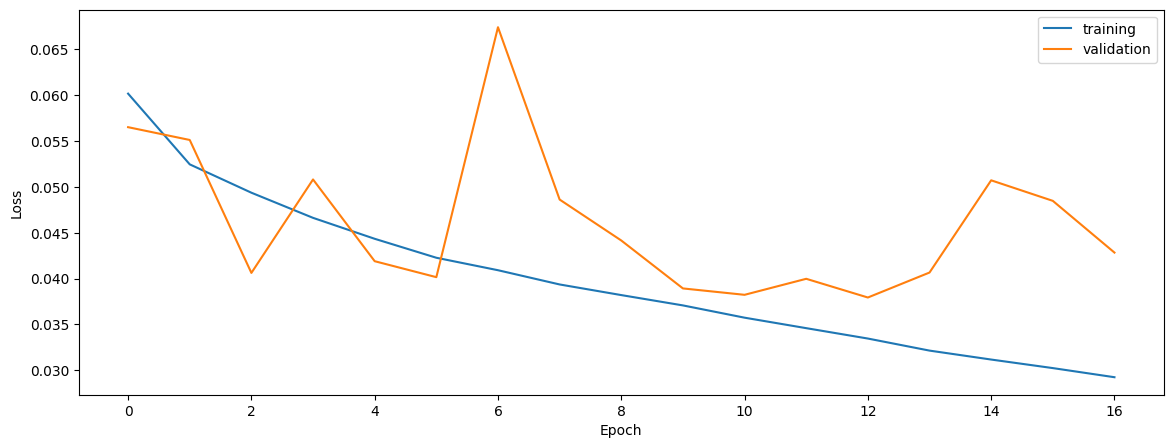

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5843939 and the array at index 1 has size 5734618

In [3]:
from DataGenerator import DataGenerator
import os
from util import pickleSave
from Model import *
from tensorflow.keras.optimizers import Adam
from util import pickleLoad
from visual import plotHistory
from util import predictInBatches, getPearson
import numpy as np
import keras

path = props['path']+'/models'

train_true = []
val_true = []
test_true = []
train_pred = []
val_pred = []
test_pred = []

class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, monitor='loss', patience=0):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
    def on_train_begin(self, logs=None):
        self.wait = 0
        self.best = np.inf
        self.minSTDreached = False
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if logs.get('STD') > 0.001:
            self.minSTDreached = True
        if current < self.best:
            self.wait = 0
            self.best = current
        elif not self.minSTDreached:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True

for i in range(7):
    props['single'] = i
    HASHID, HASH = getHashId(architecture,props)

    gen = DataGenerator(**props)
    train, val, test = gen.getData()

    stop = CustomEarlyStopping(
        monitor='val_loss',
        patience=architecture['patience'],
    )
    save = tf.keras.callbacks.ModelCheckpoint(
        filepath=path+'/{}.weights.h5'.format(HASHID),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )

    model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

    model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

    if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
        history = model.fit(DataWrapper(train,architecture['batch_size']),
            validation_data=DataWrapper(val,architecture['batch_size'],False),
            epochs=10000,
            verbose=1,
            callbacks = [save,stop],
        )
        pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

    model.load_weights(path+'/{}.weights.h5'.format(HASHID))

    train_true.append(train[1])
    val_true.append(val[1])
    test_true.append(test[1])
    train_pred.append(predictInBatches(model,train[0],architecture['batch_size']))
    val_pred.append(predictInBatches(model,val[0],architecture['batch_size']))
    test_pred.append(predictInBatches(model,test[0],architecture['batch_size']))
    print(getPearson(train_true[-1],train_pred[-1]))
    print(getPearson(val_true[-1],val_pred[-1]))
    print(getPearson(test_true[-1],test_pred[-1]))

    history = pickleLoad(path+'/{}.pkl'.format(HASHID))
    plotHistory(history)

def ste2con(ste):
    ste2 = np.repeat(np.expand_dims(np.sum(ste,-1),-1),ste.shape[-1],-1)
    ste2 = np.where(ste2==0,1,ste2)
    ste2 = ste/ste2
    return ste2

def addNotConnected(con):
    con = np.where(con <= threshold, 0, con)
    nc = (np.sum(con, axis=-1)*-1)+1
    nc = np.expand_dims(nc, -1)
    con = np.concatenate([con,nc],-1)
    return con

train_true = addNotConnected(ste2con(np.concatenate(train_true,-1)))
val_true = addNotConnected(ste2con(np.concatenate(val_true,-1)))
test_true = addNotConnected(ste2con(np.concatenate(test_true,-1)))
train_pred = addNotConnected(ste2con(np.concatenate(train_pred,-1)))
val_pred = addNotConnected(ste2con(np.concatenate(val_pred,-1)))
test_pred = addNotConnected(ste2con(np.concatenate(test_pred,-1)))

In [0]:
from util import getAccuracy

print('train')
print(getAccuracy(train_true,train_pred))
print(getAccuracy(val_true,val_pred))
print(getAccuracy(test_true,test_pred))

In [0]:
props2 = props.copy()
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train_true,train_pred))
print(getAccuracy(val_true,val_pred))
print(getAccuracy(test_true,test_pred))

In [0]:
print('normalized')
print(getAccuracy(train_true[train2[2]],train_pred[train2[2]]))
print(getAccuracy(val_true[val2[2]],val_pred[val2[2]]))
print(getAccuracy(test_true[test2[2]],test_pred[test2[2]]))

In [0]:
def y_pred(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    data_len = len(gen2.getDatapoint(gen2.names[idx][0],balance_override=True)[0])
    return [train_pred,val_pred,test_pred][idx][0:data_len]
def y_true(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    data_len = len(gen2.getDatapoint(gen2.names[idx][0],balance_override=True)[0])
    return [train_true,val_true,test_true][idx][0:data_len]

showResults(model, gen, threshold=0, predict=y_pred, label_true=y_true)